<a href="https://colab.research.google.com/github/AndreaCiufoDentsu/meridian/blob/main/Meridian_Scenario_Planner_External_Pilot_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/meridian/blob/main/demo/Meridian_Getting_Started.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/meridian/blob/main/demo/Meridian_Getting_Started.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# **Meridian Looker Studio Pilot**

Welcome to the Meridian Scenario Planner pilot guide. This colab will generatate an interactive Looker Studio dashboard based on a trained model.

Note that this notebook skips all of the pre-modeling and model setup steps. It assumes that you have a trained model that is saved and accessible in Google Drive. If you do not have a trained model yet, you can train a model and push it to Google Drive in <a href="https://developers.google.com/meridian/notebook/meridian-getting-started">this Colab</a>

If you are new to Looker Studio or Meridian, it will be helpful to review the following resources:
<ul>
 <li><a href="https://drive.google.com/file/d/130dSItnVFF9hmiBhZFXcqZDzDQC-uedY/view?usp=sharing">Meridian Scenario Planner Pilot User Guide</a></li>
  <li><a href="https://developers.google.com/meridian/notebook/meridian-getting-started">Get started with Meridian</a></li>
  <li><a href="https://cloud.google.com/looker/docs/studio/quick-start-guide">Looker Studio</a></li>
</ul>

To get started with Meridian Scenario Planner, follow the detailed instructions in this Colab, which coveries the following entries:

<ol start="0">
  <li><a href="#install">Install and setup</a></li>
  <li><a href="#load-model">Load the model</a></li>
  <li><a href="#dashboard">Generate dashboard</a></li>
  <li><a href="#save-and-sharing">Save and share dashboard</a></li>
</ol>

In pilot phase, Please copy this Colab if you would like to save changes.

Please use <a href="https://docs.google.com/forms/d/1LBx5S1fdVP5IBt6RHfhj38Pepkik7jzI3KtI4udviqg"> this form </a> to share feedback with Meridian team.

<a name="install"></a>
## Install and setup

1\. Make sure you are using one of the available GPU Colab runtimes which is **required** to run Meridian optimization. You can change your notebook's runtime in `Runtime > Change runtime type` in the menu. All users can use the T4 GPU runtime which is sufficient to run the demo colab, free of charge. Users who have purchased one of Colab's paid plans have access to premium GPUs (such as V100, A100 or L4 Nvidia GPU).

2\. Run the cell below to install necessary components and setup the environment. This step will not use GPU and it shoud take 3-5 mins to complete.

In [ ]:
#@markdown
proto_folder="mmm"

!mkdir -p {proto_folder}

proto_defs={
    "date_interval":'''
edition = "2023";
package ads.lift.mmm.schema.common;
import "google/type/date.proto";

option java_multiple_files = true;

message DateInterval {
  // The start date of the interval. Inclusive. Required.
  google.type.Date start_date = 1;

  // The end date of the interval. Exclusive. Required.
  google.type.Date end_date = 2;

  // A tag to identify the date interval. Optional.
  string tag = 3 [features.field_presence = IMPLICIT];
}
''',
    "estimate":'''
edition = "2023";
package ads.lift.mmm.schema.common;
option features.field_presence = IMPLICIT;
option java_multiple_files = true;

// Contains an estimate value of estimand and associated quantified
// uncertainties.
message Estimate {
  // The estimate value of an estimand. Required.
  double value = 1;

  // The uncertainty of an estimate quantified by probability interval.
  message Uncertainty {
    // The probability that a value is inside an interval bounded by lowerbound
    // and upperbound. Required.
    double probability = 1;

    // The lowerbound of the interval. Required.
    double lowerbound = 2;

    // The upperbound of the interval. Required.
    double upperbound = 3;
  }

  // The quantified uncertainties.
  repeated Uncertainty uncertainties = 2;
}
    ''',
    "kpi_type":'''
edition = "2023";

package ads.lift.mmm.schema.common;

option java_multiple_files = true;

// Different KPI types used in marketing performance and optimization.
enum KpiType {
  KPI_TYPE_UNSPECIFIED = 0;
  // Some generic user-defined KPI unit.
  NON_REVENUE = 1;
  // KPI defined as revenue specifically, or some KPI unit after conversion
  // to revenue.
  REVENUE = 2;
}
    ''',
    "target_metric":'''
edition = "2023";

package ads.lift.mmm.schema.common;

option java_multiple_files = true;

// Target metrics for marketing performance optimizations.
// Note that each of these metric variants can be interpreted in terms of either
// revenue or non-revenue KPI _type_. See: `common.KpiType`.
enum TargetMetric {
  TARGET_METRIC_UNSPECIFIED = 0;

  // Any KPI type (revenue if the model data can be converted to revenue, or
  // some generic KPI otherwise).
  KPI = 1;

  // ROI = net KPI change / spend.
  ROI = 2;

  // Marginal ROI is defined at channel level and is applied across all
  // channels.
  // mROI = changed in incremental KPI / spend.
  MARGINAL_ROI = 3;

  // CPIK = total spend / change in incremental KPI.
  COST_PER_INCREMENTAL_KPI = 4;
}
    ''',
    "model_fit":'''
edition = "2023";

package ads.lift.mmm.schema.fit;

import "date_interval.proto";
import "estimate.proto";

option features.field_presence = IMPLICIT;
option java_multiple_files = true;

// A prediction contains the predicted KPI and the ground truth at a specific
// time.
message Prediction {
  // The time associated to this prediction point. Required.
  common.DateInterval date_interval = 1;

  // The predicted outcome. Required.
  common.Estimate predicted_outcome = 2;

  // The predicted baseline. Optional.
  common.Estimate predicted_baseline = 3;

  // The actual value observed in the data. Required.
  double actual_value = 4;
}

// The model fit performance indicated by different metrics.
message Performance {
  double r_squared = 1;

  // Mean absolute percentage error.
  double mape = 2;

  // Is equal to sum_i(actual_i - pred_i) / sum_i(actual_i)
  double weighted_mape = 3;

  // Root mean square error.
  double rmse = 4;
}

message Result {
  // The name of the result. Required.
  string name = 1;

  // The predictions over different times. Required.
  repeated Prediction predictions = 2;

  // The performance of the model fit. Required.
  Performance performance = 3;
}

message ModelFit {
  // Different results for different purposes. For example, one could divide a
  // data to training set, testing set, and validation set. Required.
  repeated Result results = 1;
}
    ''',
    "kpi_outcome":'''
edition = "2023";

package ads.lift.mmm.schema.marketing.analysis;

import "estimate.proto";
import "kpi_type.proto";

option features.field_presence = IMPLICIT;
option java_multiple_files = true;

// A contribution is defined as the value difference caused by adding a new
// outcome.
message Contribution {
  // The contribution value. Required.
  common.Estimate value = 1;

  // Share of contribution = contribution / total contribution from all
  // outcomes.
  common.Estimate share = 2;
}

// Effectiveness calculates how much incremental KPI is generated per media unit
// (e.g. impressions or clicks), i.e. contribution / media unit.
message Effectiveness {
  // The media unit of the effectiveness. Required.
  string media_unit = 1;

  // The value of the effectiveness. Required.
  common.Estimate value = 2;
}

// An outcome analysis on KPI which can be defined as revenue or other generic
// non-revenue type.
// Next ID: 7
message KpiOutcome {
  // The type of this KPI (i.e. REVENUE or NON_REVENUE)
  // Note that a model input with non-revenue (generic KPI) data can still have
  // revenue-based KPI outcomes defined, provided that `revenue_per_kpi` is
  // defined.
  common.KpiType kpi_type = 1;

  // The contribution to a KPI.
  // If `kpi_type == REVENUE`, this is the revenue KPI value.
  // If `kpi_type == NON_REVENUE`, AND there is a `revenue_per_kpi` conversion,
  // this is the derived `kpi * revenue_per_kpi` value.
  // Otherwise, this is simply the (non-revenue, user-defined) KPI value.
  Contribution contribution = 2;

  // The effectiveness of this outcome.
  Effectiveness effectiveness = 3;

  // ROI = contribution / spend.
  // See contribution definition above.
  common.Estimate roi = 4;

  // Marginal ROI shows the additional ROI gained from additional spend.
  // See ROI definition above.
  common.Estimate marginal_roi = 5;

  // Cost per incremental outcome (which could be revenue or some generic KPI).
  // E.g. when contribution is thousand impression, it is CPM; when contribution
  // is acquisition, this is CPA.
  common.Estimate cost_per_contribution = 6;
}
    ''',
    "marketing_analysis":'''
edition = "2023";

package ads.lift.mmm.schema.marketing.analysis;

import "date_interval.proto";
import "media_analysis.proto";
import "non_media_analysis.proto";

option java_multiple_files = true;

// The marketing analysis.
message MarketingAnalysis {
  // The date interval that the analysis covers. Required.
  common.DateInterval date_interval = 1;

  // Analysis on different media channels. Required.
  repeated MediaAnalysis media_analyses = 2;

  // Analysis on different non-media factors.
  repeated NonMediaAnalysis non_media_analyses = 3;
}

// A list of marketing analyses.
message MarketingAnalysisList {
  // The marketing analyses for different time ranges. Required.
  repeated MarketingAnalysis marketing_analyses = 1;
}
    ''',
    "media_analysis":'''
edition = "2023";

package ads.lift.mmm.schema.marketing.analysis;

import "kpi_outcome.proto";
import "response_curve.proto";

option features.field_presence = IMPLICIT;
option java_multiple_files = true;

message SpendInfo {
  // The amount spent on the media channel. Required
  double spend = 1;

  // Spend share = spend / total spend. Required
  double spend_share = 2;
}

// An analysis on a media channel between its spend variable and KPI(s) outcome.
// Next ID: 6
message MediaAnalysis {
  reserved 3;

  // The name of the media channel. Required.
  string channel_name = 1;

  // The spend information of this media channel.
  //
  // This is optional and is left unset for a non-paid media channel analysis.
  SpendInfo spend_info = 2;

  // The marketing outcomes of advertising from this media channel. Required.
  //
  // The outcome(s) calculated based on revenue and/or generic non-revenue KPI.
  // One or more outcome values are set when revenue and/or generic non-revenue
  // KPI outcome information is available.
  //
  // For a non-paid media, the spend-related fields in `KpiOutcome` won't be
  // set.
  repeated KpiOutcome media_outcomes = 5;

  // A response curve for the media channel.
  //
  // When the media is a non-paid media, response curve is not available due to
  // the lack of spend information.
  ResponseCurve response_curve = 4;
}
    ''',
    "non_media_analysis":'''
edition = "2023";

package ads.lift.mmm.schema.marketing.analysis;

import "kpi_outcome.proto";

option features.field_presence = IMPLICIT;
option java_multiple_files = true;

// The analysis on non-media factor.
// Next ID: 4
message NonMediaAnalysis {
  reserved 2;

  // The name of the non-media factor. Required.
  string non_media_name = 1;

  // The marketing outcomes from this non-media factor. Required.
  //
  // The non-media outcome(s) calculated based on revenue and/or generic
  // non-revenue KPI. One or more outcome values are set when revenue and/or
  // generic non-revenue KPI outcome information is available.
  //
  // The spend-related fields herein won't be set as non-media factor doesn't
  // have spend.
  repeated KpiOutcome non_media_outcomes = 3;
}
    ''',
    "response_curve":'''
edition = "2023";

package ads.lift.mmm.schema.marketing.analysis;

option features.field_presence = IMPLICIT;
option java_multiple_files = true;

message ResponsePoint {
  // The amount of the input that drives the incremental KPI. Required.
  double input_value = 1;

  // The incremental KPI caused by the input. Required.
  double incremental_kpi = 2;
}

// A response curve is used to show how much incremental KPI moves in response
// to changes to the input value (e.g. spend amount on a paid media channel,
// advertising impressions in a channel, etc).
message ResponseCurve {
  // The name of the input. Required.
  string input_name = 1;

  // The response points. Required.
  repeated ResponsePoint response_points = 2;
}
    ''',
    "budget_optimization":'''
    edition = "2023";

package ads.lift.mmm.schema.marketing.optimization;

import "date_interval.proto";
import "estimate.proto";
import "kpi_type.proto";
import "target_metric.proto";
import "marketing_analysis.proto";
import "constraints.proto";

option features.field_presence = IMPLICIT;
option java_multiple_files = true;

// A fixed budget scenario for optimizing budget allocations over channels.
message FixedBudgetScenario {
  // The budget amount. Required.
  double total_budget = 1;
}

// A flexible budget scenario for optimizing budget allocations over channels.
message FlexibleBudgetScenario {
  // The constraint parameters on the total budget.
  BudgetConstraint total_budget_constraint = 1;

  // The constraints on target metrics (e.g. KPI, ROI, etc).
  repeated TargetMetricConstraint target_metric_constraints = 2;
}

// Channel level constraint
message ChannelConstraint {
  // The name of the channel. Required.
  string channel_name = 1;

  // The budget constraint on the channel.
  BudgetConstraint budget_constraint = 2;
}

// Input to the optimizer.
// Next ID: 7
message BudgetOptimizationSpec {
  // The date interval defines the selection of the time points that the
  // optimization is based upon.
  common.DateInterval date_interval = 1;

  // The objective to maximize in the budget optimization. Required.
  common.TargetMetric objective = 2;

  // The type of KPI used to derive the optimization objective. Required.
  common.KpiType kpi_type = 6;

  // The optimization scenario. Required.
  oneof scenario {
    // A fixed budget optimization tries to maximize an objective by optimizing
    // the budget allocations over channels without changing the total budget
    // amount.
    //
    // For instance, in Meridian, the objective function is chosen to be the
    // posterior mean of the expected KPI (e.g. sales, revenue, etc).
    FixedBudgetScenario fixed_budget_scenario = 3;

    // A flexible budget optimization tries to maximize an objective by
    // optimizing the budget allocations over channels with a flexible total
    // budget amount.
    //
    // For instance, in Meridian, the expected KPI (e.g. revenue) can be
    // optimized while allowing the total budget to vary: this flexible
    // optimization in Meridian is constrained on either the minimal marginal
    // ROI or the target ROI constraints.
    FlexibleBudgetScenario flexible_budget_scenario = 4;
  }

  // The constraints on channels.
  // If a media channel that is present in the model is not represented here,
  // it will be given the default constraint of `[0, max_budget]`.
  repeated ChannelConstraint channel_constraints = 5;
}

// A message representing a grid that details the incremental outcome of
// marketing spend by channel.
//
// Note that this grid is constructed under the assumption that there is no
// interaction effect across channels, i.e. the spend on one channel will not
// affect other channels.
// Next ID: 4
message IncrementalOutcomeGrid {
  // A data point within the grid representing the outcome of a specific spend
  // on a particular channel.
  message Cell {
    // The amount of marketing spend allocated to the channel.
    double spend = 1;

    // The incremental outcome achieved through the channel spend. The type
    // should be indicated by the objective in the optimization spec.
    //
    // This is calculated as the difference between the outcome with the given
    // spend and the outcome with zero spend (outcome(spend) - outcome(0)).
    common.Estimate incremental_outcome = 2;
  }

  // A collection of cells in a channel.
  message ChannelCells {
    // The name of the marketing channel.
    string channel_name = 1;

    // The cells in the channel.
    repeated Cell cells = 2;
  }

  // The name of the grid. Required.
  string name = 1;

  // The uniform step size between consecutive spend values within a channel.
  // Required.
  double spend_step_size = 2;

  // The collection of cells representing all combinations of spend and
  // incremental outcome across channels. Required.
  //
  // Each channel can have a different spend range, but all spend values within
  // a channel must be spaced evenly using the specified step size.
  repeated ChannelCells channel_cells = 3;
}

// The budget optimization finds the result of optimal budget allocation given
// an optimization spec.
// Next ID: 8
message BudgetOptimizationResult {
  reserved 4;

  // The name of the budget optimization. Required.
  string name = 1;

  // An optional identifier for a result that belongs to a group of related
  // results (of different types).
  // Note that no two `BudgetOptimizationResult`s should share the same group ID
  // Simple UUID strings are recommended.
  string group_id = 5;

  // The optimization spec used to generate the result. Required.
  BudgetOptimizationSpec spec = 2;

  // The analysis on marketing outcome when using the optimized budget.
  // Required.
  //
  // The non-media outcomes are not optimized, but some fields might be impacted
  // by the change of media outcomes. For example, total contribution would
  // change, so the contribution share values have to modified accordingly.
  analysis.MarketingAnalysis optimized_marketing_analysis = 3;

  // The non-optimized marketing outcome. Required.
  //
  // In a fixed budget scenario, non-optimized marketing outcome is based on the
  // budget amount. In a flexible budget scenario, the outcome is based on the
  // historical spend.
  analysis.MarketingAnalysis nonoptimized_marketing_analysis = 7;

  // Optional search grid that describes incremental outcomes of spends on
  // channels. Useful for speeding up optimization analysis.
  IncrementalOutcomeGrid incremental_outcome_grid = 6;
}

message BudgetOptimization {
  // Optimization results for different scenarios.
  repeated BudgetOptimizationResult results = 1;
}
    ''',
    "constraints":'''
edition = "2023";

package ads.lift.mmm.schema.marketing.optimization;

import "target_metric.proto";

option features.field_presence = IMPLICIT;
option java_multiple_files = true;

// The constraint of target metrics.
message TargetMetricConstraint {
  reserved 2, 3;

  // The type of the target metric that is constrained. Required.
  common.TargetMetric target_metric = 1;

  // The constraint on the target metric value. Required.
  // Whether this target value represents a lower or upper bound depends on the
  // target metric set above.
  double target_value = 4;
}

message BudgetConstraint {
  // Required.
  // Absolute minimum budget value.
  double min_budget = 1;

  // Required.
  // Absolute maximum budget value.
  double max_budget = 2;
}

message FrequencyConstraint {
  // Required.
  double min_frequency = 1;

  // Required.
  double max_frequency = 2;
}
    ''',
    "marketing_optimization":'''
edition = "2023";

package ads.lift.mmm.schema.marketing.optimization;

import "budget_optimization.proto";
import "reach_frequency_optimization.proto";

option java_multiple_files = true;

// Marketing optimization contains all optimization related results.
message MarketingOptimization {
  // Budget optimization that contains results for different scenarios.
  BudgetOptimization budget_optimization = 1;

  // Reach frequency optimization that contains results for different scenarios.
  ReachFrequencyOptimization reach_frequency_optimization = 2;
}
    ''',
    "reach_frequency_optimization":'''
edition = "2023";

package ads.lift.mmm.schema.marketing.optimization;

import "date_interval.proto";
import "estimate.proto";
import "kpi_type.proto";
import "target_metric.proto";
import "marketing_analysis.proto";
import "marketing_data.proto";
import "constraints.proto";

option features.field_presence = IMPLICIT;
option java_multiple_files = true;

// Channel level constraint for channel that has reach frequency information.
message RfChannelConstraint {
  // The name of the channel. Required.
  string channel_name = 1;

  // The budget constraint on the channel.
  BudgetConstraint budget_constraint = 2;

  // The frequency constraint on the channel.
  FrequencyConstraint frequency_constraint = 3;
}

// Next ID: 7
message ReachFrequencyOptimizationSpec {
  // The date interval defines the selection of the time points that the
  // optimization is based upon.
  common.DateInterval date_interval = 1;

  // The objective to maximize in the reach frequency optimization. Required.
  common.TargetMetric objective = 2;

  // The type of KPI used to derive the optimization objective. Required.
  common.KpiType kpi_type = 6;

  // The constraints on target metrics (e.g. KPI, ROI, etc).
  repeated TargetMetricConstraint target_metric_constraints = 3;

  // The constraint on the total budget.
  BudgetConstraint total_budget_constraint = 4;

  // The constraints on channels that have reach frequency information.
  repeated RfChannelConstraint rf_channel_constraints = 5;
}

// Reach frequency optimization result for channel that has reach frequency
// information.
message OptimizedChannelFrequency {
  // The name of the channel. Required.
  string channel_name = 1;

  // The optimal average frequency of the channel. Required.
  double optimal_average_frequency = 2;
}

// A message representing a grid that details the outcome of reach frequency by
// channel.
//
// Note that this grid is constructed under the assumption that there is no
// interaction effect across channels, i.e. the reach frequency on one channel
// will not affect other channels.
// Next ID: 4
message FrequencyOutcomeGrid {
  // A data point within the grid representing the outcome of a specific reach
  // frequency on a particular channel.
  message Cell {
    // The reach and frequency of the channel.
    ReachFrequency reach_frequency = 1;

    // The outcome achieved through the channel reach frequency. The type should
    // be indicated by the objective in the optimization spec.
    common.Estimate outcome = 2;
  }

  // A collection of cells in a channel.
  message ChannelCells {
    // The name of the marketing channel.
    string channel_name = 1;

    // The cells in the channel.
    repeated Cell cells = 2;
  }

  // The name of the grid. Required.
  string name = 1;

  // The uniform step size between consecutive frequency values within a
  // channel. Required.
  double frequency_step_size = 2;

  // The collection of cells representing all combinations of reach frequency
  // and outcome across channels. Required.
  repeated ChannelCells channel_cells = 3;
}

// Next ID: 8
message ReachFrequencyOptimizationResult {
  reserved 5;

  // The name of the reach frequency optimization. Required.
  string name = 1;

  // An optional identifier for a result that belongs to a group of related
  // results (of different types).
  // Note that no two `ReachFrequencyOptimizationResult`s should share the same
  // group ID.
  // Simple UUID strings are recommended.
  string group_id = 6;

  // The optimization spec used to generate the result. Required.
  ReachFrequencyOptimizationSpec spec = 2;

  // Optimal average frequency results by channel. Required.
  //
  // Media channels without reach frequency data won't be shown.
  repeated OptimizedChannelFrequency optimized_channel_frequencies = 3;

  // The analysis on marketing outcome when using the optimal channel
  // frequencies. Required.
  //
  // The non-media outcomes are not optimized, but some fields might be impacted
  // by the change of media outcomes. For example, total contribution would
  // change, so the contribution share values have to modified accordingly.
  analysis.MarketingAnalysis optimized_marketing_analysis = 4;

  // Optional grid that describes the outcomes of reach frequency on channels.
  FrequencyOutcomeGrid frequency_outcome_grid = 7;
}

message ReachFrequencyOptimization {
  // Optimization results for different scenarios.
  repeated ReachFrequencyOptimizationResult results = 1;
}
    ''',
    "marketing_data":'''
edition = "2023";

package ads.lift.mmm.schema.marketing;

import "date_interval.proto";
import "google/type/date.proto";

option features.field_presence = EXPLICIT;
option java_multiple_files = true;

message GeoInfo {
  // The ID of the geo location. Required.
  string geo_id = 1;

  // The population of the geo location. Required.
  int64 population = 2;
}

// A KPI (key performance indicator) can either be revenue directly, or some
// other metric that indirectly contributes to revenue eventually (e.g. sales
// units, conversions, impressions, etc) with a multiplier value to roughly
// translates said non-revenue KPI unit into revenue.
message Kpi {
  // A revenue KPI.
  message Revenue {
    // The revenue value.
    //
    // Required.
    double value = 1;
  }

  // A non-revenue type of KPI.
  message NonRevenue {
    // The value of the non-revenue KPI.
    //
    // Required
    double value = 1;

    // Used to convert non-revenue KPI value to revenue.
    //
    // Needs to be non-negative.
    double revenue_per_kpi = 2;
  }

  // The name of the KPI. Required
  string name = 1;

  // The type of the KPI. Required
  oneof type {
    Revenue revenue = 2;
    NonRevenue non_revenue = 3;
  }
}

// The control variable. A control variable is not directly being studied but
// included in the model to account for potential confounding effects on the
// relationship between the primary independent and dependent variables.
// Examples: seasonality factors, and macroeconomic factors.
message ControlVariable {
  // The name of the variable. Required.
  string name = 1;

  // The value of the variable. Required.
  double value = 2;
}

// The non-media treatment variable. A marketing activity that is not directly
// related to media, such as running a promotion, the price of a product, and
// a change in a product's packaging or design.
message NonMediaTreatmentVariable {
  // The name of the variable. Required.
  string name = 1;

  // The value of the variable. Required.
  double value = 2;
}

// Scalar type of metrics. Ex: Impressions, clicks, costs, and etc.
message ScalarMetric {
  // The name of the scalar metric. Required.
  string name = 1;

  // The value of the scalar metric. Required.
  double value = 2;
}

// Reach and frequency metric.
message ReachFrequency {
  // Reach value. Required.
  int64 reach = 1;

  // Average frequency value. Required.
  double average_frequency = 2;
}

// The media variable.
message MediaVariable {
  reserved 3;

  // The name of the media channel. Required
  string channel_name = 1;

  // Scalar metric measured on the channel. Required.
  ScalarMetric scalar_metric = 2;

  // Spend on the media.
  //
  // If the media variable is a paid media, spend is required.
  double media_spend = 4;
}

// The reach and frequency variable.
message ReachFrequencyVariable {
  // The name of the reach and frequency variable. Required.
  string channel_name = 1;

  // The reach value. Required.
  int64 reach = 2;

  // The average frequency value. Required.
  double average_frequency = 3;

  // The spend value.
  //
  // If the reach and frequency variable is a paid media, spend is required.
  double spend = 4;
}

// A data point contains marketing information at specific geo and time.
message MarketingDataPoint {
  // Geo info of this data point.
  // If unset, this data point is aggregated across all geos in the model's
  // geo coordinates.
  GeoInfo geo_info = 1;

  // Date interval covered by this data point. Required.
  // This can represent either a coordinate point, or an aggregation over a time
  // dimension's coordinates. In the case of the latter, this field should be
  // defined with `[start, end + interval]` value, where `start` and `end` are
  // the first and last coordinate in that time dimension, respectively.
  common.DateInterval date_interval = 2;

  // The control variables associated to the marketing at this geo and time.
  repeated ControlVariable control_variables = 3;

  // The media variables associated to the marketing at this geo and time.
  //
  // If a media variable is from a paid media channel and its media spend
  // breakdown by geo and time is not available (i.e. media spend is aggregated
  // across all geos and times), then there should be a separate
  // `MarketingDataPoint` message with `media_spend` where `geo_info` is unset
  // and `date_interval` spans the entire time dimension's coordinates.
  //
  // Media channel names should be unique across this group of media variables.
  repeated MediaVariable media_variables = 4;

  // The reach and frequency variables associated to the marketing at this geo
  // and time.
  //
  // If a reach and frequency variable is from a paid media channel and its
  // spend breakdown by geo and time is not available (i.e. spend is
  // aggregated across all geos and times), then there should be a separate
  // `MarketingDataPoint` message with `spend` where `geo_info` is unset and
  // `date_interval` spans the entire time dimension's coordinates.
  //
  // Reach and frequency variable names should be unique across this group of
  // reach and frequency variables.
  repeated ReachFrequencyVariable reach_frequency_variables = 6;

  // The KPI associated to the marketing at this geo and time.
  // Kpi type must be consistent across all data points.
  Kpi kpi = 5;

  // Non-media treatment variables associated with this data point.
  repeated NonMediaTreatmentVariable non_media_treatment_variables = 7;
}

// Metadata support useful to validate data points and recreate a model data in
// its domain language.
message MarketingDataMetadata {
  // A named set of time coordinates.
  message TimeDimension {
    // A name for this set of time coordinates. Optional.
    string name = 1;

    // The coordinates of this time dimension in the model, as dates. Required.
    repeated google.type.Date dates = 2;
  }

  // One or more sets of time coordinates. Required.
  repeated TimeDimension time_dimensions = 1;

  message GeoDimension {
    repeated string geo_coordinates = 1;
  }

  // The geo dimension of the model. Required.
  GeoDimension geo_dimension = 2;

  // A named set of channel name coordinates.
  message ChannelDimension {
    // A name for this set of channel names in this dimension. Optional.
    string name = 1;

    // The channel names in this set's dimensional coordinates. Required.
    repeated string channels = 2;
  }

  // One or more sets of channel names. Required.
  repeated ChannelDimension channel_dimensions = 3;

  // Control variable names.
  repeated string control_names = 4;

  // The KPI type.
  string kpi_type = 5;

  // Non-media treatment variable names.
  repeated string non_media_treatment_names = 6;
}

// A collection of marketing data points for different combinations of geo
// locations and times.
message MarketingData {
  // The marketing data points. Required.
  repeated MarketingDataPoint marketing_data_points = 1;

  // Metadata support useful to recreate a model data in its domain language.
  MarketingDataMetadata metadata = 2;
}
    ''',
    "meridian_model":'''
edition = "2023";

package ads.lift.mmm.schema.model.meridian;

import "tensorflow/core/framework/tensor.proto";
import "tensorflow/core/framework/tensor_shape.proto";

option features.field_presence = EXPLICIT;
option java_multiple_files = true;

// Represents Tensorflow statistical distributions that are used in user priors
// in a Meridian model.
// All fields are required unless otherwise specified.
// See: https://www.tensorflow.org/probability/api_docs/python/tfp/distributions
// Next ID: 11
message Distribution {
  message Bijector {
    double shift = 1;
  }

  // The following message types are the distribution types that Meridian
  // supports.

  // A distribution that broadcasts an underlying distribution's batch shape.
  message BatchBroadcast {
    // The underlying (pre-broadcast) distribution.
    Distribution distribution = 1;
    // The shape of the broadcast distribution.
    tensorflow.TensorShapeProto batch_shape = 2;
  }

  // A distribution that is transformed by a bijector.
  message Transformed {
    // The underlying (pre-transformed) distribution.
    Distribution distribution = 1;
    // The transforming bijector.
    Bijector bijector = 2;
  }

  // A scalar deterministic distribution on the real line.
  message Deterministic {
    // The batch of points on which this distribution is supported.
    repeated double locs = 1;
  }

  // A half-normal distribution with scales.
  message HalfNormal {
    // The scales of the distribution.
    repeated double scales = 1;
  }

  // A log-normal distribution with locs (means) and scales (stddevs).
  message LogNormal {
    // The means of the underlying Normal distribution.
    repeated double locs = 1;
    // The standard deviations of the underlying normal distribution.
    repeated double scales = 2;
  }

  // A normal distribution with locs (means) and scales (stddevs).
  message Normal {
    // The means of the underlying Normal distribution.
    repeated double locs = 1;
    // The standard deviations of the underlying normal distribution.
    // Must contain only positive values.
    repeated double scales = 2;
  }

  // A truncated Normal distribution, bounded between `low` and `high`.
  message TruncatedNormal {
    // The means of the underlying Normal distribution.
    repeated double locs = 1;
    // The standard deviations of the underlying Normal distribution.
    repeated double scales = 2;
    // Lower bound of the distribution's support. Must be less than `high`.
    double low = 3;
    // Upper bound of the distribution's support. Must be greater than `low`.
    double high = 4;
  }

  // A uniform distribution on the real line.
  message Uniform {
    // Lower boundary of the output interval. Must be less than `high`.
    double low = 1;
    // Upper boundary of the output interval. Must be greater than `low`.
    double high = 2;
  }

  // A Beta distribution with alpha and beta parameters.
  // See:
  // https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Beta
  message Beta {
    // The alpha parameter of the underlying Beta distribution.
    repeated double alpha = 1;
    // The beta parameter of the underlying Beta distribution.
    repeated double beta = 2;
  }

  // The canonical name of this distribution in the Meridian model framework.
  string name = 1;

  oneof distribution_type {
    BatchBroadcast batch_broadcast = 2;
    Deterministic deterministic = 3;
    HalfNormal half_normal = 4;
    LogNormal log_normal = 5;
    Normal normal = 6;
    Transformed transformed = 7;
    TruncatedNormal truncated_normal = 8;
    Uniform uniform = 9;
    Beta beta = 10;
  }
}

// A container for parameter prior distributions in a Meridian model.
// These distributions are in their mathematical forms when representing
// user priors in the model spec and are part of the user input in a pre-fitted
// model.
//
// After priors sampling, these distributions are broadcast and should _all_
// contain `Distribution.BatchBroadcast` types.
//
// All parameter distributions are optional. If a distribution is left
// unspecified for a given parameter, Meridian will select its default prior
// distribution.
//
// See: `meridian.model.prior_distribution` module.
// See:
// https://developers.google.com/meridian/docs/advanced-modeling/default-prior-distributions
// Next ID: 37
// LINT.IfChange
message PriorDistributions {
  Distribution knot_values = 1;
  Distribution tau_g_excl_baseline = 2;
  Distribution beta_m = 3;
  Distribution beta_rf = 4;
  Distribution eta_m = 5;
  Distribution eta_rf = 6;
  Distribution gamma_c = 7;
  Distribution xi_c = 8;
  Distribution alpha_m = 9;
  Distribution alpha_rf = 10;
  Distribution ec_m = 11;
  Distribution ec_rf = 12;
  Distribution slope_m = 13;
  Distribution slope_rf = 14;
  Distribution sigma = 15;
  Distribution roi_m = 16;
  Distribution roi_rf = 17;
  Distribution mroi_m = 30;
  Distribution mroi_rf = 31;
  Distribution contribution_m = 32;
  Distribution contribution_rf = 33;
  Distribution contribution_om = 34;
  Distribution contribution_orf = 35;
  Distribution contribution_n = 36;
  Distribution beta_om = 18;
  Distribution beta_orf = 19;
  Distribution eta_om = 20;
  Distribution eta_orf = 21;
  Distribution gamma_n = 22;
  Distribution xi_n = 23;
  Distribution alpha_om = 24;
  Distribution alpha_orf = 25;
  Distribution ec_om = 26;
  Distribution ec_orf = 27;
  Distribution slope_om = 28;
  Distribution slope_orf = 29;
}
// LINT.ThenChange(
//     //depot/google3/third_party/py/meridian/constants.py,
// )

// Possible distribution types for media random effects across geos.
enum MediaEffectsDistribution {
  MEDIA_EFFECTS_DISTRIBUTION_UNSPECIFIED = 0;
  NORMAL = 1;
  LOG_NORMAL = 2;
}

// Possible paid media prior types.
enum PaidMediaPriorType {
  PAID_MEDIA_PRIOR_TYPE_UNSPECIFIED = 0;
  ROI = 1;
  MROI = 2;
  COEFFICIENT = 3;
  CONTRIBUTION = 4;
}

// Possible non-paid treatments prior types.
enum NonPaidTreatmentsPriorType {
  NON_PAID_TREATMENTS_PRIOR_TYPE_UNSPECIFIED = 0;
  NON_PAID_TREATMENTS_PRIOR_TYPE_COEFFICIENT = 1;
  NON_PAID_TREATMENTS_PRIOR_TYPE_CONTRIBUTION = 2;
}

// Hyperparameters for the MMM model.
// google3/third_party/py/meridian/model/spec.py
// Next ID: 22
message Hyperparameters {
  reserved 5;

  // Specifies the distribution of media random effects across geos.
  // This hyperparameter is ignored in a national-level model.
  MediaEffectsDistribution media_effects_dist = 1;

  // Indicates whether to apply the Hill function before Adstock function.
  // This hyperparameter does not apply to RF channels.
  bool hill_before_adstock = 2;

  // The maximum number of lag periods (>= 0) to include in the Adstock
  // calculation. If unset, then max lag is interpreted as infinite.
  uint32 max_lag = 3;

  // Indicates whether to use a unique residual variance for each geo.
  // If False, then a single residual variance is used for all geos.
  bool unique_sigma_for_each_geo = 4;

  // Prior type for the media coefficients. If `paid_media_prior_type` is
  // 'coefficient'`, then the model uses `beta_[m|rf]` distributions in the
  // priors. If `paid_media_prior_type' is `'roi'` or `'mroi'`, then the
  // `roi_[m|rf]` are used.
  PaidMediaPriorType paid_media_prior_type = 13 [deprecated = true];

  // Prior type for the media coefficients. If `media_prior_type` is
  // 'coefficient'`, then the model uses `beta_m` distribution in the priors. If
  // `media_prior_type' is `'roi'` or `'mroi'`, then the `roi_m` or `mroi_m` is
  // used, respectively. If `media_prior_type` is `'contribution'`, then the
  // `contribution_m` is used.
  PaidMediaPriorType media_prior_type = 17;

  // Prior type for the rf coefficients. If `rf_prior_type` is 'coefficient'`,
  // then the model uses `beta_rf` distribution in the priors. If
  // `rfprior_type' is `'roi'` or `'mroi'`, then the `roi_rf` or `mroi_rf` is
  // used, respectively. If `rf_prior_type` is `'contribution'`, then the
  // `contribution_rf` is used.
  PaidMediaPriorType rf_prior_type = 18;

  // Prior type for the organic media coefficients. If
  // `organic_media_prior_type` is 'coefficient'`, then the model uses `beta_om`
  // distribution in the priors. If
  // `organic_media_prior_type` is `'contribution'`, then the `contribution_om`
  // is used.
  NonPaidTreatmentsPriorType organic_media_prior_type = 19;

  // Prior type for the organic rf coefficients. If `organic_rf_prior_type` is
  // 'coefficient'`, then the model uses `beta_orf` distribution in the priors.
  // If `organic_rf_prior_type` is `'contribution'`, then the
  // `contribution_orf` is used.
  NonPaidTreatmentsPriorType organic_rf_prior_type = 20;

  // Prior type for the non-media treatments coefficients. If
  // `non_media_treatments_prior_type` is 'coefficient'`, then the model uses
  // `gamma_n` distribution in the priors. If
  // `non_media_treatments_prior_type` is `'contribution'`, then the
  // `contribution_n` is used.
  NonPaidTreatmentsPriorType non_media_treatments_prior_type = 21;

  // A boolean tensor in the shape `(n_media_times, n_media_channels)`.
  // This indicates the subset of `time` coordinates in the model for media ROI
  // calibration. If unset, all time coordinates are used for media ROI
  // calibration.
  tensorflow.TensorProto roi_calibration_period = 9;

  // A boolean tensor in the shape `(n_media_times, n_rf_channels)`.
  // This indicates the subset of `time` coordinates in the model for reach and
  // frequency ROI calibration. If unset, all time coordinates are used for R&F
  // ROI calibration.
  tensorflow.TensorProto rf_roi_calibration_period = 10;

  // A (single-value) integer or a list of integers, indicating the knots used
  // to estimate time effects.
  // If provided as a list of integers, its indices correspond to the indices of
  // the time coordinates in the model.
  // If provided as a single integer, then there are knots with locations
  // equally spaced across time periods.
  // If unset, then the number of knots used is equal to the number of time
  // periods in the case of a geo model (i.e. each time period has its own
  // regression coefficient). If unset in a national model, then the model
  // uses `1` as the number of knots.
  repeated int32 knots = 6;

  // The baseline geo is treated as the reference geo in the encoding of geos.
  // If neither option is set, the model will use the geo with the biggest
  // population as the baseline geo.
  oneof baseline_geo_oneof {
    // Deprecated.  Use `baseline_geo_int` instead.
    double baseline_geo_int_deprecated = 7 [deprecated = true];
    // Integer representation of baseline geo.
    int32 baseline_geo_int = 15;
    string baseline_geo_string = 8;
  }

  oneof holdout_spec {
    // A boolean tensor in the shape `(n_geos, n_times)` for a geo-level model
    // or `(n_times,)` for a national model.
    // This indicates which observations are part of the holdout sample, which
    // are excluded from the training sample. For more details on the holdout
    // sample, see: `meridian.model.spec.ModelSpec`
    tensorflow.TensorProto holdout_id = 11;

    // The ratio of holdout data to use for the goodness of fit check. Used as
    // inputs and this will be implemented in training module right before
    // feeding into Meridian.
    // The holdout only applied to date as of Q1 2025.
    double holdout_ratio = 16 [default = 0.1];
  }

  // A boolean tensor in the shape `(n_controls,)`.
  // This indicates the control variables for which the control value will be
  // scaled by population.
  // If unset, no control variables are scaled by population.
  tensorflow.TensorProto control_population_scaling_id = 12;

  // A boolean tensor in the shape `(n_non_media_channels,)`.
  // This indicates the non-media treatments channels for which the value will
  // be scaled by population.
  // If unset, no non-media treatments channels are scaled by population.
  tensorflow.TensorProto non_media_population_scaling_id = 14;
}

// A named tensor parameter.
message Parameter {
  string name = 1;
  tensorflow.TensorProto tensor = 2;
}

// InferenceData data contains none, only prior, or both prior and posterior
// sampled parameters and their sampling states and trace from fitting the
// model.
// https://python.arviz.org/en/stable/api/generated/arviz.InferenceData.html
//
// All fields inside this container are `xarray.Dataset`s that are
// byte-serialized in NetCDF format.
// See: https://docs.xarray.dev/en/stable/user-guide/io.html
message InferenceData {
  reserved 1;

  // Sampled prior parameters as an `xarray.Dataset` serialized in NetCDF4
  // format.
  bytes prior = 2;

  // Sampled posterior parameters as an `xarray.Dataset` serialized in NetCDF4
  // format.
  bytes posterior = 3;

  // Contains "sample_stats", "trace", and other auxiliary data that are useful
  // for debugging.
  // "sample_stats" and "trace" specifically are available when `posterior` is
  // available.
  map<string, bytes> auxiliary_data = 4;
}

// The trace of MCMC sampling.
message McmcSamplingTrace {
  uint32 num_chains = 1;
  uint32 num_draws = 2;
  tensorflow.TensorProto step_size = 3;
  tensorflow.TensorProto tune = 4;
  tensorflow.TensorProto target_log_prob = 5;
  tensorflow.TensorProto diverging = 6;
  tensorflow.TensorProto accept_ratio = 7;
  tensorflow.TensorProto n_steps = 8;
  tensorflow.TensorProto is_accepted = 9;
}

// Diagnostic of MCMC sampling by computing r_hat value for each parameters.
message RHatDiagnostic {
  // The r-hat values of model parameters.
  //
  // Current list of parameters: (see InferenceData.parameters above)
  repeated Parameter parameter_r_hats = 1;
}

message ModelConvergence {
  McmcSamplingTrace mcmc_sampling_trace = 1;

  // Convergence heuristic check for the MCMC sampling.
  bool convergence = 2;
  RHatDiagnostic r_hat_diagnostic = 3;
}

// Meridian model schema.
// Next ID: 18
message MeridianModel {
  reserved 8, 9, 12, 13;

  // The unique identifier of this model.
  string model_id = 1;

  // The semantic version of the Meridian library used to generate this model.
  string model_version = 2;

  Hyperparameters hyperparameters = 3;
  PriorDistributions prior_distributions = 11;

  // Tensor properties: scaled input data
  tensorflow.TensorProto media_scaled = 4;
  tensorflow.TensorProto reach_scaled = 5;
  tensorflow.TensorProto controls_scaled = 6;
  tensorflow.TensorProto kpi_scaled = 7;
  tensorflow.TensorProto organic_media_scaled = 15;
  tensorflow.TensorProto organic_reach_scaled = 16;
  tensorflow.TensorProto non_media_treatments_scaled = 17;

  // Inference data contains sampled priors and posteriors.
  InferenceData inference_data = 14;

  // Contains the information about model convergence status.
  ModelConvergence convergence_info = 10;
}
    ''',
    "mmm_kernel":'''
edition = "2023";

package ads.lift.mmm.schema.model;

import "marketing_data.proto";
import "google/protobuf/any.proto";

option java_multiple_files = true;

message MmmKernel {
  // The marketing data that is used to train the marketing mix model and
  // later analyzed by the model.
  marketing.MarketingData marketing_data = 1;

  // The details about the model implementation.
  //
  // This should contain a trained marketing mix model along with model-specific
  // information such as model convergence, flags of model usage.
  google.protobuf.Any model = 2;
}
    ''',
    "mmm":'''
edition = "2023";

package ads.lift.mmm.schema;

import "model_fit.proto";
import "marketing_analysis.proto";
import "marketing_optimization.proto";
import "mmm_kernel.proto";

option java_multiple_files = true;

// A schema that contains derived metrics and modeled analysis by a trained
// marketing mix model.
message Mmm {
  // A MMM kernel contains the core information about the model used to generate
  // this output.
  model.MmmKernel mmm_kernel = 1;

  // Model fit result.
  fit.ModelFit model_fit = 2;

  // A list of marketing analysis generated by the MMM kernel.
  marketing.analysis.MarketingAnalysisList marketing_analysis_list = 3;

  // Marketing optimization on different perspectives using the MMM kernel.
  marketing.optimization.MarketingOptimization marketing_optimization = 4;
}
    '''
}
for (name, content) in proto_defs.items():
  with open(f"{proto_folder}/{name}.proto", "w") as f:
      f.write(content)

PROTOBUF_VERSION = "27.0"
!wget -q https://github.com/protocolbuffers/protobuf/releases/download/v{PROTOBUF_VERSION}/protoc-{PROTOBUF_VERSION}-linux-x86_64.zip
!unzip -q protoc-{PROTOBUF_VERSION}-linux-x86_64.zip -d .
!mv ./bin/protoc /usr/local/bin/
!mv ./include/* /usr/local/include/
# Clean packages
!rm -r ./bin/
!rm -r ./include/
!rm protoc-{PROTOBUF_VERSION}-linux-x86_64.zip

!git clone https://github.com/googleapis/googleapis.git
!git clone https://github.com/tensorflow/tensorflow.git

build_folder=f"{proto_folder}/schema"
!mkdir -p {build_folder}
!protoc -I{proto_folder} -Igoogleapis/ -Itensorflow --python_out={build_folder} {proto_folder}/*.proto
!pip install --upgrade "google-meridian[and-cuda] @ git+https://github.com/google/meridian.git"
!pip install --upgrade semver
import sys
sys.path.append(f'/content/{build_folder}')

import abc
from collections.abc import Collection, Iterator, Mapping, MutableMapping
import dataclasses
import datetime
import enum
import functools
import inspect
import io
import itertools
import math
import os
import re
from typing import Any, Generic, Sequence, TypeAlias, TypeVar
import urllib.parse
import uuid
import warnings

import arviz as az
import google.auth
from google.protobuf import message
from google.protobuf import text_format
from googleapiclient import discovery
import meridian
from meridian import constants
from meridian.analysis import analyzer
from meridian.analysis import optimizer
from meridian.analysis import visualizer
from meridian.data import input_data as meridian_input_data
from meridian.data import time_coordinates
from meridian.model import model
from meridian.model import prior_distribution
from meridian.model import spec as model_spec
import numpy as np
import pandas as pd
import semver
import tensorflow as tf
from tensorflow.core.framework import tensor_shape_pb2
import tensorflow_probability as tfp
from typing_extensions import override
import xarray as xr

from mmm.schema import mmm_pb2
from mmm.schema import date_interval_pb2
from mmm.schema import estimate_pb2
from mmm.schema import kpi_type_pb2
from mmm.schema import target_metric_pb2
from mmm.schema import model_fit_pb2
from mmm.schema import marketing_data_pb2
from mmm.schema import kpi_outcome_pb2
from mmm.schema import marketing_analysis_pb2
from mmm.schema import media_analysis_pb2
from mmm.schema import non_media_analysis_pb2
from mmm.schema import response_curve_pb2
from mmm.schema import budget_optimization_pb2 as budget_pb
from mmm.schema import constraints_pb2 as constraints_pb
from mmm.schema import reach_frequency_optimization_pb2 as rf_pb
from mmm.schema import mmm_kernel_pb2 as kernel_pb
from mmm.schema import meridian_model_pb2 as meridian_pb
from google.protobuf import any_pb2
from google.type import date_pb2
#from pyglib import gfile

_MediaEffectsDist = meridian_pb.MediaEffectsDistribution
_PaidMediaPriorType = meridian_pb.PaidMediaPriorType

"""Constants shared across the Meridian serde library."""
WireFormat = TypeVar("WireFormat")
PythonType = TypeVar("PythonType")

_VERSION_INFO = semver.VersionInfo.parse(meridian.__version__)
# Mapping from DataArray names to coordinate names
_COORD_NAME_MAP = {
    constants.MEDIA: constants.MEDIA_CHANNEL,
    constants.REACH: constants.RF_CHANNEL,
    constants.FREQUENCY: constants.RF_CHANNEL,
    constants.ORGANIC_MEDIA: constants.ORGANIC_MEDIA_CHANNEL,
    constants.ORGANIC_REACH: constants.ORGANIC_RF_CHANNEL,
    constants.ORGANIC_FREQUENCY: constants.ORGANIC_RF_CHANNEL,
    constants.NON_MEDIA_TREATMENTS: constants.NON_MEDIA_CHANNEL,
}

# Constants for hyperparameters protobuf structure
BASELINE_GEO_ONEOF = "baseline_geo_oneof"
BASELINE_GEO_INT = "baseline_geo_int"
BASELINE_GEO_STRING = "baseline_geo_string"
CONTROL_POPULATION_SCALING_ID = "control_population_scaling_id"
HOLDOUT_ID = "holdout_id"
NON_MEDIA_POPULATION_SCALING_ID = "non_media_population_scaling_id"

# Constants for marketing data protobuf structure
GEO_INFO = "geo_info"
METADATA = "metadata"
REACH_FREQUENCY = "reach_frequency"


REPORT_TEMPLATE_ID = "fbd3aeff-fc00-45fd-83f7-1ec5f21c9f56"
SHEETS_CONNECTOR_NAME = "googleSheets"
GA4_MEASUREMENT_ID = "G-R6C81BNHJ4"

_STEP_SIZE_DECIMAL_PRECISION = 1
_STEP_SIZE = _STEP_SIZE_DECIMAL_PRECISION / 10
_TOL = 1e-6
ANALYSIS_TAG_ALL = "ALL"
CHANNEL_CONSTRAINT_LOWERBOUND_DEFAULT_RATIO = 1
CHANNEL_CONSTRAINT_UPPERBOUND_DEFAULT_RATIO = 2
"""Constants for the dataframe converters module."""

SHEET_NAME_DELIMITER = "_"

# ModelFit table column names
MODEL_FIT = "ModelFit"
MODEL_FIT_TIME_COLUMN = "Time"
MODEL_FIT_EXPECTED_CI_LOW_COLUMN = "Expected CI Low"
MODEL_FIT_EXPECTED_CI_HIGH_COLUMN = "Expected CI High"
MODEL_FIT_EXPECTED_COLUMN = "Expected"
MODEL_FIT_BASELINE_COLUMN = "Baseline"
MODEL_FIT_ACTUAL_COLUMN = "Actual"

# ModelDiagnostics table column names
MODEL_DIAGNOSTICS = "ModelDiagnostics"
MODEL_DIAGNOSTICS_DATASET_COLUMN = "Dataset"
MODEL_DIAGNOSTICS_R_SQUARED_COLUMN = "R Squared"
MODEL_DIAGNOSTICS_MAPE_COLUMN = "MAPE"
MODEL_DIAGNOSTICS_WMAPE_COLUMN = "wMAPE"

# Common column names
ANALYSIS_PERIOD_COLUMN = "Analysis Period"
ANALYSIS_DATE_START_COLUMN = "Analysis Date Start"
ANALYSIS_DATE_END_COLUMN = "Analysis Date End"

# MediaOutcome table column names
MEDIA_OUTCOME = "MediaOutcome"
MEDIA_OUTCOME_CHANNEL_INDEX_COLUMN = "Channel Index"
MEDIA_OUTCOME_CHANNEL_COLUMN = "Channel"
MEDIA_OUTCOME_INCREMENTAL_OUTCOME_COLUMN = "Incremental Outcome"
MEDIA_OUTCOME_CONTRIBUTION_SHARE_COLUMN = "Contribution Share"

# MediaSpend table column names
MEDIA_SPEND = "MediaSpend"
MEDIA_SPEND_CHANNEL_COLUMN = "Channel"
MEDIA_SPEND_SHARE_VALUE_COLUMN = "Share Value"
MEDIA_SPEND_LABEL_COLUMN = "Label"
# The "Label" column enums
MEDIA_SPEND_LABEL_SPEND_SHARE = "Spend Share"
MEDIA_SPEND_LABEL_REVENUE_SHARE = "Revenue Share"
MEDIA_SPEND_LABEL_KPI_SHARE = "KPI Share"

# MediaROI table column names
MEDIA_ROI = "MediaROI"
MEDIA_ROI_CHANNEL_COLUMN = "Channel"
MEDIA_ROI_SPEND_COLUMN = "Spend"
MEDIA_ROI_EFFECTIVENESS_COLUMN = "Effectiveness"
MEDIA_ROI_ROI_COLUMN = "ROI"
MEDIA_ROI_ROI_CI_LOW_COLUMN = "ROI CI Low"
MEDIA_ROI_ROI_CI_HIGH_COLUMN = "ROI CI High"
MEDIA_ROI_MARGINAL_ROI_COLUMN = "Marginal ROI"
MEDIA_ROI_IS_REVENUE_KPI_COLUMN = "Is Revenue KPI"


# Shared column names among Optimization tables
OPTIMIZATION_GROUP_ID_COLUMN = "Group ID"
OPTIMIZATION_CHANNEL_COLUMN = "Channel"

# Optimization grid table column names
# (Table name is user-generated from the spec)
OPTIMIZATION_GRID_SPEND_COLUMN = "Spend"
OPTIMIZATION_GRID_INCREMENTAL_OUTCOME_COLUMN = "Incremental Outcome"

# R&F Optimization grid table column names
# (Table name is user-generated from the spec)
RF_OPTIMIZATION_GRID_FREQ_COLUMN = "Frequency"
RF_OPTIMIZATION_GRID_ROI_OUTCOME_COLUMN = "ROI"

# Budget optimization grid table name
OPTIMIZATION_GRID_NAME_PREFIX = "budget_opt_grid"

# R&F optimization grid table name
RF_OPTIMIZATION_GRID_NAME_PREFIX = "rf_opt_grid"

# Optimization spec table column names and enum values
OPTIMIZATION_SPECS = "budget_opt_specs"
OPTIMIZATION_SPEC_DATE_INTERVAL_START_COLUMN = "Date Interval Start"
OPTIMIZATION_SPEC_DATE_INTERVAL_END_COLUMN = "Date Interval End"
OPTIMIZATION_SPEC_OBJECTIVE_COLUMN = "Objective"
OPTIMIZATION_SPEC_SCENARIO_TYPE_COLUMN = "Scenario Type"
OPTIMIZATION_SPEC_SCENARIO_FIXED = "Fixed"
OPTIMIZATION_SPEC_SCENARIO_FLEXIBLE = "Flexible"
OPTIMIZATION_SPEC_INITIAL_CHANNEL_SPEND_COLUMN = "Initial Channel Spend"
OPTIMIZATION_SPEC_TARGET_METRIC_CONSTRAINT_COLUMN = "Target Metric Constraint"
OPTIMIZATION_SPEC_TARGET_METRIC_KPI = "KPI"
OPTIMIZATION_SPEC_TARGET_METRIC_ROI = "ROI"
OPTIMIZATION_SPEC_TARGET_METRIC_MARGINAL_ROI = "Marginal ROI"
OPTIMIZATION_SPEC_TARGET_METRIC_CPIK = "Cost per Incremental KPI"
OPTIMIZATION_SPEC_TARGET_METRIC_VALUE_COLUMN = "Target Metric Value"
OPTIMIZATION_SPEC_CHANNEL_COLUMN = "Channel"
OPTIMIZATION_SPEC_CHANNEL_SPEND_MIN_COLUMN = "Channel Spend Min"
OPTIMIZATION_SPEC_CHANNEL_SPEND_MAX_COLUMN = "Channel Spend Max"

# R&F Optimization spec table column names and enum values
RF_OPTIMIZATION_SPECS = "rf_opt_specs"
RF_OPTIMIZATION_SPEC_CHANNEL_FREQUENCY_MIN_COLUMN = "Channel Frequency Min"
RF_OPTIMIZATION_SPEC_CHANNEL_FREQUENCY_MAX_COLUMN = "Channel Frequency Max"

# Optimization results table column names
OPTIMIZATION_RESULTS = "budget_opt_results"
OPTIMIZATION_RESULT_SPEND_COLUMN = "Optimal Spend"
OPTIMIZATION_RESULT_SPEND_SHARE_COLUMN = "Optimal Spend Share"
OPTIMIZATION_RESULT_EFFECTIVENESS_COLUMN = "Optimal Impression Effectiveness"
OPTIMIZATION_RESULT_ROI_COLUMN = "Optimal ROI"
OPTIMIZATION_RESULT_MROI_COLUMN = "Optimal mROI"
OPTIMIZATION_RESULT_CPC_COLUMN = "Optimal CPC"
OPTIMIZATION_RESULT_IS_REVENUE_KPI_COLUMN = "Is Revenue KPI"

# R&F Optimization results table column names
RF_OPTIMIZATION_RESULTS = "rf_opt_results"
RF_OPTIMIZATION_RESULT_INITIAL_SPEND_COLUMN = "Initial Spend"
RF_OPTIMIZATION_RESULT_AVG_FREQ_COLUMN = "Optimal Avg Frequency"

# Optimization results' response curves table column names
OPTIMIZATION_RESPONSE_CURVES = "response_curves"
OPTIMIZATION_RESPONSE_CURVE_SPEND_COLUMN = "Spend"
OPTIMIZATION_RESPONSE_CURVE_INCREMENTAL_OUTCOME_COLUMN = "Incremental Outcome"

# https://developers.google.com/sheets/api/scopes#sheets-scopes
_SCOPES = [
    "https://www.googleapis.com/auth/spreadsheets",
    "https://www.googleapis.com/auth/drive",
]
_DEFAULT_SHEET_ID = 0
_ADD_SHEET_REQUEST_NAME = "addSheet"
_DELETE_SHEET_REQUEST_NAME = "deleteSheet"
_DEFAULT_SPREADSHEET_NAME = "Meridian Looker Studio Data"

_NETCDF_FORMAT = "NETCDF3_64BIT"  # scipy only supports up to v3
_PRIOR_FIELD = "prior"
_POSTERIOR_FIELD = "posterior"
_CREATED_AT_ATTRIBUTE = "created_at"


class ModelKernelProcessor(abc.ABC):
  """Transcribes a model's stats into an `"MmmKernel` message."""

  def __init__(
      self,
      meridian_model: model.Meridian,
      model_id: str = "",
      meridian_version: semver.VersionInfo = semver.VersionInfo.parse(
          meridian.__version__
      ),
  ):
    """Initializes this `ModelKernelProcessor` with a Meridian model.

    Args:
      meridian_model: A Meridian model.
      model_id: An optional model identifier unique to the given model.
      meridian_version: The version of current Meridian framework.
    """
    self._meridian = meridian_model
    self._model_id = model_id
    self._meridian_version = meridian_version

  def __call__(self, output: mmm_pb2.Mmm):
    """Sets `mmm_kernel` field in the given `Mmm` proto.

    Args:
      output: The output proto to modify.
    """
    output.mmm_kernel.CopyFrom(
        MeridianSerde().serialize(
            self._meridian,
            self._model_id,
            self._meridian_version,
            include_convergence_info=True,
        )
    )


class Serde(Generic[WireFormat, PythonType], abc.ABC):
  """Serializes and deserializes a Python type into a wire format."""

  def serialize(self, obj: PythonType, **kwargs) -> WireFormat:
    """Serializes the given object into a wire format."""
    raise NotImplementedError()

  def deserialize(self, serialized: WireFormat, **kwargs) -> PythonType:
    """Deserializes the given wire format into a Python object."""
    raise NotImplementedError()


class MeridianSerde(Serde[kernel_pb.MmmKernel, model.Meridian]):
  """Serializes and deserializes a Meridian model into an `MmmKernel` proto."""

  def serialize(
      self,
      obj: model.Meridian,
      model_id: str = "",
      meridian_version: semver.VersionInfo = _VERSION_INFO,
      include_convergence_info: bool = False,
  ) -> kernel_pb.MmmKernel:
    """Serializes the given Meridian model into an `MmmKernel` proto.

    Args:
      obj: The Meridian model to serialize.
      model_id: The ID of the model.
      meridian_version: The version of the Meridian model.
      include_convergence_info: Whether to include convergence information.

    Returns:
      An `MmmKernel` proto representing the serialized model.
    """
    meridian_model_proto = self._make_meridian_model_proto(
        obj, model_id, meridian_version, include_convergence_info
    )
    any_model = any_pb2.Any()
    any_model.Pack(meridian_model_proto)
    return kernel_pb.MmmKernel(
        marketing_data=MarketingDataSerde().serialize(
            obj.input_data
        ),
        model=any_model,
    )

  def _make_meridian_model_proto(
      self,
      mmm: model.Meridian,
      model_id: str,
      meridian_version: semver.VersionInfo,
      include_convergence_info: bool = False,
  ) -> meridian_pb.MeridianModel:
    """Constructs a MeridianModel proto from the TrainedModel.

    Args:
      mmm: Meridian model.
      model_id: The ID of the model.
      meridian_version: The version of the Meridian model.
      include_convergence_info: Whether to include convergence information.

    Returns:
      A MeridianModel proto.
    """

    model_proto = meridian_pb.MeridianModel(
        model_id=model_id,
        model_version=str(meridian_version),
        hyperparameters=HyperparametersSerde().serialize(
            mmm.model_spec
        ),
        prior_distributions=DistributionSerde().serialize(
            mmm.model_spec.prior
        ),
        inference_data=InferenceDataSerde().serialize(
            mmm.inference_data
        ),
        controls_scaled=tf.make_tensor_proto(mmm.controls_scaled),
        kpi_scaled=tf.make_tensor_proto(mmm.kpi_scaled),
    )

    media_tensors = mmm.media_tensors
    rf_tensors = mmm.rf_tensors
    if media_tensors.media_scaled is not None:
      model_proto.media_scaled.CopyFrom(
          tf.make_tensor_proto(media_tensors.media_scaled)
      )
    if rf_tensors.reach_scaled is not None:
      model_proto.reach_scaled.CopyFrom(
          tf.make_tensor_proto(rf_tensors.reach_scaled)
      )

    if include_convergence_info:
      convergence_proto = self._make_model_convergence_proto(mmm)
      if convergence_proto is not None:
        model_proto.convergence_info.CopyFrom(convergence_proto)

    return model_proto

  def _make_model_convergence_proto(
      self, mmm: model.Meridian
  ) -> meridian_pb.ModelConvergence | None:
    """Creates ModelConvergence proto."""
    model_convergence_proto = meridian_pb.ModelConvergence()
    try:
      # NotFittedModelError can be raised below. If raised,
      # return None. Otherwise, set convergence status based on
      # MCMCSamplingError (caught in the except block).
      rhats = analyzer.Analyzer(mmm).get_rhat()
      rhat_proto = meridian_pb.RHatDiagnostic()
      for name, tensor in rhats.items():
        rhat_proto.parameter_r_hats.add(
            name=name, tensor=tf.make_tensor_proto(tensor)
        )
      model_convergence_proto.r_hat_diagnostic.CopyFrom(rhat_proto)

      visualizer.ModelDiagnostics(mmm).plot_rhat_boxplot()
      model_convergence_proto.convergence = True
    except model.MCMCSamplingError:
      model_convergence_proto.convergence = False
    except model.NotFittedModelError:
      return None

    if hasattr(mmm.inference_data, "trace"):
      trace = mmm.inference_data.trace
      mcmc_sampling_trace = meridian_pb.McmcSamplingTrace(
          num_chains=len(trace.chain),
          num_draws=len(trace.draw),
          step_size=tf.make_tensor_proto(trace.step_size),
          tune=tf.make_tensor_proto(trace.tune),
          target_log_prob=tf.make_tensor_proto(trace.target_log_prob),
          diverging=tf.make_tensor_proto(trace.diverging),
          accept_ratio=tf.make_tensor_proto(trace.accept_ratio),
          n_steps=tf.make_tensor_proto(trace.n_steps),
          is_accepted=tf.make_tensor_proto(trace.is_accepted),
      )
      model_convergence_proto.mcmc_sampling_trace.CopyFrom(mcmc_sampling_trace)

    return model_convergence_proto

  def deserialize(
      self, serialized: kernel_pb.MmmKernel, serialized_version: str = ""
  ) -> model.Meridian:
    """Deserializes the given `MmmKernel` proto into a Meridian model."""
    ser_meridian = meridian_pb.MeridianModel()
    if not serialized.model.Is(meridian_pb.MeridianModel.DESCRIPTOR):
      raise ValueError("`serialized.model` is not a `MeridianModel`.")
    serialized.model.Unpack(ser_meridian)
    serialized_version = semver.VersionInfo.parse(ser_meridian.model_version)

    deserialized_hyperparameters = (
        HyperparametersSerde().deserialize(
            ser_meridian.hyperparameters, str(serialized_version)
        )
    )
    deserialized_prior_distributions = (
        DistributionSerde().deserialize(
            ser_meridian.prior_distributions, str(serialized_version)
        )
    )
    deserialized_marketing_data = (
        MarketingDataSerde().deserialize(
            serialized.marketing_data, str(serialized_version)
        )
    )
    deserialized_inference_data = (
        InferenceDataSerde().deserialize(
            ser_meridian.inference_data, str(serialized_version)
        )
    )

    deserialized_model_spec = dataclasses.replace(
        deserialized_hyperparameters, prior=deserialized_prior_distributions
    )

    return model.Meridian(
        input_data=deserialized_marketing_data,
        model_spec=deserialized_model_spec,
        inference_data=deserialized_inference_data,
    )


# TODO(b/417805057): Move google-specific code to a wrapper.
def save_meridian(mmm: model.Meridian, file_path: str):
  """Save the model object as an `MmmKernel` proto in the given filepath.

  Supported file types:
    - `binpb` (wire-format proto)
    - `txtpb` (text-format proto)
    - `textproto` (text-format proto)

  Args:
    mmm: Model object to save.
    file_path: File path to save a serialized model object. If the file name
      ends with `.binpb`, it will be saved in the wire-format. If the filename
      ends with `.txtpb` or `.textproto`, it will be saved in the text-format.
  """
  if not gfile.Exists(os.path.dirname(file_path)):
    gfile.MakeDirs(os.path.dirname(file_path))

  with gfile.Open(file_path, "wb") as f:
    serialized_kernel = MeridianSerde().serialize(mmm)  # Creates an MmmKernel.
    if file_path.endswith(".binpb"):
      f.write(serialized_kernel.SerializeToString())
    elif file_path.endswith(".textproto") or file_path.endswith(".txtpb"):
      f.write(text_format.MessageToString(serialized_kernel))
    else:
      raise ValueError(f"Unsupported file type: {file_path}")


# TODO(b/417805057): Move google-specific code to a wrapper.
def load_meridian(file_path: str) -> model.Meridian:
  """Load the model object from an `MmmKernel` proto file path.

  Supported file types:
    - `binpb` (wire-format proto)
    - `txtpb` (text-format proto)
    - `textproto` (text-format proto)

  Args:
    file_path: File path to load a serialized model object from.

  Returns:
    Model object loaded from the file path.
  """
  with gfile.Open(file_path, "rb") as f:
    if file_path.endswith(".binpb"):
      serialized_model = kernel_pb.MmmKernel.FromString(f.read())
    elif file_path.endswith(".textproto") or file_path.endswith(".txtpb"):
      serialized_model = kernel_pb.MmmKernel()
      text_format.Parse(f.read(), serialized_model)
    else:
      raise ValueError(f"Unsupported file type: {file_path}")
  return MeridianSerde().deserialize(serialized_model)


def _remove_created_at_attribute(dataset: xr.Dataset) -> xr.Dataset:
  dataset_copy = dataset.copy()
  if _CREATED_AT_ATTRIBUTE in dataset_copy.attrs:
    del dataset_copy.attrs[_CREATED_AT_ATTRIBUTE]
  return dataset_copy


class InferenceDataSerde(
    Serde[meridian_pb.InferenceData, az.InferenceData]
):
  """Serializes and deserializes an `InferenceData` container in Meridian.

  Meridian uses `InferenceData` as a container to store sampled prior and
  posterior containers.
  """

  def serialize(self, obj: az.InferenceData) -> meridian_pb.InferenceData:
    """Serializes the given Meridian inference data container into an `InferenceData` proto."""
    if hasattr(obj, _PRIOR_FIELD):
      prior_dataset_copy = _remove_created_at_attribute(obj.prior)  # pytype: disable=attribute-error
      prior_bytes = bytes(prior_dataset_copy.to_netcdf(format=_NETCDF_FORMAT))  # pytype: disable=attribute-error
    else:
      prior_bytes = None

    if hasattr(obj, _POSTERIOR_FIELD):
      posterior_dataset_copy = _remove_created_at_attribute(obj.posterior)  # pytype: disable=attribute-error
      posterior_bytes = bytes(posterior_dataset_copy.to_netcdf(format=_NETCDF_FORMAT))  # pytype: disable=attribute-error
    else:
      posterior_bytes = None

    aux = {}
    for group in obj.groups():
      if group in (_PRIOR_FIELD, _POSTERIOR_FIELD):
        continue
      aux_dataset_copy = _remove_created_at_attribute(obj.get(group))
      aux[group] = bytes(aux_dataset_copy.to_netcdf(format=_NETCDF_FORMAT))

    return meridian_pb.InferenceData(
        prior=prior_bytes,
        posterior=posterior_bytes,
        auxiliary_data=aux,
    )

  def deserialize(
      self, serialized: meridian_pb.InferenceData, serialized_version: str = ""
  ) -> az.InferenceData:
    """Deserializes the given `InferenceData` proto.

    Args:
      serialized: The serialized `InferenceData` proto.
      serialized_version: The version of the serialized model.

    Returns:
      A Meridian inference data container.
    """
    groups = {}

    if serialized.HasField(_PRIOR_FIELD):
      prior_dataset = xr.open_dataset(io.BytesIO(serialized.prior))
      groups[_PRIOR_FIELD] = prior_dataset

    if serialized.HasField(_POSTERIOR_FIELD):
      posterior_dataset = xr.open_dataset(io.BytesIO(serialized.posterior))
      groups[_POSTERIOR_FIELD] = posterior_dataset

    for name, data in serialized.auxiliary_data.items():
      groups[name] = xr.open_dataset(io.BytesIO(data))

    idata = az.InferenceData()
    if groups:
      idata.add_groups(groups)
    return idata


class DistributionSerde(
    Serde[meridian_pb.PriorDistributions, prior_distribution.PriorDistribution]
):
  """Serializes and deserializes a Meridian prior distributions container into a `Distribution` proto."""

  def serialize(
      self, obj: prior_distribution.PriorDistribution
  ) -> meridian_pb.PriorDistributions:
    """Serializes the given Meridian priors container into a `PriorDistributions` proto."""
    proto = meridian_pb.PriorDistributions()
    for param in constants.ALL_PRIOR_DISTRIBUTION_PARAMETERS:
      if not hasattr(obj, param):
        continue
      getattr(proto, param).CopyFrom(
          _to_distribution_proto(getattr(obj, param))
      )
    return proto

  def deserialize(
      self,
      serialized: meridian_pb.PriorDistributions,
      serialized_version: str = "",
  ) -> prior_distribution.PriorDistribution:
    """Deserializes the given `PriorDistributions` proto into a Meridian prior distribution container."""
    kwargs = {}
    for param in constants.ALL_PRIOR_DISTRIBUTION_PARAMETERS:
      if not hasattr(serialized, param):
        continue
      # A parameter may be unspecified in a serialized proto message because:
      # (1) It is left unset for Meridian to set its default value.
      # (2) The message was created from a previous Meridian version after
      #     introducing a new parameter.
      if not serialized.HasField(param):
        continue
      kwargs[param] = _from_distribution_proto(getattr(serialized, param))
    return prior_distribution.PriorDistribution(**kwargs)


def _to_distribution_proto(
    dist: tfp.distributions.Distribution,
) -> meridian_pb.Distribution:
  """Converts a TensorFlow `Distribution` object to a `Distribution` proto."""
  dist_proto = meridian_pb.Distribution(name=dist.name)
  match type(dist):
    case tfp.distributions.BatchBroadcast:
      dist_proto.batch_broadcast.CopyFrom(
          meridian_pb.Distribution.BatchBroadcast(
              distribution=_to_distribution_proto(dist.distribution),
              batch_shape=dist.copy().batch_shape.as_proto(),
          )
      )
    case tfp.distributions.TransformedDistribution:
      dist_proto.transformed.CopyFrom(
          meridian_pb.Distribution.Transformed(
              distribution=_to_distribution_proto(dist.distribution),
              bijector=meridian_pb.Distribution.Bijector(
                  shift=dist.bijector.shift
              ),
          )
      )
    case tfp.distributions.Deterministic:
      dist_proto.deterministic.CopyFrom(
          meridian_pb.Distribution.Deterministic(
              locs=_serialize_tensor_array(dist.loc),
          )
      )
    case tfp.distributions.HalfNormal:
      dist_proto.half_normal.CopyFrom(
          meridian_pb.Distribution.HalfNormal(
              scales=_serialize_tensor_array(dist.scale),
          )
      )
    case tfp.distributions.LogNormal:
      dist_proto.log_normal.CopyFrom(
          meridian_pb.Distribution.LogNormal(
              locs=_serialize_tensor_array(dist.loc),
              scales=_serialize_tensor_array(dist.scale),
          )
      )
    case tfp.distributions.Normal:
      dist_proto.normal.CopyFrom(
          meridian_pb.Distribution.Normal(
              locs=_serialize_tensor_array(dist.loc),
              scales=_serialize_tensor_array(dist.scale),
          )
      )
    case tfp.distributions.TruncatedNormal:
      dist_proto.truncated_normal.CopyFrom(
          meridian_pb.Distribution.TruncatedNormal(
              locs=_serialize_tensor_array(dist.loc),
              scales=_serialize_tensor_array(dist.scale),
              low=dist.low,
              high=dist.high,
          )
      )
    case tfp.distributions.Uniform:
      dist_proto.uniform.CopyFrom(
          meridian_pb.Distribution.Uniform(
              low=dist.low,
              high=dist.high,
          )
      )
    case tfp.distributions.Beta:
      dist_proto.beta.CopyFrom(
          meridian_pb.Distribution.Beta(
              alpha=_serialize_tensor_array(dist.concentration1),
              beta=_serialize_tensor_array(dist.concentration0),
          )
      )
    case _:
      raise ValueError("Unsupported TFP distribution type: %s" % type(dist))

  return dist_proto


def _serialize_tensor_array(
    tensor_array: tf.Tensor,
) -> list[float]:
  # If the given tensor array has no shape, assume a scalar value and return
  # a list with a single element.
  if not tensor_array.shape.dims:
    return [tensor_array.numpy().item()]
  # Assume that the given tensor is a 1D tensor at most.
  return tensor_array.numpy().tolist()


def _from_distribution_proto(
    dist_proto: meridian_pb.Distribution,
) -> tfp.distributions.Distribution:
  """Converts a `Distribution` proto to a TensorFlow `Distribution` object."""
  dist_type_field = dist_proto.WhichOneof("distribution_type")
  match dist_type_field:
    case "batch_broadcast":
      return tfp.distributions.BatchBroadcast(
          name=dist_proto.name,
          distribution=_from_distribution_proto(
              dist_proto.batch_broadcast.distribution
          ),
          with_shape=_from_shape_proto(dist_proto.batch_broadcast.batch_shape),
      )
    case "transformed":
      return tfp.distributions.TransformedDistribution(
          name=dist_proto.name,
          distribution=_from_distribution_proto(
              dist_proto.transformed.distribution
          ),
          bijector=tfp.bijectors.Shift(dist_proto.transformed.bijector.shift),
      )
    case "deterministic":
      return tfp.distributions.Deterministic(
          name=dist_proto.name,
          loc=_deserialize_sequence(dist_proto.deterministic.locs),
      )
    case "half_normal":
      return tfp.distributions.HalfNormal(
          name=dist_proto.name,
          scale=_deserialize_sequence(dist_proto.half_normal.scales),
      )
    case "log_normal":
      return tfp.distributions.LogNormal(
          name=dist_proto.name,
          loc=_deserialize_sequence(dist_proto.log_normal.locs),
          scale=_deserialize_sequence(dist_proto.log_normal.scales),
      )
    case "normal":
      return tfp.distributions.Normal(
          name=dist_proto.name,
          loc=_deserialize_sequence(dist_proto.normal.locs),
          scale=_deserialize_sequence(dist_proto.normal.scales),
      )
    case "truncated_normal":
      return tfp.distributions.TruncatedNormal(
          name=dist_proto.name,
          loc=_deserialize_sequence(dist_proto.truncated_normal.locs),
          scale=_deserialize_sequence(dist_proto.truncated_normal.scales),
          low=dist_proto.truncated_normal.low,
          high=dist_proto.truncated_normal.high,
      )
    case "uniform":
      return tfp.distributions.Uniform(
          name=dist_proto.name,
          low=dist_proto.uniform.low,
          high=dist_proto.uniform.high,
      )
    case "beta":
      return tfp.distributions.Beta(
          name=dist_proto.name,
          concentration1=_deserialize_sequence(dist_proto.beta.alpha),
          concentration0=_deserialize_sequence(dist_proto.beta.beta),
      )
    case _:
      raise ValueError(
          f"Unsupported Distribution proto type: {dist_type_field};"
          f" Distribution proto:\n{dist_proto}"
      )


def _from_shape_proto(
    shape_proto: tensor_shape_pb2.TensorShapeProto,
) -> tf.TensorShape:
  """Converts a `TensorShapeProto` to a `TensorShape`."""
  return tf.TensorShape([dim.size for dim in shape_proto.dim])


T = TypeVar("T")


def _deserialize_sequence(args: Sequence[T]) -> T | Sequence[T]:
  return args[0] if len(args) == 1 else list(args)

DateInterval: TypeAlias = tuple[datetime.date, datetime.date]


class DateRangeBucketer(abc.ABC):
  """Generates `DateInterval` protos over a range of dates."""

  def __init__(
      self,
      input_dates: Sequence[datetime.date],
  ):
    """Initializes the DateRangeBucketer with a sequence of dates.

    Args:
      input_dates: A sequence of `datetime.date` objects representing the range
        of dates to generate intervals for.
    """
    if not all(
        input_dates[i] < input_dates[i + 1] for i in range(len(input_dates) - 1)
    ):
      raise ValueError("`input_dates` must be strictly ascending dates.")

    self._input_dates = input_dates

  @abc.abstractmethod
  def generate_date_intervals(self) -> Iterator[DateInterval]:
    """Generates `DateInterval` protos for the class's input dates.

    Each interval represents a month, quarter, or year, depending on the
    instance of this class. An interval is excluded if the start date is not the
    first available date (in `self._input_dates`) for the time bucket. The last
    interval in `self._input_dates` is excluded in all cases.

    Returns:
      An iterator over generated `TimeInterval`s.
    """
    raise NotImplementedError()


class MonthlyDateRangeGenerator(DateRangeBucketer):
  """Generates monthly date intervals."""

  def generate_date_intervals(self) -> Iterator[DateInterval]:
    start_date = self._input_dates[0]

    for date in self._input_dates:
      if date.month != start_date.month:
        if start_date.day <= 7:
          yield (start_date, date)

        start_date = date


class QuarterlyDateRangeGenerator(DateRangeBucketer):
  """Generates quarterly date intervals."""

  def generate_date_intervals(self) -> Iterator[DateInterval]:
    start_date = self._input_dates[0]
    for date in self._input_dates:
      start_date_quarter_number = (start_date.month - 1) // 3 + 1
      current_date_quarter_number = (date.month - 1) // 3 + 1

      if start_date_quarter_number != current_date_quarter_number:
        # The interval is only included if the start date is the first date of
        # the quarter that's present in `self._input_dates`. We can detect this
        # date by checking whether it's in the first month of the quarter and
        # falls in the first seven days of the month.
        if (
            start_date.day <= 7
            and start_date.month == ((start_date_quarter_number - 1) * 3) + 1
        ):
          yield (start_date, date)

        start_date = date


class YearlyDateRangeGenerator(DateRangeBucketer):
  """Generates yearly date intervals."""

  def generate_date_intervals(self) -> Iterator[DateInterval]:
    start_date = self._input_dates[0]

    for date in self._input_dates:
      if date.year != start_date.year:
        if start_date.day <= 7 and start_date.month == 1:
          yield (start_date, date)

        start_date = date

_DATE_RANGE_GENERATORS = frozenset({
    MonthlyDateRangeGenerator,
    QuarterlyDateRangeGenerator,
    YearlyDateRangeGenerator,
})



def create_tag(
    generator_class: type[abc.ABC], start_date: datetime.date
) -> str:
  """Creates a human-readable tag for a spec."""
  if generator_class == YearlyDateRangeGenerator:
    return f"Y{start_date.year}"
  elif generator_class == QuarterlyDateRangeGenerator:
    return f"Y{start_date.year} Q{(start_date.month - 1) // 3 + 1}"
  elif generator_class == MonthlyDateRangeGenerator:
    return f"Y{start_date.year} {start_date.strftime('%b')}"
  else:
    raise ValueError(f"Unsupported generator class: {generator_class}")


@dataclasses.dataclass(frozen=True)
class Spreadsheet:
  """Spreadsheet data class.

  Attributes:
    url: URL of the spreadsheet.
    id: ID of the spreadsheet.
    sheet_id_by_tab_name: Mapping of sheet tab names to sheet IDs.
  """

  url: str
  id: str
  sheet_id_by_tab_name: Mapping[str, int]


def upload_to_gsheet(
    data: Mapping[str, pd.DataFrame],
    credentials: google.auth.credentials.Credentials | None = None,
    spreadsheet_name: str = _DEFAULT_SPREADSHEET_NAME,
) -> Spreadsheet:
  """Creates new spreadsheet.

  Loads pre-authorized user credentials from the environment.

  Args:
    data: Mapping of tab name to dataframe.
    credentials: Optional credentials from the user.
    spreadsheet_name: Name of the spreadsheet.

  Returns:
    Spreadsheet data class.
  """
  if credentials is None:
    credentials, _ = google.auth.default(scopes=_SCOPES)
  service = discovery.build("sheets", "v4", credentials=credentials)
  spreadsheet = (
      service.spreadsheets()
      .create(body={"properties": {"title": spreadsheet_name}})
      .execute()
  )
  spreadsheet_id = spreadsheet["spreadsheetId"]

  # Build requests to add a worksheets and fill them in.
  tab_requests = []
  values_request_body = {
      "data": [],
      "valueInputOption": "USER_ENTERED",
  }
  for tab_name, dataframe in data.items():
    tab_requests.append(
        {_ADD_SHEET_REQUEST_NAME: {"properties": {"title": tab_name}}}
    )
    values_request_body["data"].append({
        "values": (
            [dataframe.columns.values.tolist()] + dataframe.values.tolist()
        ),
        "range": f"{tab_name}!A1",
    })
  # Delete first default tab
  tab_requests.append(
      {_DELETE_SHEET_REQUEST_NAME: {"sheetId": _DEFAULT_SHEET_ID}}
  )

  created_tab_objects = (
      service.spreadsheets()
      .batchUpdate(
          spreadsheetId=spreadsheet_id, body={"requests": tab_requests}
      )
      .execute()
  )

  sheet_id_by_tab_name = dict()
  for tab in created_tab_objects["replies"]:
    if _ADD_SHEET_REQUEST_NAME not in tab:
      continue
    add_sheet_response_properties = tab.get(_ADD_SHEET_REQUEST_NAME).get(
        "properties"
    )
    tab_name = add_sheet_response_properties.get("title")
    sheet_id = add_sheet_response_properties.get("sheetId")
    sheet_id_by_tab_name[tab_name] = sheet_id

  # Fill in the data.
  service.spreadsheets().values().batchUpdate(
      spreadsheetId=spreadsheet_id, body=values_request_body
  ).execute()

  return Spreadsheet(
      url=spreadsheet.get("spreadsheetUrl"),
      id=spreadsheet_id,
      sheet_id_by_tab_name=sheet_id_by_tab_name,
  )


def create_report_url(spreadsheet: Spreadsheet) -> str:
  """Creates a Looker Studio report URL based on the given spreadsheet.

  If there are some sheet tabs that are not in `spreadsheet`, the report will
  display its demo data.

  Args:
    spreadsheet: The spreadsheet object that contains the data to visualize in a
      Looker Studio report.

  Returns:
    The URL of the Looker Studio report.
  """
  params = []

  encoded_sheet_url = urllib.parse.quote_plus(spreadsheet.url)

  params.append(f"c.reportId={REPORT_TEMPLATE_ID}")
  params.append(f"r.measurementId={GA4_MEASUREMENT_ID}")

  if OPTIMIZATION_SPECS in spreadsheet.sheet_id_by_tab_name:
    params.append(f"ds.dscc.spreadsheetUrl={encoded_sheet_url}")
  else:
    warnings.warn(
        "No optimization specs found in the spreadsheet. The report will"
        " display its demo data."
    )

  params.append("ds.*.refreshFields=false")
  params.append("ds.*.keepDatasourceName=true")
  params.append(f"ds.*.connector={SHEETS_CONNECTOR_NAME}")
  params.append(f"ds.*.spreadsheetId={spreadsheet.id}")

  if MODEL_FIT in spreadsheet.sheet_id_by_tab_name:
    worksheet_id = spreadsheet.sheet_id_by_tab_name[MODEL_FIT]
    params.append(f"ds.ds_model_fit.worksheetId={worksheet_id}")
  else:
    warnings.warn(
        "No model fit found in the spreadsheet. The report will"
        " display its demo data."
    )

  if MODEL_DIAGNOSTICS in spreadsheet.sheet_id_by_tab_name:
    worksheet_id = spreadsheet.sheet_id_by_tab_name[MODEL_DIAGNOSTICS]
    params.append(f"ds.ds_model_diag.worksheetId={worksheet_id}")
  else:
    warnings.warn(
        "No model diagnostics found in the spreadsheet. The report will"
        " display its demo data."
    )

  if MEDIA_OUTCOME in spreadsheet.sheet_id_by_tab_name:
    worksheet_id = spreadsheet.sheet_id_by_tab_name[MEDIA_OUTCOME]
    params.append(f"ds.ds_outcome.worksheetId={worksheet_id}")
  else:
    warnings.warn(
        "No media outcome found in the spreadsheet. The report will"
        " display its demo data."
    )

  if MEDIA_SPEND in spreadsheet.sheet_id_by_tab_name:
    worksheet_id = spreadsheet.sheet_id_by_tab_name[MEDIA_SPEND]
    params.append(f"ds.ds_spend.worksheetId={worksheet_id}")
  else:
    warnings.warn(
        "No media spend found in the spreadsheet. The report will"
        " display its demo data."
    )

  if MEDIA_ROI in spreadsheet.sheet_id_by_tab_name:
    worksheet_id = spreadsheet.sheet_id_by_tab_name[MEDIA_ROI]
    params.append(f"ds.ds_roi.worksheetId={worksheet_id}")
  else:
    warnings.warn(
        "No media ROI found in the spreadsheet. The report will"
        " display its demo data."
    )

  joined_params = "&".join(params)
  report_url = (
      "https://lookerstudio.google.com/reporting/create?" + joined_params
  )

  return report_url




def convert_times_to_date_intervals(
    times: Sequence[str] | Sequence[datetime.date] | pd.DatetimeIndex,
) -> Mapping[str, date_interval_pb2.DateInterval]:
  """Creates a date interval for each time in `times` as dict values.

  Args:
    times: Sequence of date strings in YYYY-MM-DD format.

  Returns:
    Mapping that maps each time in `times` (string form) to the corresponding
    date interval.

  Raises:
    ValueError: If `times` has fewer than 2 elements or if the interval length
    between each time is not consistent.
  """
  if len(times) < 2:
    raise ValueError("There must be at least 2 time points.")

  if isinstance(times, pd.DatetimeIndex):
    datetimes = [
        datetime.datetime(year=time.year, month=time.month, day=time.day)
        for time in times
    ]
  else:
    datetimes = [
        datetime.datetime.strptime(time, constants.DATE_FORMAT)
        if isinstance(time, str)
        else time
        for time in times
    ]

  interval_length = _compute_interval_length(
      start_date=datetimes[0],
      end_date=datetimes[1],
  )
  time_to_date_interval: MutableMapping[str, date_interval_pb2.DateInterval] = (
      {}
  )

  for i, start_date in enumerate(datetimes):
    if i == len(datetimes) - 1:
      end_date = start_date + datetime.timedelta(days=interval_length)
    else:
      end_date = datetimes[i + 1]
      current_interval_length = _compute_interval_length(
          start_date=start_date,
          end_date=end_date,
      )

      if current_interval_length != interval_length:
        raise ValueError(
            "Interval length between selected times must be consistent."
        )

    date_interval = create_date_interval_pb(start_date, end_date)
    time_to_date_interval[start_date.strftime(constants.DATE_FORMAT)] = (
        date_interval
    )

  return time_to_date_interval


def create_date_interval_pb(
    start_date: datetime.date, end_date: datetime.date, tag: str = ""
) -> date_interval_pb2.DateInterval:
  """Creates a `DateInterval` proto for the given start and end dates.

  Args:
    start_date: A datetime object representing the start date.
    end_date: A datetime object representing the end date.
    tag: An optional tag to identify the date interval.

  Returns:
    Returns a date interval proto wrapping the start/end dates.
  """
  start_date_proto = date_pb2.Date(
      year=start_date.year,
      month=start_date.month,
      day=start_date.day,
  )
  end_date_proto = date_pb2.Date(
      year=end_date.year,
      month=end_date.month,
      day=end_date.day,
  )
  return date_interval_pb2.DateInterval(
      start_date=start_date_proto,
      end_date=end_date_proto,
      tag=tag,
  )


def dates_from_date_interval_proto(
    date_interval: date_interval_pb2.DateInterval,
) -> tuple[datetime.date, datetime.date]:
  """Returns a tuple of `[start, end)` date range from a `DateInterval` proto."""
  start_date = datetime.date(
      date_interval.start_date.year,
      date_interval.start_date.month,
      date_interval.start_date.day,
  )
  end_date = datetime.date(
      date_interval.end_date.year,
      date_interval.end_date.month,
      date_interval.end_date.day,
  )
  return start_date, end_date


def _compute_interval_length(
    start_date: datetime.datetime, end_date: datetime.datetime
) -> int:
  """Computes the number of days between `start_date` and `end_date`.

  Args:
    start_date: A datetime object representing the start date.
    end_date: A datetime object representing the end date.

  Returns:
    The number of days between the given dates.
  """
  return end_date.toordinal() - start_date.toordinal()


class TargetMetric(enum.Enum):
  KPI = target_metric_pb2.TargetMetric.KPI
  ROI = target_metric_pb2.TargetMetric.ROI
  MARGINAL_ROI = target_metric_pb2.TargetMetric.MARGINAL_ROI


@enum.unique
class KpiType(enum.Enum):
  """Enum for KPI type used in analysis and optimization."""

  REVENUE = kpi_type_pb2.KpiType.REVENUE
  NON_REVENUE = kpi_type_pb2.KpiType.NON_REVENUE


@dataclasses.dataclass(frozen=True)
class ResponseCurve:
  """A wrapper for `ResponseCurve` proto with derived properties."""

  channel_name: str
  response_curve_proto: response_curve_pb2.ResponseCurve

  @property
  def input_name(self) -> str:
    return self.response_curve_proto.input_name

  @property
  def response_points(self) -> list[tuple[float, float]]:
    """Returns `(spend, incremental outcome)` tuples for this channel's curve."""
    return [
        (point.input_value, point.incremental_kpi)
        for point in self.response_curve_proto.response_points
    ]


_DateIntervalTuple: TypeAlias = tuple[datetime.date, datetime.date]


@dataclasses.dataclass(frozen=True)
class DateInterval:
  """A dataclass wrapper around a tuple of `(start, end)` dates."""

  date_interval: _DateIntervalTuple

  @property
  def start(self) -> datetime.date:
    return self.date_interval[0]

  @property
  def end(self) -> datetime.date:
    return self.date_interval[1]

  def __contains__(self, date: datetime.date) -> bool:
    """Returns whether this date interval contains the given date."""
    return self.start <= date < self.end

  def __lt__(self, other: "DateInterval") -> bool:
    return self.start < other.start


@dataclasses.dataclass(frozen=True)
class MarketingData:
  """A wrapper for `MarketingData` proto with derived properties."""

  marketing_data_proto: marketing_data_pb2.MarketingData

  @property
  def _marketing_data_points(
      self,
  ) -> list[marketing_data_pb2.MarketingDataPoint]:
    """Returns a list of `MarketingDataPoint`s."""
    return list(self.marketing_data_proto.marketing_data_points)

  @functools.cached_property
  def media_channels(self) -> list[str]:
    """Returns unique (non-R&F) media channel names in the marketing data."""
    channels = set()
    for data_point in self._marketing_data_points:
      for var in data_point.media_variables:
        channels.add(var.channel_name)
    return sorted(channels)  # For deterministic order in iterating.

  @functools.cached_property
  def rf_channels(self) -> list[str]:
    """Returns unique R&F channel names in the marketing data."""
    channels = set()
    for data_point in self._marketing_data_points:
      for var in data_point.reach_frequency_variables:
        channels.add(var.channel_name)
    return sorted(channels)  # For deterministic order in iterating.

  @functools.cached_property
  def date_intervals(self) -> list[DateInterval]:
    """Returns all date intervals in the marketing data."""
    date_intervals = set()
    for data_point in self._marketing_data_points:
      date_intervals.add(_to_date_interval_dc(data_point.date_interval))
    return sorted(date_intervals)

  def media_channel_spends(
      self, date_interval: time_coordinates.DateInterval
  ) -> dict[str, float]:
    """Returns non-RF media channel names mapped to their total spend values, for the given date interval.

    All channel spends in time coordinates between `[start, end)` of the given
    date interval are summed up.

    Args:
      date_interval: the date interval to query for

    Returns:
      A dict of channel names mapped to their total spend values, for the given
      date interval.
    """
    date_interval = DateInterval(
        time_coordinates.normalize_date_interval(date_interval)
    )
    channel_spends = {channel: 0.0 for channel in self.media_channels}
    for data_point in self._marketing_data_points:
      # The time coordinate for a marketing data point is the start date of its
      # date interval field: test that it is contained within the given interval
      data_point_date = _to_date_interval_dc(data_point.date_interval).start
      if data_point_date not in date_interval:
        continue
      for var in data_point.media_variables:
        channel_spends[var.channel_name] = (
            channel_spends[var.channel_name] + var.media_spend
        )
    return channel_spends

  def rf_channel_spends(
      self, date_interval: time_coordinates.DateInterval
  ) -> dict[str, float]:
    """Returns *Reach and Frequency* channel names mapped to their total spend values, for the given date interval.

    All channel spends in time coordinates between `[start, end)` of the given
    date interval are summed up.

    Args:
      date_interval: the date interval to query for

    Returns:
      A dict of channel names mapped to their total spend values, for the given
      date interval.
    """
    date_interval = DateInterval(
        time_coordinates.normalize_date_interval(date_interval)
    )
    channel_spends = {channel: 0.0 for channel in self.rf_channels}
    for data_point in self._marketing_data_points:
      # The time coordinate for a marketing data point is the start date of its
      # date interval field: test that it is contained within the given interval
      data_point_date = _to_date_interval_dc(data_point.date_interval).start
      if data_point_date not in date_interval:
        continue
      for var in data_point.reach_frequency_variables:
        channel_spends[var.channel_name] = (
            channel_spends[var.channel_name] + var.spend
        )
    return channel_spends

  def all_channel_spends(
      self, date_interval: time_coordinates.DateInterval
  ) -> dict[str, float]:
    """Returns *all* channel names mapped to their total spend values, for the given date interval.

    All channel spends in time coordinates between `[start, end)` of the given
    date interval are summed up.

    Args:
      date_interval: the date interval to query for

    Returns:
      A dict of channel names mapped to their total spend values, for the given
      date interval.
    """
    spends = self.rf_channel_spends(date_interval)
    spends.update(self.media_channel_spends(date_interval))
    return spends


class Spec(abc.ABC):
  """Contains parameters needed for model-based analysis/optimization."""

  @abc.abstractmethod
  def validate(self):
    """Checks whether each parameter in the Spec has a valid value.

    Raises:
      ValueError: If any parameter in the Spec has an invalid value.
    """

  def __post_init__(self):
    self.validate()


@dataclasses.dataclass(frozen=True)
class DatedSpec(Spec):
  """A spec with a `[start_date, end_date)` closed-open date range semantic.

  Attrs:
    start_date: The start date of the analysis/optimization. If left as `None`,
      then this will eventually resolve to a model's first time coordinate.
    end_date: The end date of the analysis/optimization. If left as `None`, then
      this will eventually resolve to a model's last time coordinate. When
      specified, this end date is exclusive.
    date_interval_tag: An optional tag that identifies the date interval.
  """

  start_date: datetime.date | None = None
  end_date: datetime.date | None = None
  date_interval_tag: str = ""

  @override
  def validate(self):
    """Overrides the Spec.validate() method to check that dates are valid."""
    if (
        self.start_date is not None
        and self.end_date is not None
        and self.start_date > self.end_date
    ):
      raise ValueError("Start date must be before end date.")

  def resolver(
      self, time_coords: time_coordinates.TimeCoordinates
  ) -> "DatedSpecResolver":
    """Returns a date resolver for this spec, with the given Meridian model."""
    return DatedSpecResolver(self, time_coords)

class DatedSpecResolver:
  """Resolves date parameters in specs based on a model's time coordinates."""

  def __init__(
      self, spec: DatedSpec, time_coords: time_coordinates.TimeCoordinates
  ):
    self._spec = spec
    self._time_coordinates = time_coords

  @property
  def _interval_days(self) -> int:
    return self._time_coordinates.interval_days

  @property
  def time_coordinates(self) -> time_coordinates.TimeCoordinates:
    return self._time_coordinates

  def to_closed_date_interval_tuple(
      self,
  ) -> tuple[str | None, str | None]:
    """Transforms given spec into a closed `[start, end]` date interval tuple.

    For each of the bookends in the tuple, `None` value indicates a time
    coordinate default (first or last time coordinate, respectively).

    Returns:
      A **closed** `[start, end]` date interval tuple.
    """
    start, end = (None, None)

    if self._spec.start_date is not None:
      start = self._spec.start_date.strftime(constants.DATE_FORMAT)
    if self._spec.end_date is not None:
      inclusive_end_date = self._spec.end_date - datetime.timedelta(
          days=self._interval_days
      )
      end = inclusive_end_date.strftime(constants.DATE_FORMAT)

    return (start, end)

  def resolve_to_enumerated_selected_times(self) -> list[str] | None:
    """Resolves the given spec into an enumerated list of time coordinates.

    Returns:
      An enumerated list of time coordinates, or None (semantic "All") if the
      bound spec is also None.
    """
    start, end = self.to_closed_date_interval_tuple()
    expanded = self._time_coordinates.expand_selected_time_dims(
        start_date=start, end_date=end
    )
    if expanded is None:
      return None
    return [date.strftime(constants.DATE_FORMAT) for date in expanded]

  def resolve_to_bool_selected_times(self) -> list[bool] | None:
    """Resolves the given spec into a list of booleans indicating selected times.

    Returns:
      A list of booleans indicating selected times, or None (semantic "All") if
      the bound spec is also None.
    """
    selected_times = self.resolve_to_enumerated_selected_times()
    if selected_times is None:
      return None
    return [
        time in selected_times for time in self._time_coordinates.all_dates_str
    ]

  def collapse_to_date_interval_proto(self) -> date_interval_pb2.DateInterval:
    """Collapses the given spec into a `DateInterval` proto.

    If the spec's date range is unbounded, then the DateInterval proto will have
    the semantic "All", and we resolve it by consulting the time coordinates of
    the model bound to this resolver.

    Note that the exclusive end date semantic will be preserved in the returned
    proto.

    Returns:
      A `DateInterval` proto the represents the date interval specified by the
      spec.
    """
    selected_times = self.resolve_to_enumerated_selected_times()
    if selected_times is None:
      start_date = self._time_coordinates.all_dates[0]
      end_date = self._time_coordinates.all_dates[-1]
    else:
      normalized_selected_times = [
          time_coordinates.normalize_date(date) for date in selected_times
      ]
      start_date = normalized_selected_times[0]
      end_date = normalized_selected_times[-1]

    # Adjust end_date to make it exclusive.
    end_date += datetime.timedelta(days=self._interval_days)

    return create_date_interval_pb(
        start_date, end_date, tag=self._spec.date_interval_tag
    )

  def transform_to_date_interval_protos(
      self,
  ) -> list[date_interval_pb2.DateInterval]:
    """Transforms the given spec into `DateInterval` protos.

    If the spec's date range is unbounded, then the DateInterval proto will have
    the semantic "All", and we resolve it by consulting the time coordinates of
    the model bound to this resolver.

    Note that the exclusive end date semantic will be preserved in the returned
    proto.

    Returns:
      A list of `DateInterval` protos the represents the date intervals
      specified by the spec.
    """
    selected_times = self.resolve_to_enumerated_selected_times()
    if selected_times is None:
      times_list = self._time_coordinates.all_dates
    else:
      times_list = [
          time_coordinates.normalize_date(date) for date in selected_times
      ]

    date_intervals = []
    for start_date in times_list:
      date_interval = create_date_interval_pb(
          start_date=start_date,
          end_date=start_date + datetime.timedelta(days=self._interval_days),
          tag=self._spec.date_interval_tag,
      )
      date_intervals.append(date_interval)

    return date_intervals

  def resolve_to_date_interval_open_end(
      self,
  ) -> tuple[datetime.date, datetime.date]:
    """Resolves given spec into an open-ended `[start, end)` date interval."""
    start = self._spec.start_date or self._time_coordinates.all_dates[0]
    end = self._spec.end_date
    if end is None:
      end = self._time_coordinates.all_dates[-1]
      # Adjust `end` to make it exclusive, but only if we pulled it from the
      # time coordinates.
      end += datetime.timedelta(days=self._interval_days)
    return (start, end)

  def resolve_to_date_interval_proto(self) -> date_interval_pb2.DateInterval:
    """Resolves the given spec into a fully specified `DateInterval` proto.

    If either `start_date` or `end_date` is None in the bound spec, then we
    resolve it by consulting the time coordinates of the model bound to this
    resolver. They are resolved to the first and last time coordinates (plus
    interval length), respectively.

    Note that the exclusive end date semantic will be preserved in the returned
    proto.

    Returns:
      A resolved `DateInterval` proto the represents the date interval specified
      by the bound spec.
    """
    start_date, end_date = self.resolve_to_date_interval_open_end()
    return create_date_interval_pb(
        start_date, end_date, tag=self._spec.date_interval_tag
    )


@dataclasses.dataclass(frozen=True)
class KpiOutcome:
  """A wrapper for `KpiOutcome` proto with derived properties."""

  kpi_outcome_proto: kpi_outcome_pb2.KpiOutcome

  @property
  def is_revenue_kpi(self) -> bool:
    return self.kpi_outcome_proto.kpi_type == kpi_type_pb2.REVENUE

  @property
  def is_nonrevenue_kpi(self) -> bool:
    return self.kpi_outcome_proto.kpi_type == kpi_type_pb2.NON_REVENUE

  @property
  def contribution_pb(self) -> kpi_outcome_pb2.Contribution:
    return self.kpi_outcome_proto.contribution

  @property
  def effectiveness_pb(self) -> kpi_outcome_pb2.Effectiveness:
    return self.kpi_outcome_proto.effectiveness

  @property
  def roi_pb(self) -> estimate_pb2.Estimate:
    return self.kpi_outcome_proto.roi

  @property
  def marginal_roi_pb(self) -> estimate_pb2.Estimate:
    return self.kpi_outcome_proto.marginal_roi

  @property
  def cost_per_contribution_pb(self) -> estimate_pb2.Estimate:
    return self.kpi_outcome_proto.cost_per_contribution


class _OutcomeMixin(abc.ABC):
  """Mixin for (non-)media analysis with typed KPI outcome property getters.

  A `MediaAnalysis` or `NonMediaAnalysis` proto is configured with multiple
  polymorphic `KpiOutcome`s. In Meridian processors, both types (revenue and
  non-revenue) may be present in the analysis container. However, for each type
  there should be at most one `KpiOutcome` value.

  This mixin provides both `MediaAnalysis` and `NonMediaAnalysis` dataclasses
  with property getters to retrieve typed `KpiOutcome` values.
  """

  @property
  @abc.abstractmethod
  def _kpi_outcome_pbs(self) -> list[kpi_outcome_pb2.KpiOutcome]:
    """Returns a list of `KpiOutcome` protos."""
    raise NotImplementedError()

  @functools.cached_property
  def maybe_revenue_kpi_outcome(self) -> KpiOutcome | None:
    """Returns the revenue-type `KpiOutcome`, or None if it does not exist."""
    for kpi_outcome_pb in self._kpi_outcome_pbs:
      kpi_outcome = KpiOutcome(kpi_outcome_pb)
      if kpi_outcome.is_revenue_kpi:
        return kpi_outcome
    return None

  @property
  def revenue_kpi_outcome(self) -> KpiOutcome:
    """Returns the revenue-type `KpiOutcome`, or raises an error if it does not exist."""
    outcome = self.maybe_revenue_kpi_outcome
    if outcome is None:
      raise ValueError(
          "No revenue-type `KpiOutcome` found in an expected analysis proto."
      )
    return outcome

  @functools.cached_property
  def maybe_non_revenue_kpi_outcome(self) -> KpiOutcome | None:
    """Returns the nonrevenue-type `KpiOutcome`, or None if it does not exist."""
    for kpi_outcome_pb in self._kpi_outcome_pbs:
      kpi_outcome = KpiOutcome(kpi_outcome_pb)
      if kpi_outcome.is_nonrevenue_kpi:
        return kpi_outcome
    return None

  @property
  def non_revenue_kpi_outcome(self) -> KpiOutcome:
    """Returns the nonrevenue-type `KpiOutcome`, or raises an error if it does not exist."""
    outcome = self.maybe_non_revenue_kpi_outcome
    if outcome is None:
      raise ValueError(
          "No nonrevenue-type `KpiOutcome` found in an expected analysis proto."
      )
    return outcome


@dataclasses.dataclass(frozen=True)
class MediaAnalysis(_OutcomeMixin):
  """A wrapper for `MediaAnalysis` proto with derived properties."""

  analysis_proto: media_analysis_pb2.MediaAnalysis

  @property
  def channel_name(self) -> str:
    return self.analysis_proto.channel_name

  @property
  def spend_info_pb(self) -> media_analysis_pb2.SpendInfo:
    return self.analysis_proto.spend_info

  @property
  def _kpi_outcome_pbs(self) -> list[kpi_outcome_pb2.KpiOutcome]:
    return list(self.analysis_proto.media_outcomes)


@dataclasses.dataclass(frozen=True)
class NonMediaAnalysis(_OutcomeMixin):
  """A wrapper for `NonMediaAnalysis` proto with derived properties."""

  analysis_proto: non_media_analysis_pb2.NonMediaAnalysis

  @property
  def non_media_name(self) -> str:
    return self.analysis_proto.non_media_name

  @property
  def _kpi_outcome_pbs(self) -> list[kpi_outcome_pb2.KpiOutcome]:
    return list(self.analysis_proto.non_media_outcomes)


@dataclasses.dataclass(frozen=True)
class MarketingAnalysis:
  """A wrapper for `MarketingAnalysis` proto with derived properties."""

  marketing_analysis_proto: marketing_analysis_pb2.MarketingAnalysis

  @property
  def tag(self) -> str:
    return self.marketing_analysis_proto.date_interval.tag

  @functools.cached_property
  def analysis_date_interval(
      self,
  ) -> DateInterval:
    return _to_date_interval_dc(self.marketing_analysis_proto.date_interval)

  @property
  def analysis_date_interval_str(self) -> tuple[str, str]:
    """Returns a tuple of `(date_start, date_end)` as strings."""
    return (
        self.analysis_date_interval.start.strftime(constants.DATE_FORMAT),
        self.analysis_date_interval.end.strftime(constants.DATE_FORMAT),
    )

  @functools.cached_property
  def channel_mapped_media_analyses(self) -> dict[str, MediaAnalysis]:
    """Returns media analyses mapped to their channel names."""
    return {
        analysis.channel_name: MediaAnalysis(analysis)
        for analysis in self.marketing_analysis_proto.media_analyses
    }

  @functools.cached_property
  def baseline_analysis(self) -> NonMediaAnalysis:
    """Returns a "baseline" non media analysis among the given values.

    Raises:
      ValueError: if there is no "baseline" analysis
    """
    for non_media_analysis in self.marketing_analysis_proto.non_media_analyses:
      if non_media_analysis.non_media_name == constants.BASELINE:
        return NonMediaAnalysis(non_media_analysis)
    else:
      raise ValueError(
          f"No '{constants.BASELINE}' found in the set of `NonMediaAnalysis`"
          " for this `MarketingAnalysis`."
      )

  @functools.cached_property
  def response_curves(self) -> list[ResponseCurve]:
    """Returns a list of `ResponseCurve`s."""
    return [
        ResponseCurve(m_analysis.channel_name, m_analysis.response_curve)
        for m_analysis in self.marketing_analysis_proto.media_analyses
    ]


class _NamedResultMixin(abc.ABC):
  """Mixin for named optimization results with assigned group ID."""

  @property
  @abc.abstractmethod
  def group_id(self) -> str:
    raise NotImplementedError()

  @property
  @abc.abstractmethod
  def name(self) -> str:
    raise NotImplementedError()


@dataclasses.dataclass(frozen=True)
class ChannelConstraintAbs:
  """A budget constraint on a channel.

  Constraint attributes in this dataclass are absolute values. Useful to
  represent resolved absolute constraint values in an output spec metadata.

  Attributes:
    channel_name: The name of the channel.
    abs_lowerbound: A simple absolute lower bound value for a channel's spend.
    abs_upperbound: A simple absolute upper bound value for a channel's spend.
  """

  channel_name: str
  abs_lowerbound: float
  abs_upperbound: float

  def to_proto(self) -> budget_pb.ChannelConstraint:
    return budget_pb.ChannelConstraint(
        channel_name=self.channel_name,
        budget_constraint=constraints_pb.BudgetConstraint(
            min_budget=self.abs_lowerbound,
            max_budget=self.abs_upperbound,
        ),
    )


@dataclasses.dataclass(frozen=True)
class ChannelConstraintRel:
  """A budget constraint on a channel.

  Constraint attributes in this dataclass are relative ratios. Useful for user
  input spec.

  Attributes:
    channel_name: The name of the channel.
    spend_constraint_lower: The spend constraint lower of a channel is the
      change in ratio w.r.t. the channel's historical spend. The absolute lower
      bound value is equal to `(1 - spend_constraint_lower) *
      hist_channel_spend)`. The value must be between `[0, 1]`.
    spend_constraint_upper: The spend constraint upper of a channel is the
      change in ratio w.r.t. the channel's historical spend. The absolute upper
      bound value is equal to `(1 + spend_constraint_upper) *
      hist_channel_spend)`. The value must be non-negative.
  """

  channel_name: str
  spend_constraint_lower: float
  spend_constraint_upper: float

  def __post_init__(self):
    if self.spend_constraint_lower < 0:
      raise ValueError("Spend constraint lower must be non-negative.")
    if self.spend_constraint_lower > 1:
      raise ValueError("Spend constraint lower must not be greater than 1.")
    if self.spend_constraint_upper < 0:
      raise ValueError("Spend constraint upper must be non-negative.")


@dataclasses.dataclass(frozen=True, kw_only=True)
class OptimizationSpec(DatedSpec):
  """A dated spec for optimization.

  Attrs:
    optimization_name: The name of the optimization in this spec.
    grid_name: The name of the optimization grid.
    group_id: An optional group ID for linking related optimizations.
    confidence_level: The threshold for computing confidence intervals. Defaults
      to 0.9. Must be a number between 0 and 1.
  """

  optimization_name: str
  grid_name: str
  group_id: str | None = None
  confidence_level: float = constants.DEFAULT_CONFIDENCE_LEVEL

  @override
  def validate(self):
    """Check optimization parameters are valid."""
    super().validate()

    if not self.optimization_name or self.optimization_name.isspace():
      raise ValueError("Optimization name must not be empty or blank.")

    if not self.grid_name or self.grid_name.isspace():
      raise ValueError("Grid name must not be empty or blank.")

    if self.confidence_level < 0 or self.confidence_level > 1:
      raise ValueError("Confidence level must be between 0 and 1.")


@dataclasses.dataclass(frozen=True, kw_only=True)
class ReachFrequencyOptimizationSpec(OptimizationSpec):
  """Spec dataclass for marketing reach and frequency optimization processor.

  A frequency grid is generated using the range `[rounded_min_frequency,
  rounded_max_frequency]` and a step size of `STEP_SIZE=0.1`.
  `rounded_min_frequency` and `rounded_max_frequency` are rounded to the
  nearest multiple of `STEP_SIZE`.

  This spec is used both as user input to inform the R&F optimization processor
  of its constraints and parameters, as well as an output structure that is
  serializable to a `ReachFrequencyOptimizationSpec` proto. The latter serves as
  a metadata embedded in a `ReachFrequencyOptimizationResult`. The output spec
  in the proto reflects the actual numbers used to generate the reach and
  frequency optimization result.

  Attributes:
    min_frequency: The minimum frequency constraint for each channel. Must be
      greater than or equal to `1.0`. Defaults to `1.0`.
    max_frequency: The maximum frequency constraint for each channel. Must be
      greater than min_frequency. Defaults to None. If this value is set to
      None, the model's max frequency will be used.
    rf_channels: The R&F media channels in the model. When resolved with a
      model, the model's R&F channels will be present here. Ignored when used as
      input.
    kpi_type: A `KpiType` enum denoting whether the optimized KPI is of a
      `'revenue'` or `'non-revenue'` type.
  """

  min_frequency: float = 1.0
  max_frequency: float | None = None
  rf_channels: Sequence[str] = dataclasses.field(default_factory=list)
  kpi_type: KpiType = KpiType.REVENUE

  @property
  def selected_times(self) -> tuple[str | None, str | None] | None:
    """The start and end dates, as a tuple of date strings."""
    start, end = (None, None)
    if self.start_date is not None:
      start = self.start_date.strftime(constants.DATE_FORMAT)
    if self.end_date is not None:
      end = self.end_date.strftime(constants.DATE_FORMAT)

    if start or end:
      return (start, end)
    return None

  @property
  def objective(self) -> TargetMetric:
    """A Meridian budget optimization objective is always ROI."""
    return TargetMetric.ROI

  def validate(self):
    super().validate()
    if self.min_frequency < 0:
      raise ValueError("Min frequency must be non-negative.")
    if (
        self.max_frequency is not None
        and self.max_frequency < self.min_frequency
    ):
      raise ValueError("Max frequency must be greater than min frequency.")

  def to_proto(self) -> rf_pb.ReachFrequencyOptimizationSpec:
    # When invoked as an output proto, the spec should have been fully resolved.
    if self.start_date is None or self.end_date is None:
      raise ValueError(
          "Start and end dates must be resolved before this spec can be"
          " serialized."
      )

    return rf_pb.ReachFrequencyOptimizationSpec(
        date_interval=create_date_interval_pb(
            self.start_date, self.end_date, tag=self.date_interval_tag
        ),
        rf_channel_constraints=[
            rf_pb.RfChannelConstraint(
                channel_name=channel,
                frequency_constraint=constraints_pb.FrequencyConstraint(
                    min_frequency=self.min_frequency,
                    max_frequency=self.max_frequency,
                ),
            )
            for channel in self.rf_channels
        ],
        objective=self.objective.value,
        kpi_type=(
            kpi_type_pb2.KpiType.REVENUE
            if self.kpi_type == KpiType.REVENUE
            else kpi_type_pb2.KpiType.NON_REVENUE
        ),
    )


ChannelConstraint: TypeAlias = ChannelConstraintAbs | ChannelConstraintRel
@dataclasses.dataclass(frozen=True, kw_only=True)
class BudgetOptimizationSpec(OptimizationSpec):
  """Spec dataclass for marketing budget optimization processor.

  This spec is used both as user input to inform the budget optimization
  processor of its constraints and parameters, as well as an output structure
  that is serializable to a `BudgetOptimizationSpec` proto. The latter serves
  as a metadata embedded in a `BudgetOptimizationResult`.

  Attributes:
    objective: Always defined as KPI.
    scenario: The optimization scenario (whether fixed or flexible).
    channel_constraints: Per-channel budget constraints. Defaults to relative
      constraints `[1, 2]` for spend_constraint_lower and spend_constraint_upper
      if not specified.
    kpi_type: A `common.KpiType` enum denoting whether the optimized KPI is of a
      `'revenue'` or `'non-revenue'` type.
    grid: The optimization grid to use for the optimization. If None, a new grid
      will be created within the optimizer.
    include_response_curves: Whether to include response curves in the output.
      Setting this to `False` improves performance if only optimization result
      is needed.
  """

  scenario: optimizer.FixedBudgetScenario | optimizer.FlexibleBudgetScenario = (
      dataclasses.field(default_factory=optimizer.FixedBudgetScenario)
  )
  constraints: Sequence[ChannelConstraint] = dataclasses.field(
      default_factory=list
  )
  kpi_type: KpiType = KpiType.REVENUE
  grid: optimizer.OptimizationGrid | None = None
  include_response_curves: bool = True

  @property
  def objective(self) -> TargetMetric:
    """A Meridian budget optimization objective is always KPI."""
    return TargetMetric.KPI

  @override
  def validate(self):
    super().validate()

  def to_proto(self) -> budget_pb.BudgetOptimizationSpec:
    # When invoked as an output proto, the spec should have been fully resolved.
    if self.start_date is None or self.end_date is None:
      raise ValueError(
          "Start and end dates must be resolved before this spec can be"
          " serialized."
      )

    proto = budget_pb.BudgetOptimizationSpec(
        date_interval=create_date_interval_pb(
            self.start_date, self.end_date, tag=self.date_interval_tag
        ),
        objective=self.objective.value,
        kpi_type=(
            kpi_type_pb2.KpiType.REVENUE
            if self.kpi_type == KpiType.REVENUE
            else kpi_type_pb2.KpiType.NON_REVENUE
        ),
    )

    match self.scenario:
      case optimizer.FixedBudgetScenario(total_budget):
        if total_budget is None:
          raise ValueError(
              "Total budget must be resolved before this spec can be serialized"
          )
        proto.fixed_budget_scenario.total_budget = total_budget
      case optimizer.FlexibleBudgetScenario(target_metric, target_value):
        proto.flexible_budget_scenario.target_metric_constraints.append(
            constraints_pb.TargetMetricConstraint(
                target_metric=_target_metric_to_proto(target_metric),
                target_value=target_value,
            )
        )
      case _:
        raise ValueError("Unsupported scenario type.")

    for channel_constraint in self.constraints:
      # When invoked as an output proto, the spec's constraints must have been
      # resolved to absolute values.
      if not isinstance(channel_constraint, ChannelConstraintAbs):
        raise ValueError(
            "Channel constraints must be resolved to absolute values before"
            " this spec can be serialized."
        )

      proto.channel_constraints.append(
          budget_pb.ChannelConstraint(
              channel_name=channel_constraint.channel_name,
              budget_constraint=constraints_pb.BudgetConstraint(
                  min_budget=channel_constraint.abs_lowerbound,
                  max_budget=channel_constraint.abs_upperbound,
              ),
          )
      )

    return proto


@dataclasses.dataclass(frozen=True)
class MediaSummarySpec(Spec):
  """Stores parameters needed for creating media summary metrics.

  Attributes:
    aggregate_times: Boolean. If `True`, the media summary metrics are
      aggregated over time. Defaults to `True`.
    marginal_roi_by_reach: Boolean. Marginal ROI (mROI) is defined as the return
      on the next dollar spent. If this argument is `True`, the assumption is
      that the next dollar spent only impacts reach, holding frequency constant.
      If this argument is `False`, the assumption is that the next dollar spent
      only impacts frequency, holding reach constant. Defaults to `True`.
    new_data: Optional `DataTensors` container with optional tensors: `media`,
      `reach`, `frequency`, `organic_media`, `organic_reach`,
      `organic_frequency`, `non_media_treatments` and `revenue_per_kpi`. If
      `None`, the metrics are calculated using the `InputData` provided to the
      Meridian object. If `new_data` is provided, the metrics are calculated
      using the new tensors in `new_data` and the original values of the
      remaining tensors.
    media_selected_times: Optional list containing booleans with length equal to
      the number of time periods in `new_data`, if provided. If `new_data` is
      provided, `media_selected_times` can select any subset of time periods in
      `new_data`.  If `new_data` is not provided, `media_selected_times` selects
      from model's original media data.
  """

  aggregate_times: bool = True
  marginal_roi_by_reach: bool = True
  # b/384034128 Use new args in `summary_metrics`.
  new_data: analyzer.DataTensors | None = None
  media_selected_times: Sequence[bool] | None = None

  def validate(self):
    pass


@dataclasses.dataclass(frozen=True, kw_only=True)
class IncrementalOutcomeSpec(Spec):
  """Stores parameters needed for processing a model into `MarketingAnalysis`s.

  Attributes:
    aggregate_times: Boolean. If `True`, the media summary metrics are
      aggregated over time. Defaults to `True`.
    new_data: Optional `DataTensors` container with optional tensors: `media`,
      `reach`, `frequency`, `organic_media`, `organic_reach`,
      `organic_frequency`, `non_media_treatments` and `revenue_per_kpi`. If
      `None`, the incremental outcome is calculated using the `InputData`
      provided to the Meridian object. If `new_data` is provided, the
      incremental outcome is calculated using the new tensors in `new_data` and
      the original values of the remaining tensors. For example,
      `incremental_outcome(new_data=DataTensors(media=new_media)` computes the
      incremental outcome using `new_media` and the original values of `reach`,
      `frequency`, `organic_media`, `organic_reach`, `organic_frequency`,
      `non_media_treatments` and `revenue_per_kpi`. If any of the tensors in
      `new_data` is provided with a different number of time periods than in
      `InputData`, then all tensors must be provided with the same number of
      time periods.
    media_selected_times: Optional list containing booleans with length equal to
      the number of time periods in `new_data`, if provided. If `new_data` is
      provided, `media_selected_times` can select any subset of time periods in
      `new_data`.  If `new_data` is not provided, `media_selected_times` selects
      from model's original media data and its length must be equal to the
      number of time periods in the model's original media data.
  """

  aggregate_times: bool = True
  new_data: analyzer.DataTensors | None = None
  media_selected_times: Sequence[bool] | None = None

  def validate(self):
    super().validate()
    if (self.new_data is not None) and (self.new_data.time is None):
      raise ValueError("`time` must be provided in `new_data`.")


@dataclasses.dataclass(frozen=True)
class ResponseCurveSpec(Spec):
  """Stores parameters needed for creating response curves.

  Attributes:
    by_reach: Boolean. For channels with reach and frequency. If `True`, plots
      the response curve by reach. If `False`, plots the response curve by
      frequency.
  """

  by_reach: bool = True

  def validate(self):
    pass


@dataclasses.dataclass(frozen=True)
class ModelFitSpec(Spec):
  """Stores parameters needed for generating ModelFit protos.

  Attributes:
    split: If `True` and Meridian model contains holdout IDs, results are
      generated for `'Train'`, `'Test'`, and `'All Data'` sets.
    confidence_level: Confidence level for prior and posterior credible
      intervals, represented as a value between zero and one.
  """

  split: bool = True
  confidence_level: float = constants.DEFAULT_CONFIDENCE_LEVEL

  def validate(self):
    if self.confidence_level <= 0 or self.confidence_level >= 1:
      raise ValueError(
          "Confidence level must be greater than 0 and less than 1."
      )



@dataclasses.dataclass(frozen=True, kw_only=True)
class MarketingAnalysisSpec(DatedSpec):
  """Stores parameters needed for processing a model into `MarketingAnalysis`s.

  Either `media_summary_spec` or `incremental_outcome_spec` must be provided,
  but not both.

  Attributes:
    media_summary_spec: Parameters for creating media summary metrics. Mutually
      exclusive with `incremental_outcome_spec`.
    incremental_outcome_spec: Parameters for creating incremental outcome.
      Mutually exclusive with `media_summary_spec`. If `new_data` is provided,
      then the start and end dates of this `MarketingAnalysisSpec` must be
      within the `new_data.time`.
    response_curve_spec: Parameters for creating response curves. Response
      curves are only computed for specs that aggregate times and have a
      `media_summary_spec` selected.
    confidence_level: Confidence level for credible intervals, represented as a
      value between zero and one. Defaults to 0.9.
  """

  media_summary_spec: MediaSummarySpec | None = None
  incremental_outcome_spec: IncrementalOutcomeSpec | None = None
  response_curve_spec: ResponseCurveSpec = dataclasses.field(
      default_factory=ResponseCurveSpec
  )
  confidence_level: float = constants.DEFAULT_CONFIDENCE_LEVEL

  def validate(self):
    super().validate()
    if self.confidence_level <= 0 or self.confidence_level >= 1:
      raise ValueError(
          "Confidence level must be greater than 0 and less than 1."
      )
    if (
        self.media_summary_spec is None
        and self.incremental_outcome_spec is None
    ):
      raise ValueError(
          "At least one of `media_summary_spec` or `incremental_outcome_spec`"
          " must be provided."
      )
    if (
        self.media_summary_spec is not None
        and self.incremental_outcome_spec is not None
    ):
      raise ValueError(
          "Only one of `media_summary_spec` or `incremental_outcome_spec` can"
          " be provided."
      )


_ALLOWED_SPEC_TYPES_FOR_UI = frozenset({
    ModelFitSpec,
    MarketingAnalysisSpec,
    BudgetOptimizationSpec,
})

_SPEC_TYPES_CREATE_SUBSPECS = frozenset({
    MarketingAnalysisSpec,
    BudgetOptimizationSpec,
    ReachFrequencyOptimizationSpec,
})




@dataclasses.dataclass(frozen=True)
class IncrementalOutcomeGrid:
  """A wrapper for `IncrementalOutcomeGrid` proto with derived properties."""

  incremental_outcome_grid_proto: budget_pb.IncrementalOutcomeGrid

  @property
  def name(self) -> str:
    return self.incremental_outcome_grid_proto.name

  @property
  def channel_spend_grids(self) -> dict[str, list[tuple[float, float]]]:
    """Returns channels mapped to (spend, incremental outcome) tuples."""
    grid = {}
    for channel_cells in self.incremental_outcome_grid_proto.channel_cells:
      grid[channel_cells.channel_name] = [
          (cell.spend, cell.incremental_outcome.value)
          for cell in channel_cells.cells
      ]
    return grid


class _SpecMixin(abc.ABC):
  """Mixin for both budget and R&F optimization specs."""

  @property
  @abc.abstractmethod
  def _date_interval_proto(self) -> date_interval_pb2.DateInterval:
    """Returns the date interval proto."""
    raise NotImplementedError()

  @functools.cached_property
  def date_interval(self) -> DateInterval:
    """Returns the spec's date interval."""
    date_interval_proto = self._date_interval_proto
    return DateInterval((
        datetime.date(
            year=date_interval_proto.start_date.year,
            month=date_interval_proto.start_date.month,
            day=date_interval_proto.start_date.day,
        ),
        datetime.date(
            year=date_interval_proto.end_date.year,
            month=date_interval_proto.end_date.month,
            day=date_interval_proto.end_date.day,
        ),
    ))


@dataclasses.dataclass(frozen=True)
class RfOptimizationSpec(_SpecMixin):
  """A wrapper for `ReachFrequencyOptimizationSpec` proto with derived properties."""

  rf_optimization_spec_proto: rf_pb.ReachFrequencyOptimizationSpec

  @property
  def _date_interval_proto(self) -> date_interval_pb2.DateInterval:
    return self.rf_optimization_spec_proto.date_interval

  @property
  def objective(self) -> target_metric_pb2.TargetMetric:
    return self.rf_optimization_spec_proto.objective

  @property
  def total_budget_constraint(self) -> constraints_pb.BudgetConstraint:
    return self.rf_optimization_spec_proto.total_budget_constraint

  @functools.cached_property
  def channel_constraints(self) -> list[rf_pb.RfChannelConstraint]:
    """Returns a list of `RfChannelConstraint`s."""
    return list(self.rf_optimization_spec_proto.rf_channel_constraints)


@dataclasses.dataclass(frozen=True)
class FrequencyOutcomeGrid:
  """A wrapper for `FrequencyOutcomeGrid` proto with derived properties."""

  frequency_outcome_grid_proto: rf_pb.FrequencyOutcomeGrid

  @property
  def name(self) -> str:
    return self.frequency_outcome_grid_proto.name

  @property
  def channel_frequency_grids(self) -> dict[str, list[tuple[float, float]]]:
    """Returns channels mapped to (frequency, outcome) tuples."""
    grid = {}
    for channel_cells in self.frequency_outcome_grid_proto.channel_cells:
      grid[channel_cells.channel_name] = [
          (cell.reach_frequency.average_frequency, cell.outcome.value)
          for cell in channel_cells.cells
      ]
    return grid


@dataclasses.dataclass(frozen=True)
class ReachFrequencyOptimizationResult(_NamedResultMixin):
  """A wrapper for `ReachFrequencyOptimizationResult` proto with derived properties."""

  rf_optimization_result_proto: rf_pb.ReachFrequencyOptimizationResult

  @property
  def name(self) -> str:
    return self.rf_optimization_result_proto.name

  @property
  def group_id(self) -> str:
    return self.rf_optimization_result_proto.group_id

  @functools.cached_property
  def spec(self) -> RfOptimizationSpec:
    return RfOptimizationSpec(self.rf_optimization_result_proto.spec)

  @functools.cached_property
  def channel_mapped_optimized_frequencies(self) -> dict[str, float]:
    """Returns optimized frequencies mapped to their channel names."""
    return {
        optimized_channel_frequency.channel_name: (
            optimized_channel_frequency.optimal_average_frequency
        )
        for optimized_channel_frequency in self.rf_optimization_result_proto.optimized_channel_frequencies
    }

  @functools.cached_property
  def optimized_marketing_analysis(self) -> MarketingAnalysis:
    return MarketingAnalysis(
        self.rf_optimization_result_proto.optimized_marketing_analysis
    )

  @functools.cached_property
  def frequency_outcome_grid(self) -> FrequencyOutcomeGrid:
    return FrequencyOutcomeGrid(
        self.rf_optimization_result_proto.frequency_outcome_grid
    )


S = TypeVar("S", bound=Spec)
M = TypeVar("M", bound=message.Message)


class TrainedModel(abc.ABC):
  """Encapsulates a trained MMM model."""

  def __init__(self, mmm: model.Meridian):
    """Initializes the TrainedModel with a Meridian model.

    Args:
      mmm: A Meridian model that has been fitted (posterior samples drawn).

    Raises:
      ValueError: If the model has not been fitted (posterior samples drawn).
    """
    # Ideally, this could be encoded in the model type itself, and we won't need
    # this extra runtime check.
    if mmm.inference_data.prior is None or mmm.inference_data.posterior is None:  # pytype: disable=attribute-error
      raise ValueError("MMM model has not been fitted.")
    self._mmm = mmm

  @property
  def mmm(self) -> model.Meridian:
    return self._mmm

  @property
  def time_coordinates(self) -> time_coordinates.TimeCoordinates:
    return self._mmm.input_data.time_coordinates

  @functools.cached_property
  def internal_analyzer(self) -> analyzer.Analyzer:
    """Returns an internal `Analyzer`  bound to this trained model."""
    return analyzer.Analyzer(self.mmm)

  @functools.cached_property
  def internal_optimizer(self) -> optimizer.BudgetOptimizer:
    """Returns an internal `BudgetOptimizer` bound to this trained model."""
    return optimizer.BudgetOptimizer(self.mmm)

  @functools.cached_property
  def internal_model_diagnostics(self) -> visualizer.ModelDiagnostics:
    """Returns an internal `ModelDiagnostics` bound to this trained model."""
    return visualizer.ModelDiagnostics(self.mmm)


class ModelProcessor(abc.ABC, Generic[S, M]):
  """Performs model-based analysis or optimization."""

  @classmethod
  @abc.abstractmethod
  def spec_type(cls) -> type[S]:
    """Returns the concrete Spec type that this ModelProcessor operates on."""
    raise NotImplementedError()

  @classmethod
  @abc.abstractmethod
  def output_type(cls) -> type[M]:
    """Returns the concrete output type that this ModelProcessor produces."""
    raise NotImplementedError()

  @abc.abstractmethod
  def execute(self, specs: Sequence[S]) -> M:
    """Runs an analysis/optimization on the model using the given specs.

    Args:
      specs: Sequence of Specs containing parameters needed for the
        analysis/optimization. The specs must all be of the same type as
        `self.spec_type()` for this processor

    Returns:
      A proto containing the results of the analysis/optimization.
    """
    raise NotImplementedError()

  @abc.abstractmethod
  def _set_output(self, output: mmm_pb2.Mmm, result: M):
    """Sets the output field in the given `MmmOutput` proto.

    A model consumer that orchestrated this processor will indirectly call this
    method (via `__call__`) to attach the output of `execute()` (a
    processor-defined message `M`) into a partially built `MmmOutput` proto that
    the model consumer manages.

    Args:
      output: The container output proto to which the given result message
        should be attached.
      result: An output of `execute()`.
    """
    raise NotImplementedError()

  def __call__(self, specs: Sequence[S], output: mmm_pb2.Mmm):
    """Runs an analysis/optimization on the model using the given specs.

    This also sets the appropriate output field in the given MmmOutput proto.

    Args:
      specs: Sequence of Specs containing parameters needed for the
        analysis/optimization. The specs must all be of the same type as
        `self.spec_type()` for this processor
      output: The output proto to which the results of the analysis/optimization
        should be attached.

    Raises:
      ValueError: If any spec is not of the same type as `self.spec_type()`.
    """
    if not all([isinstance(spec, self.spec_type()) for spec in specs]):
      raise ValueError("Not all specs are of type %s" % self.spec_type())
    self._set_output(output, self.execute(specs))

class BudgetOptimizationProcessor(
    ModelProcessor[BudgetOptimizationSpec, budget_pb.BudgetOptimization],
):
  """A Processor for marketing budget optimization."""

  def __init__(self, trained_model: TrainedModel):
    self._trained_model = trained_model
    self._internal_analyzer = trained_model.internal_analyzer
    self._internal_optimizer = trained_model.internal_optimizer

  @classmethod
  def spec_type(cls) -> type[BudgetOptimizationSpec]:
    return BudgetOptimizationSpec

  @classmethod
  def output_type(cls) -> type[budget_pb.BudgetOptimization]:
    return budget_pb.BudgetOptimization

  def _set_output(
      self, output: mmm_pb2.Mmm, result: budget_pb.BudgetOptimization
  ):
    output.marketing_optimization.budget_optimization.CopyFrom(result)

  def execute(
      self, specs: Sequence[BudgetOptimizationSpec]
  ) -> budget_pb.BudgetOptimization:
    output = budget_pb.BudgetOptimization()

    group_ids = [spec.group_id for spec in specs if spec.group_id]
    if len(set(group_ids)) != len(group_ids):
      raise ValueError(
          "Specified group_id must be unique among the given group of specs."
      )

    # For each given spec:
    # 1. Run optimize, which computes channel outcomes and their optimal spends.
    # 2. Run _create_grids, which creates incremental spend outcome grids.
    # 3. Compile the final BudgetOptimization proto.
    for spec in specs:
      kwargs = _build_scenario_kwargs(spec)
      kwargs.update(self._build_constraints_kwargs(spec))

      start_date, end_date = spec.resolver(
          self._trained_model.time_coordinates
      ).to_closed_date_interval_tuple()

      # Note that `optimize()` maximises KPI if the input data is non-revenue
      # and the user selected `use_kpi=True`. Otherwise, it maximizes revenue.
      opt_result = self._internal_optimizer.optimize(
          start_date=start_date,
          end_date=end_date,
          fixed_budget=isinstance(spec.scenario, optimizer.FixedBudgetScenario),
          confidence_level=spec.confidence_level,
          use_kpi=(spec.kpi_type == KpiType.NON_REVENUE),
          optimization_grid=spec.grid,
          **kwargs,
      )

      output.results.append(
          self._to_budget_optimization_result(spec, opt_result)
      )

    return output

  def _build_constraints_kwargs(
      self, spec: BudgetOptimizationSpec
  ) -> dict[str, list[float]]:
    """Returns `spend_constraint_**` kwargs for given channel constraints.

    If a media channel is not present in the spec's channel constraints, then
    its spend constraint is implied to be the max budget of the spec's scenario.

    Args:
      spec: The spec to build channel constraints kwargs for.

    Raises:
      ValueError: If the channel constraints are invalid (e.g. channel names are
        not matched with the internal model data, etc).
    """
    if self._trained_model.mmm.input_data.get_all_paid_channels() is None:
      # should be dead code
      raise ValueError("No media channel names found in the model data.")

    constraints = spec.constraints

    # Validate user-configured channel constraints in the spec.
    constraints_by_channel_name = {
        c.channel_name: c for c in constraints
    }
    constraint_channel_names = set(constraints_by_channel_name.keys())
    if not (
        constraint_channel_names
        <= set(self._trained_model.mmm.input_data.get_all_paid_channels())
    ):
      raise ValueError(
          "Channel constraints must have channel names that are in the model"
          " data. Expected"
          f" {self._trained_model.mmm.input_data.get_all_paid_channels()}, got"
          f" {constraint_channel_names}."
      )

    spend_constraint_lower = []
    spend_constraint_upper = []
    for channel in self._trained_model.mmm.input_data.get_all_paid_channels():
      if channel in constraints_by_channel_name:
        constraint = constraints_by_channel_name[channel]
        if not isinstance(constraint, ChannelConstraintRel):
          raise ValueError(
              "Channel constraints in user input must be expressed in relative"
              " ratio terms."
          )
        lowerbound = constraint.spend_constraint_lower
        upperbound = constraint.spend_constraint_upper
      else:
        lowerbound = CHANNEL_CONSTRAINT_LOWERBOUND_DEFAULT_RATIO
        upperbound = CHANNEL_CONSTRAINT_UPPERBOUND_DEFAULT_RATIO

      spend_constraint_lower.append(lowerbound)
      spend_constraint_upper.append(upperbound)

    return {
        "spend_constraint_lower": spend_constraint_lower,
        "spend_constraint_upper": spend_constraint_upper,
    }

  def _to_budget_optimization_result(
      self,
      spec: BudgetOptimizationSpec,
      opt_result: optimizer.OptimizationResults,
  ) -> budget_pb.BudgetOptimizationResult:
    """Converts an optimizer result to a BudgetOptimizationResult proto."""
    # Copy the current spec, and resolve its date interval.
    start, end = spec.resolver(
        self._trained_model.time_coordinates
    ).resolve_to_date_interval_open_end()

    # Resolve the given (input) spec to an (output) spec: the latter features
    # dates and absolute channel constraints resolution.
    spec = dataclasses.replace(
        spec,
        start_date=start,
        end_date=end,
        constraints=self._get_channel_constraints_abs_from_grid(
            opt_result.optimization_grid.grid_dataset
        ),
    )

    # If the spec is a fixed budget scenario, but the total budget is not
    # specified, then set it to the budget amount used in the optimization.
    resolve_historical_budget = (
        isinstance(spec.scenario, optimizer.FixedBudgetScenario)
        and spec.scenario.total_budget is None
    )
    if resolve_historical_budget:
      spec = dataclasses.replace(
          spec,
          scenario=optimizer.FixedBudgetScenario(
              total_budget=opt_result.optimized_data.attrs[constants.BUDGET]
          ),
      )

    xr_response_curves = (
        opt_result.get_response_curves()
        if spec.include_response_curves
        else None
    )
    optimized_marketing_analysis = self._to_marketing_analysis(
        spec=spec,
        xr_data=opt_result.optimized_data,
        xr_response_curves=xr_response_curves,
    )
    nonoptimized_marketing_analysis = self._to_marketing_analysis(
        spec=spec,
        xr_data=opt_result.nonoptimized_data,
        xr_response_curves=xr_response_curves,
    )
    result = budget_pb.BudgetOptimizationResult(
        name=spec.optimization_name,
        spec=spec.to_proto(),
        optimized_marketing_analysis=optimized_marketing_analysis,
        nonoptimized_marketing_analysis=nonoptimized_marketing_analysis,
        incremental_outcome_grid=_to_incremental_outcome_grid(
            opt_result.optimization_grid.grid_dataset,
            grid_name=spec.grid_name,
        ),
    )

    if spec.group_id:
      result.group_id = spec.group_id
    return result

  def _get_channel_constraints_abs_from_grid(
      self, optimization_grid: xr.Dataset
  ) -> list[ChannelConstraintAbs]:
    """Gets the channel spend constraints from the optimization grid."""
    channel_constraints: list[ChannelConstraintAbs] = []

    for channel in optimization_grid.channel.values:
      channel_grid = optimization_grid.sel(channel=channel)
      spend_grid = channel_grid.spend_grid.dropna(
          dim=constants.GRID_SPEND_INDEX
      )
      if not spend_grid.values.size:
        raise ValueError(
            f'No spend grid found for channel "{channel}" in the optimization'
            " grid."
        )
      channel_constraints.append(
          ChannelConstraintAbs(
              channel_name=channel,
              abs_lowerbound=spend_grid.min().item(),
              abs_upperbound=spend_grid.max().item(),
          )
      )

    return channel_constraints

  def _to_marketing_analysis(
      self,
      spec: BudgetOptimizationSpec,
      xr_data: xr.Dataset,
      xr_response_curves: xr.Dataset | None,
  ) -> marketing_analysis_pb2.MarketingAnalysis:
    """Converts OptimizationResults to MarketingAnalysis protos.

    Args:
      spec: The spec to build MarketingAnalysis protos for.
      xr_data: The xr.Dataset to convert into MarketingAnalysis proto.
      xr_response_curves: The xr.Dataset to convert into response curves.

    Returns:
      A MarketingAnalysis proto.
    """
    # `spec` should have been resolved with concrete date interval parameters.
    assert spec.start_date is not None and spec.end_date is not None
    marketing_analysis = marketing_analysis_pb2.MarketingAnalysis(
        date_interval=create_date_interval_pb(
            start_date=spec.start_date,
            end_date=spec.end_date,
            tag=spec.date_interval_tag,
        ),
    )
    # Include the response curves data for all channels at the optimized freq.
    channel_response_curve_protos = _to_channel_response_curve_protos(
        xr_response_curves
    )

    # Create a per-channel MediaAnalysis.
    for channel in xr_data.channel.values:
      channel_data = xr_data.sel(channel=channel)
      spend = channel_data.spend.item()
      # TODO(b/388604541): Resolve conflict definition of spend share.
      spend_share = channel_data.pct_of_spend.item()
      channel_media_analysis = media_analysis_pb2.MediaAnalysis(
          channel_name=channel,
          spend_info=media_analysis_pb2.SpendInfo(
              spend=spend,
              spend_share=spend_share,
          ),
      )
      # Output one outcome per channel: either revenue or non-revenue,
      # but not both.
      channel_media_analysis.media_outcomes.append(
          media_analysis_to_kpi_outcome(channel_data)
      )
      if xr_response_curves is not None:
        channel_media_analysis.response_curve.CopyFrom(
            channel_response_curve_protos[channel]
        )
      marketing_analysis.media_analyses.append(channel_media_analysis)

    return marketing_analysis


class ReachFrequencyOptimizationProcessor(
    ModelProcessor[
        ReachFrequencyOptimizationSpec, rf_pb.ReachFrequencyOptimization
    ],
):
  """A Processor for marketing reach and frequency optimization."""

  def __init__(
      self,
      trained_model: TrainedModel,
  ):
    self._internal_analyzer = trained_model.internal_analyzer
    self._meridian = trained_model.mmm

    if trained_model.mmm.input_data.rf_channel is None:
      raise ValueError("RF channels must be set in the model.")

    self._all_rf_channels = trained_model.mmm.input_data.rf_channel.data

  @classmethod
  def spec_type(cls) -> type[ReachFrequencyOptimizationSpec]:
    return ReachFrequencyOptimizationSpec

  @classmethod
  def output_type(cls) -> type[rf_pb.ReachFrequencyOptimization]:
    return rf_pb.ReachFrequencyOptimization

  def _to_target_precision(self, value: float) -> float:
    return round(value, _STEP_SIZE_DECIMAL_PRECISION)

  def _set_output(
      self, output: mmm_pb2.Mmm, result: rf_pb.ReachFrequencyOptimization
  ):
    output.marketing_optimization.reach_frequency_optimization.CopyFrom(result)

  def execute(
      self, specs: Sequence[ReachFrequencyOptimizationSpec]
  ) -> rf_pb.ReachFrequencyOptimization:
    output = rf_pb.ReachFrequencyOptimization()

    group_ids = [spec.group_id for spec in specs if spec.group_id]
    if len(set(group_ids)) != len(group_ids):
      raise ValueError(
          "Specified group_id must be unique among the given group of specs."
      )

    for spec in specs:
      selected_times = spec.resolver(
          self._meridian.input_data.time_coordinates
      ).resolve_to_enumerated_selected_times()

      grid_min_freq = self._to_target_precision(spec.min_frequency)
      # If the max frequency is not set, use the model's max frequency.
      grid_max_freq = self._to_target_precision(
          spec.max_frequency or np.max(self._meridian.rf_tensors.frequency)
      )
      grid = [
          self._to_target_precision(f)
          for f in np.arange(grid_min_freq, grid_max_freq + _TOL, _STEP_SIZE)
      ]

      # Note that the internal analyzer, like the budget optimizer, maximizes
      # non-revenue KPI if input data is of non-revenue and the user selects
      # `use_kpi=True`. Otherwise, it maximizes revenue KPI.
      optimal_frequency = self._internal_analyzer.optimal_freq(
          selected_times=selected_times,
          confidence_level=spec.confidence_level,
          freq_grid=grid,
          use_kpi=(spec.kpi_type == KpiType.NON_REVENUE),
      )
      response_curve = self._internal_analyzer.response_curves(
          confidence_level=spec.confidence_level,
          selected_times=selected_times,
          by_reach=False,
          use_kpi=(spec.kpi_type == KpiType.NON_REVENUE),
          use_optimal_frequency=True,
      )

      spend_data = self._compute_spend_data(selected_times=selected_times)

      # Obtain the output spec.
      start, end = spec.resolver(
          self._meridian.input_data.time_coordinates
      ).resolve_to_date_interval_open_end()

      # Copy the current spec, and resolve its date interval as well as model-
      # dependent parameters.
      output_spec = dataclasses.replace(
          spec,
          rf_channels=self._all_rf_channels,
          min_frequency=grid_min_freq,
          max_frequency=grid_max_freq,
          start_date=start,
          end_date=end,
      )

      output.results.append(
          self._to_reach_frequency_optimization_result(
              output_spec,
              optimal_frequency,
              response_curve,
              spend_data,
          )
      )
    return output

  def _compute_spend_data(
      self, selected_times: list[str] | None = None
  ) -> xr.Dataset:
    aggregated_spends = self._internal_analyzer.get_historical_spend(
        selected_times
    )
    aggregated_rf_spend = aggregated_spends.sel(
        {constants.CHANNEL: self._all_rf_channels}
    ).data
    total_spend = np.sum(aggregated_spends.data)
    pct_of_spend = 100.0 * aggregated_rf_spend / total_spend

    xr_dims = (constants.RF_CHANNEL,)
    xr_coords = {
        constants.RF_CHANNEL: (
            [constants.RF_CHANNEL],
            list(self._all_rf_channels),
        ),
    }
    xr_data_vars = {
        constants.SPEND: (xr_dims, aggregated_rf_spend),
        constants.PCT_OF_SPEND: (xr_dims, pct_of_spend),
    }

    return xr.Dataset(
        data_vars=xr_data_vars,
        coords=xr_coords,
    )

  def _to_reach_frequency_optimization_result(
      self,
      spec: ReachFrequencyOptimizationSpec,
      optimal_frequency: xr.Dataset,
      response_curve: xr.Dataset,
      spend_data: xr.Dataset,
  ) -> rf_pb.ReachFrequencyOptimizationResult:
    """Converts given optimal frequency dataset to protobuf form."""
    result = rf_pb.ReachFrequencyOptimizationResult(
        name=spec.optimization_name,
        spec=spec.to_proto(),
        optimized_channel_frequencies=_create_optimized_channel_frequencies(
            optimal_frequency
        ),
        optimized_marketing_analysis=self._to_marketing_analysis(
            spec,
            optimal_frequency,
            response_curve,
            spend_data,
        ),
        frequency_outcome_grid=self._create_frequency_outcome_grid(
            optimal_frequency,
            spec,
        ),
    )
    if spec.group_id:
      result.group_id = spec.group_id
    return result

  def _to_marketing_analysis(
      self,
      spec: ReachFrequencyOptimizationSpec,
      optimal_frequency: xr.Dataset,
      response_curve: xr.Dataset,
      spend_data: xr.Dataset,
  ) -> marketing_analysis_pb2.MarketingAnalysis:
    """Converts an optimal frequency dataset to a `MarketingAnalysis` proto."""
    # `spec` should have been resolved with concrete date interval parameters.
    assert spec.start_date is not None and spec.end_date is not None

    optimized_marketing_analysis = marketing_analysis_pb2.MarketingAnalysis(
        date_interval=create_date_interval_pb(
            start_date=spec.start_date,
            end_date=spec.end_date,
        ),
    )

    # Create a per-channel MediaAnalysis.
    channels = optimal_frequency.coords[constants.RF_CHANNEL].data
    for channel in channels:
      channel_optimal_frequency = optimal_frequency.sel(rf_channel=channel)
      channel_spend_data = spend_data.sel(rf_channel=channel)

      # TODO(b/360928000) Add non-media analyses.
      channel_media_analysis = media_analysis_pb2.MediaAnalysis(
          channel_name=channel,
          response_curve=_compute_response_curve(
              response_curve,
              channel,
          ),
          spend_info=media_analysis_pb2.SpendInfo(
              spend=channel_spend_data[constants.SPEND].data.item(),
              spend_share=(
                  channel_spend_data[constants.PCT_OF_SPEND].data.item()
              ),
          ),
      )

      # Output one outcome per channel: either revenue or non-revenue.
      channel_media_analysis.media_outcomes.append(
          media_analysis_rf_to_kpi_outcome(
              channel_optimal_frequency,
              is_revenue_kpi=optimal_frequency.attrs[constants.IS_REVENUE_KPI],
          )
      )

      optimized_marketing_analysis.media_analyses.append(channel_media_analysis)

    return optimized_marketing_analysis

  def _create_frequency_outcome_grid(
      self,
      optimal_frequency_dataset: xr.Dataset,
      spec: ReachFrequencyOptimizationSpec,
  ) -> rf_pb.FrequencyOutcomeGrid:
    """Creates a FrequencyOutcomeGrid proto."""
    channel_cells = []
    frequencies = optimal_frequency_dataset.coords[constants.FREQUENCY].data
    channels = optimal_frequency_dataset.coords[constants.RF_CHANNEL].data
    input_tensor_dims = "gtc"
    output_tensor_dims = "c"

    for channel in channels:
      cells = []
      for frequency in frequencies:
        new_frequency = (
            tf.ones_like(self._meridian.rf_tensors.frequency) * frequency
        )
        new_reach = (
            self._meridian.rf_tensors.frequency
            * self._meridian.rf_tensors.reach
            / new_frequency
        )
        channel_mask = [c == channel for c in channels]
        filtered_reach = tf.boolean_mask(new_reach, channel_mask, axis=2)
        aggregated_reach = tf.einsum(
            f"{input_tensor_dims}->...{output_tensor_dims}", filtered_reach
        )
        reach = aggregated_reach.numpy()[-1]

        metric_data_array = optimal_frequency_dataset[constants.ROI].sel(
            frequency=frequency, rf_channel=channel
        )
        outcome = to_estimate(metric_data_array, spec.confidence_level)

        cell = rf_pb.FrequencyOutcomeGrid.Cell(
            outcome=outcome,
            reach_frequency=marketing_data_pb2.ReachFrequency(
                reach=int(reach),
                average_frequency=frequency,
            ),
        )
        cells.append(cell)

      channel_cell = rf_pb.FrequencyOutcomeGrid.ChannelCells(
          channel_name=channel,
          cells=cells,
      )
      channel_cells.append(channel_cell)

    return rf_pb.FrequencyOutcomeGrid(
        name=spec.grid_name,
        frequency_step_size=_STEP_SIZE,
        channel_cells=channel_cells,
    )


class ModelFitProcessor(ModelProcessor[ModelFitSpec, model_fit_pb2.ModelFit]):
  """Generates a ModelFit proto for a given trained Meridian model.

  The proto contains performance metrics for each dataset as well as a list of
  predictions.
  """

  def __init__(
      self,
      trained_model: TrainedModel,
  ):
    self._analyzer = trained_model.internal_analyzer
    self._time_coordinates = trained_model.time_coordinates

  @classmethod
  def spec_type(cls) -> type[ModelFitSpec]:
    return ModelFitSpec

  @classmethod
  def output_type(cls) -> type[model_fit_pb2.ModelFit]:
    return model_fit_pb2.ModelFit

  def _set_output(self, output: mmm_pb2.Mmm, result: model_fit_pb2.ModelFit):
    output.model_fit.CopyFrom(result)

  def execute(self, specs: Sequence[ModelFitSpec]) -> model_fit_pb2.ModelFit:
    model_fit_spec = specs[0]
    if len(specs) > 1:
      warnings.warn(
          "Multiple specs were provided. Only the first one will be used."
      )

    expected_vs_actual = self._analyzer.expected_vs_actual_data(
        confidence_level=model_fit_spec.confidence_level,
        split_by_holdout_id=model_fit_spec.split,
        aggregate_geos=True,
    )
    metrics = self._analyzer.predictive_accuracy()
    time_to_date_interval = convert_times_to_date_intervals(
        self._time_coordinates.datetime_index
    )

    results: list[model_fit_pb2.Result] = []

    if constants.EVALUATION_SET_VAR in expected_vs_actual.coords:
      results.append(
          self._create_result(
              result_type=constants.TRAIN,
              expected_vs_actual=expected_vs_actual.sel(
                  evaluation_set=constants.TRAIN
              ),
              metrics=metrics.sel(evaluation_set=constants.TRAIN),
              model_fit_spec=model_fit_spec,
              time_to_date_interval=time_to_date_interval,
          )
      )
      results.append(
          self._create_result(
              result_type=constants.TEST,
              expected_vs_actual=expected_vs_actual.sel(
                  evaluation_set=constants.TEST
              ),
              metrics=metrics.sel(evaluation_set=constants.TEST),
              model_fit_spec=model_fit_spec,
              time_to_date_interval=time_to_date_interval,
          )
      )
      results.append(
          self._create_result(
              result_type=constants.ALL_DATA,
              expected_vs_actual=expected_vs_actual.sel(
                  evaluation_set=constants.ALL_DATA
              ),
              metrics=metrics.sel(evaluation_set=constants.ALL_DATA),
              model_fit_spec=model_fit_spec,
              time_to_date_interval=time_to_date_interval,
          )
      )
    else:
      results.append(
          self._create_result(
              result_type=constants.ALL_DATA,
              expected_vs_actual=expected_vs_actual,
              metrics=metrics,
              model_fit_spec=model_fit_spec,
              time_to_date_interval=time_to_date_interval,
          )
      )

    return model_fit_pb2.ModelFit(results=results)

  def _create_result(
      self,
      result_type: str,
      expected_vs_actual: xr.Dataset,
      metrics: xr.Dataset,
      model_fit_spec: ModelFitSpec,
      time_to_date_interval: Mapping[str, date_interval_pb2.DateInterval],
  ) -> model_fit_pb2.Result:
    """Creates a proto that stores the model fit results for an evaluation set.

    Args:
      result_type: The evaluation set (`"Train"`, `"Test"`, or `"All Data"`) for
        the result.
      expected_vs_actual: A dataset containing the expected and actual values
        for the model. This dataset is filtered by the evaluation set in the
        calling code.
      metrics: A dataset containing the performance metrics for the model. This
        dataset is filtered by the evaluation set in the calling code.
      model_fit_spec: An instance of ModelFitSpec.
      time_to_date_interval: A mapping of date strings (in YYYY-MM-DD format) to
        date interval protos.

    Returns:
      A proto containing the results of the model fit analysis for the given
      evaluation set.
    """

    predictions: list[model_fit_pb2.Prediction] = []

    for start_date in self._time_coordinates.all_dates_str:
      date_interval = time_to_date_interval[start_date]
      actual = (
          expected_vs_actual.data_vars[constants.ACTUAL]
          .sel(
              time=start_date,
          )
          .item()
      )
      expected_dataset = expected_vs_actual[constants.EXPECTED].sel(
          time=start_date,
      )
      expected = expected_dataset.sel(metric=constants.MEAN).item()
      expected_lowerbound = expected_dataset.sel(metric=constants.CI_LO).item()
      expected_upperbound = expected_dataset.sel(metric=constants.CI_HI).item()
      baseline_dataset = expected_vs_actual[constants.BASELINE].sel(
          time=start_date,
      )
      baseline = baseline_dataset.sel(metric=constants.MEAN).item()
      baseline_lowerbound = baseline_dataset.sel(metric=constants.CI_LO).item()
      baseline_upperbound = baseline_dataset.sel(metric=constants.CI_HI).item()

      prediction = self._create_prediction(
          model_fit_spec=model_fit_spec,
          date_interval=date_interval,
          actual_value=actual,
          estimated_value=expected,
          estimated_lower_bound=expected_lowerbound,
          estimated_upper_bound=expected_upperbound,
          baseline_value=baseline,
          baseline_lower_bound=baseline_lowerbound,
          baseline_upper_bound=baseline_upperbound,
      )
      predictions.append(prediction)

    performance = self._evaluate_model_fit(metrics)

    return model_fit_pb2.Result(
        name=result_type, predictions=predictions, performance=performance
    )

  def _create_prediction(
      self,
      model_fit_spec: ModelFitSpec,
      date_interval: date_interval_pb2.DateInterval,
      actual_value: float,
      estimated_value: float,
      estimated_lower_bound: float,
      estimated_upper_bound: float,
      baseline_value: float,
      baseline_lower_bound: float,
      baseline_upper_bound: float,
  ) -> model_fit_pb2.Prediction:
    """Creates a proto that stores the model's prediction for the given date.

    Args:
      model_fit_spec: An instance of ModelFitSpec.
      date_interval: A DateInterval proto containing the start date and end date
        for this prediction.
      actual_value: The model's actual value for this date.
      estimated_value: The model's estimated value for this date.
      estimated_lower_bound: The lower bound of the estimated value's confidence
        interval.
      estimated_upper_bound: The upper bound of the estimated value's confidence
        interval.
      baseline_value: The baseline value for this date.
      baseline_lower_bound: The lower bound of the baseline value's confidence
        interval.
      baseline_upper_bound: The upper bound of the baseline value's confidence
        interval.

    Returns:
      A proto containing the model's predicted value and actual value for the
      given date.
    """

    estimate = estimate_pb2.Estimate(value=estimated_value)
    estimate.uncertainties.add(
        probability=model_fit_spec.confidence_level,
        lowerbound=estimated_lower_bound,
        upperbound=estimated_upper_bound,
    )

    baseline_estimate = estimate_pb2.Estimate(value=baseline_value)
    baseline_estimate.uncertainties.add(
        probability=model_fit_spec.confidence_level,
        lowerbound=baseline_lower_bound,
        upperbound=baseline_upper_bound,
    )

    return model_fit_pb2.Prediction(
        date_interval=date_interval,
        predicted_outcome=estimate,
        predicted_baseline=baseline_estimate,
        actual_value=actual_value,
    )

  def _evaluate_model_fit(
      self,
      metrics: xr.Dataset,
  ) -> model_fit_pb2.Performance:
    """Creates a proto that stores the model's performance metrics.

    Args:
      metrics: A dataset containing the performance metrics for the model. This
        dataset is filtered by evaluation set before this function is called.

    Returns:
      A proto containing the model's performance metrics for a specific
      evaluation set.
    """

    performance = model_fit_pb2.Performance()
    performance.r_squared = (
        metrics[constants.VALUE]
        .sel(
            geo_granularity=constants.NATIONAL,
            metric=constants.R_SQUARED,
        )
        .item()
    )
    performance.mape = (
        metrics[constants.VALUE]
        .sel(
            geo_granularity=constants.NATIONAL,
            metric=constants.MAPE,
        )
        .item()
    )
    performance.weighted_mape = (
        metrics[constants.VALUE]
        .sel(
            geo_granularity=constants.NATIONAL,
            metric=constants.WMAPE,
        )
        .item()
    )

    return performance


class MarketingProcessor(
    ModelProcessor[
        MarketingAnalysisSpec, marketing_analysis_pb2.MarketingAnalysisList
    ]
):
  """Generates `MarketingAnalysis` protos for a given trained Meridian model.

  A `MarketingAnalysis` proto is generated for each spec supplied to
  `execute()`.  Within each `MarketingAnalysis` proto, a `MediaAnalysis` proto
  is created for each channel in the model. One `NonMediaAnalysis` proto is also
  created for the model's baseline data.
  """

  def __init__(
      self,
      trained_model: TrainedModel,
  ):
    self._analyzer = trained_model.internal_analyzer
    self._meridian = trained_model.mmm
    self._model_time_coordinates = trained_model.time_coordinates
    self._interval_length = self._model_time_coordinates.interval_days

    # If the input data KPI type is "revenue", then the `revenue_per_kpi` tensor
    # must exist, and general-KPI type outcomes should not be defined.
    self._revenue_kpi_type = (
        trained_model.mmm.input_data.kpi_type == constants.REVENUE
    )
    # `_kpi_only` is TRUE iff the input data KPI type is "non-revenue" AND the
    # `revenue_per_kpi` tensor is None.
    self._kpi_only = trained_model.mmm.input_data.revenue_per_kpi is None

  @classmethod
  def spec_type(cls) -> type[MarketingAnalysisSpec]:
    return MarketingAnalysisSpec

  @classmethod
  def output_type(cls) -> type[marketing_analysis_pb2.MarketingAnalysisList]:
    return marketing_analysis_pb2.MarketingAnalysisList

  def _set_output(
      self,
      output: mmm_pb2.Mmm,
      result: marketing_analysis_pb2.MarketingAnalysisList,
  ):
    output.marketing_analysis_list.CopyFrom(result)

  def execute(
      self, specs: Sequence[MarketingAnalysisSpec]
  ) -> marketing_analysis_pb2.MarketingAnalysisList:
    """Runs a marketing analysis on the model based on the given specs.

    A `MarketingAnalysis` proto is created for each of the given specs. Each
    `MarketingAnalysis` proto contains a list of `MediaAnalysis` protos and a
    singleton `NonMediaAnalysis` proto for the baseline analysis. The analysis
    covers the time period bounded by the spec's start and end dates.

    The singleton non-media analysis is performed on the model's baseline data,
    and contains metrics such as incremental outcome and baseline percent of
    contribution across media and non-media.

    A media analysis is performed for each channel in the model, plus an
    "All Channels" synthetic channel. The media analysis contains metrics such
    as spend, percent of spend, incremental outcome, percent of contribution,
    and effectiveness. Depending on the type of data (revenue-based or
    non-revenue-based) in the model, the analysis also contains CPIK
    (non-revenue-based) or ROI and MROI (revenue-based).

    Args:
      specs: A sequence of MarketingAnalysisSpec objects.

    Returns:
      A MarketingAnalysisList proto containing the results of the marketing
      analysis for each spec.
    """
    marketing_analysis_list: list[marketing_analysis_pb2.MarketingAnalysis] = []

    for spec in specs:
      if (
          spec.incremental_outcome_spec is not None
          and spec.incremental_outcome_spec.new_data is not None
          and spec.incremental_outcome_spec.new_data.time is not None
      ):
        new_time_coords = time_coordinates.TimeCoordinates.from_dates(
            spec.incremental_outcome_spec.new_data.time.numpy()
            .astype(str)
            .tolist()
        )
        resolver = spec.resolver(new_time_coords)
      else:
        resolver = spec.resolver(self._model_time_coordinates)
      media_summary_marketing_analyses = (
          self._generate_marketing_analyses_for_media_summary_spec(
              spec, resolver
          )
      )
      incremental_outcome_marketing_analyses = (
          self._generate_marketing_analyses_for_incremental_outcome_spec(
              spec, resolver
          )
      )
      marketing_analysis_list.extend(
          media_summary_marketing_analyses
          + incremental_outcome_marketing_analyses
      )

    return marketing_analysis_pb2.MarketingAnalysisList(
        marketing_analyses=marketing_analysis_list
    )

  def _generate_marketing_analyses_for_media_summary_spec(
      self,
      marketing_analysis_spec: MarketingAnalysisSpec,
      resolver: DatedSpecResolver,
  ) -> list[marketing_analysis_pb2.MarketingAnalysis]:
    """Creates a list of MarketingAnalysis protos based on the given spec.

    If spec's `aggregate_times` is True, then only one MarketingAnalysis proto
    is created. Otherwise, one MarketingAnalysis proto is created for each date
    interval in the spec.

    Args:
      marketing_analysis_spec: An instance of MarketingAnalysisSpec.
      resolver: A DatedSpecResolver instance.

    Returns:
      A list of `MarketingAnalysis` protos containing the results of the
      marketing analysis for the given spec.
    """
    media_summary_spec = marketing_analysis_spec.media_summary_spec
    if media_summary_spec is None:
      return []

    selected_times = resolver.resolve_to_enumerated_selected_times()
    compute_media_summary_metrics = functools.partial(
        self._analyzer.summary_metrics,
        marginal_roi_by_reach=media_summary_spec.marginal_roi_by_reach,
        selected_times=selected_times,
        aggregate_geos=True,
        aggregate_times=media_summary_spec.aggregate_times,
        confidence_level=marketing_analysis_spec.confidence_level,
        include_non_paid_channels=False,
    )
    # This contains either a revenue-based KPI or a non-revenue KPI analysis.
    media_summary_metrics = compute_media_summary_metrics(
        use_kpi=self._kpi_only
    ).sel(distribution=constants.POSTERIOR)

    secondary_non_revenue_kpi_metrics = None
    # If the input data KPI type is "non-revenue", and we calculated its
    # revenue-based KPI outcomes above, then we should also compute its
    # non-revenue KPI outcomes.
    if not self._revenue_kpi_type and not self._kpi_only:
      secondary_non_revenue_kpi_metrics = compute_media_summary_metrics(
          use_kpi=True
      ).sel(distribution=constants.POSTERIOR)

    # Note: baseline_summary_metrics() prefers computing revenue (scaled from
    # generic KPI with `revenue_per_kpi` when defined) baseline outcome here.
    # TODO(b/373728692): Baseline outcomes for both revenue and non-revenue
    # KPI types should be computed, when possible.
    baseline_outcome = self._analyzer.baseline_summary_metrics(
        confidence_level=marketing_analysis_spec.confidence_level,
        aggregate_times=media_summary_spec.aggregate_times,
        selected_times=selected_times,
    ).sel(distribution=constants.POSTERIOR)

    # Response curves are only computed for specs that aggregate times.
    if media_summary_spec.aggregate_times:
      response_curve_spec = marketing_analysis_spec.response_curve_spec
      response_curves = self._analyzer.response_curves(
          confidence_level=marketing_analysis_spec.confidence_level,
          use_posterior=True,
          selected_times=selected_times,
          use_kpi=self._kpi_only,
          by_reach=response_curve_spec.by_reach,
      )
    else:
      response_curves = None
      warnings.warn(
          "Response curves are not computed for non-aggregated time periods."
      )

    date_intervals = self._build_time_intervals(
        aggregate_times=media_summary_spec.aggregate_times,
        resolver=resolver,
    )

    return self._marketing_metrics_to_protos(
        media_summary_metrics,
        baseline_outcome,
        secondary_non_revenue_kpi_metrics,
        response_curves,
        marketing_analysis_spec,
        date_intervals,
    )

  def _generate_marketing_analyses_for_incremental_outcome_spec(
      self,
      marketing_analysis_spec: MarketingAnalysisSpec,
      resolver: DatedSpecResolver,
  ) -> list[marketing_analysis_pb2.MarketingAnalysis]:
    """Creates a list of `MarketingAnalysis` protos based on the given spec.

    If the spec's `aggregate_times` is True, then only one `MarketingAnalysis`
    proto is created. Otherwise, one `MarketingAnalysis` proto is created for
    each date interval in the spec.

    Args:
      marketing_analysis_spec: An instance of MarketingAnalysisSpec.
      resolver: A DatedSpecResolver instance.

    Returns:
      A list of `MarketingAnalysis` protos containing the results of the
      marketing analysis for the given spec.
    """
    incremental_outcome_spec = marketing_analysis_spec.incremental_outcome_spec
    if incremental_outcome_spec is None:
      return []

    compute_incremental_outcome = functools.partial(
        self._incremental_outcome_dataset,
        resolver=resolver,
        new_data=incremental_outcome_spec.new_data,
        media_selected_times=incremental_outcome_spec.media_selected_times,
        aggregate_geos=True,
        aggregate_times=incremental_outcome_spec.aggregate_times,
        confidence_level=marketing_analysis_spec.confidence_level,
        include_non_paid_channels=False,
    )
    # This contains either a revenue-based KPI or a non-revenue KPI analysis.
    incremental_outcome = compute_incremental_outcome(use_kpi=self._kpi_only)

    secondary_non_revenue_kpi_metrics = None
    # If the input data KPI type is "non-revenue", and we calculated its
    # revenue-based KPI outcomes above, then we should also compute its
    # non-revenue KPI outcomes.
    if not self._revenue_kpi_type and not self._kpi_only:
      secondary_non_revenue_kpi_metrics = compute_incremental_outcome(
          use_kpi=True
      )

    date_intervals = self._build_time_intervals(
        aggregate_times=incremental_outcome_spec.aggregate_times,
        resolver=resolver,
    )

    return self._marketing_metrics_to_protos(
        metrics=incremental_outcome,
        baseline_outcome=None,
        secondary_non_revenue_kpi_metrics=secondary_non_revenue_kpi_metrics,
        response_curves=None,
        marketing_analysis_spec=marketing_analysis_spec,
        date_intervals=date_intervals,
    )

  def _build_time_intervals(
      self,
      aggregate_times: bool,
      resolver: DatedSpecResolver,
  ) -> list[date_interval_pb2.DateInterval]:
    """Creates a list of `DateInterval` protos for the given spec.

    Args:
      aggregate_times: Whether to aggregate times.
      resolver: A DatedSpecResolver instance.

    Returns:
      A list of `DateInterval` protos for the given spec.
    """
    if aggregate_times:
      date_interval = resolver.collapse_to_date_interval_proto()
      # This means metrics are aggregated over time, only one date interval is
      # needed.
      return [date_interval]

    # This list will contain all date intervals for the given spec. All dates
    # in this list will share a common tag.
    return resolver.transform_to_date_interval_protos()

  def _marketing_metrics_to_protos(
      self,
      metrics: xr.Dataset,
      baseline_outcome: xr.Dataset | None,
      secondary_non_revenue_kpi_metrics: xr.Dataset | None,
      response_curves: xr.Dataset | None,
      marketing_analysis_spec: MarketingAnalysisSpec,
      date_intervals: Sequence[date_interval_pb2.DateInterval],
  ) -> list[marketing_analysis_pb2.MarketingAnalysis]:
    """Creates a list of MarketingAnalysis protos from datasets."""
    marketing_analyses = []
    for date_interval in date_intervals:
      start_date = date_interval.start_date
      start_date_str = datetime.date(
          start_date.year, start_date.month, start_date.day
      ).strftime(constants.DATE_FORMAT)
      media_analyses: list[media_analysis_pb2.MediaAnalysis] = []
      channels = metrics.coords[constants.CHANNEL].data
      for channel_name in channels:
        media_analysis = self._get_channel_metrics(
            marketing_analysis_spec,
            channel_name,
            start_date_str,
            metrics,
            secondary_non_revenue_kpi_metrics,
            response_curves,
        )
        media_analyses.append(media_analysis)

      marketing_analysis = marketing_analysis_pb2.MarketingAnalysis(
          date_interval=date_interval,
          media_analyses=media_analyses,
      )
      if baseline_outcome is not None:
        baseline_analysis = self._get_baseline_metrics(
            marketing_analysis_spec=marketing_analysis_spec,
            baseline_outcome=baseline_outcome,
            start_date=start_date_str,
        )
        marketing_analysis.non_media_analyses.append(baseline_analysis)

      marketing_analyses.append(marketing_analysis)

    return marketing_analyses

  def _get_channel_metrics(
      self,
      marketing_analysis_spec: MarketingAnalysisSpec,
      channel_name: str,
      start_date_str: str,
      metrics: xr.Dataset,
      secondary_metrics: xr.Dataset | None,
      response_curves: xr.Dataset | None,
  ) -> media_analysis_pb2.MediaAnalysis:
    """Returns a MediaAnalysis proto for the given channel."""
    if constants.TIME in metrics.coords:
      sel = {
          constants.CHANNEL: channel_name,
          constants.TIME: start_date_str,
      }
    else:
      sel = {constants.CHANNEL: channel_name}

    channel_metrics = metrics.sel(sel)
    if secondary_metrics is not None:
      channel_secondary_metrics = secondary_metrics.sel(sel)
    else:
      channel_secondary_metrics = None

    if response_curves is not None and channel_name != constants.ALL_CHANNELS:
      # Response curve dataset is aggregated over time. Only select by channel.
      channel_response_curves = response_curves.sel(channel=channel_name)
    else:
      channel_response_curves = None

    return self._media_metrics_to_proto(
        channel_metrics,
        channel_secondary_metrics,
        channel_response_curves,
        channel_name,
        marketing_analysis_spec.confidence_level,
    )

  def _media_metrics_to_proto(
      self,
      channel_media_summary_metrics: xr.Dataset,
      channel_secondary_non_revenue_metrics: xr.Dataset | None,
      channel_response_curve: xr.Dataset | None,
      channel_name: str,
      confidence_level: float = constants.DEFAULT_CONFIDENCE_LEVEL,
  ) -> media_analysis_pb2.MediaAnalysis:
    """Creates a MediaAnalysis proto for the given channel from datasets.

    Args:
      channel_media_summary_metrics: A dataset containing the model's media
        summary metrics. This dataset is pre-filtered to `channel_name`. This
        dataset contains revenue-based metrics if the model's input data is
        revenue-based, or if `revenue_per_kpi` is defined. Otherwise, it
        contains non-revenue generic KPI metrics.
      channel_secondary_non_revenue_metrics: A dataset containing the model's
        non-revenue-based media summary metrics. This is only defined iff the
        input data is non-revenue type AND `revenue_per_kpi` is available. In
        this case, `channel_media_summary_metrics` contains revenue-based
        metrics computed from `KPI * revenue_per_kpi`, and this dataset contains
        media summary metrics based on the model's generic KPI alone. In all
        other cases, this is `None`.
      channel_response_curve: A dataset containing the data needed to generate a
        response curve. This dataset is pre-filtered to `channel_name`.
      channel_name: The name of the channel to analyze.
      confidence_level: Confidence level for credible intervals, represented as
        a value between zero and one.

    Returns:
      A proto containing the media analysis results for the given channel.
    """

    spend_info = _compute_spend(channel_media_summary_metrics)
    is_all_channels = channel_name == constants.ALL_CHANNELS

    compute_kpi_outcome = functools.partial(
        self._compute_kpi_outcome,
        is_all_channels=is_all_channels,
        confidence_level=confidence_level,
    )

    kpi_outcomes = [
        compute_kpi_outcome(
            channel_media_summary_metrics,
            is_revenue_type=(not self._kpi_only),
        )
    ]
    # If `channel_media_summary_metrics` represented non-revenue data with
    # revenue-type outcome (i.e. `is_revenue_type_kpi` is defined), then we
    # should also have been provided with media summary metrics for their
    # generic KPI counterparts, as well.
    if channel_secondary_non_revenue_metrics is not None:
      kpi_outcomes.append(
          compute_kpi_outcome(
              channel_secondary_non_revenue_metrics,
              is_revenue_type=False,
          )
      )

    media_analysis = media_analysis_pb2.MediaAnalysis(
        channel_name=channel_name,
        media_outcomes=kpi_outcomes,
    )

    if spend_info is not None:
      media_analysis.spend_info.CopyFrom(spend_info)

    if channel_response_curve is not None:
      media_analysis.response_curve.CopyFrom(
          self._compute_response_curve(
              channel_response_curve,
          )
      )

    return media_analysis

  def _get_baseline_metrics(
      self,
      marketing_analysis_spec: MarketingAnalysisSpec,
      baseline_outcome: xr.Dataset,
      start_date: str,
  ) -> non_media_analysis_pb2.NonMediaAnalysis:
    """Analyzes "baseline" pseudo-channel outcomes over the given time points.

    Args:
      marketing_analysis_spec: A user input parameter specs for this analysis.
      baseline_outcome: A dataset containing the model's baseline summary
        metrics.
      start_date: The date of the analysis.

    Returns:
      A `NonMediaAnalysis` representing baseline analysis.
    """
    if constants.TIME in baseline_outcome.coords:
      baseline_outcome = baseline_outcome.sel(
          time=start_date,
      )
    incremental_outcome = baseline_outcome[constants.BASELINE_OUTCOME]
    # Convert percentage to decimal.
    contribution_share = baseline_outcome[constants.PCT_OF_CONTRIBUTION] / 100

    contribution = kpi_outcome_pb2.Contribution(
        value=to_estimate(
            incremental_outcome, marketing_analysis_spec.confidence_level
        ),
        share=to_estimate(
            contribution_share, marketing_analysis_spec.confidence_level
        ),
    )
    baseline_analysis = non_media_analysis_pb2.NonMediaAnalysis(
        non_media_name=constants.BASELINE,
    )
    baseline_outcome = kpi_outcome_pb2.KpiOutcome(
        contribution=contribution,
        # Baseline outcome is always revenue-based, unless `revenue_per_kpi`
        # is undefined.
        # TODO(b/373728692): kpi_type here is synced with what is used inside
        # `baseline_summary_metrics()`. Ideally, really, we should inject this
        # value into that function rather than re-deriving it here.
        kpi_type=(
            kpi_type_pb2.KpiType.NON_REVENUE
            if self._kpi_only
            else kpi_type_pb2.KpiType.REVENUE
        ),
    )
    baseline_analysis.non_media_outcomes.append(baseline_outcome)

    return baseline_analysis

  def _compute_kpi_outcome(
      self,
      media_summary_metrics: xr.Dataset,
      is_revenue_type: bool,
      is_all_channels: bool,
      confidence_level: float = constants.DEFAULT_CONFIDENCE_LEVEL,
  ) -> kpi_outcome_pb2.KpiOutcome:
    """Returns a `KpiOutcome` proto for the given channel's media analysis.

    Args:
      media_summary_metrics: A dataset containing the model's media summary
        metrics.
      is_revenue_type: Whether the media summary metrics above are revenue
        based.
      is_all_channels: If True, the given media summary represents the aggregate
        "All Channels". Omit `effectiveness` and `mroi` in this case.
      confidence_level: Confidence level for credible intervals, represented as
        a value between zero and one.
    """
    data_vars = media_summary_metrics.data_vars

    effectiveness = roi = mroi = cpik = None
    if not is_all_channels and constants.EFFECTIVENESS in data_vars:
      effectiveness = kpi_outcome_pb2.Effectiveness(
          media_unit=constants.IMPRESSIONS,
          value=to_estimate(
              media_summary_metrics[constants.EFFECTIVENESS],
              confidence_level,
          ),
      )
    if not is_all_channels and constants.MROI in data_vars:
      mroi = to_estimate(
          media_summary_metrics[constants.MROI],
          confidence_level,
      )

    contribution_value = media_summary_metrics[constants.INCREMENTAL_OUTCOME]
    contribution = kpi_outcome_pb2.Contribution(
        value=to_estimate(
            contribution_value,
            confidence_level,
        ),
    )
    # Convert percentage to decimal.
    if constants.PCT_OF_CONTRIBUTION in data_vars:
      contribution_share = (
          media_summary_metrics[constants.PCT_OF_CONTRIBUTION] / 100
      )
      contribution.share.CopyFrom(
          to_estimate(
              contribution_share,
              confidence_level,
          )
      )

    if constants.CPIK in data_vars:
      cpik = to_estimate(
          media_summary_metrics[constants.CPIK],
          confidence_level,
          metric=constants.MEDIAN,
      )

    if constants.ROI in data_vars:
      roi = to_estimate(
          media_summary_metrics[constants.ROI],
          confidence_level,
      )

    return kpi_outcome_pb2.KpiOutcome(
        kpi_type=(
            kpi_type_pb2.KpiType.REVENUE
            if is_revenue_type
            else kpi_type_pb2.KpiType.NON_REVENUE
        ),
        contribution=contribution,
        effectiveness=effectiveness,
        cost_per_contribution=cpik,
        roi=roi,
        marginal_roi=mroi,
    )

  def _compute_response_curve(
      self,
      response_curve_dataset: xr.Dataset,
  ) -> response_curve_pb2.ResponseCurve:
    """Returns a `ResponseCurve` proto for the given channel.

    Args:
      response_curve_dataset: A dataset containing the data needed to generate a
        response curve.
    """

    spend_multiplier_list = response_curve_dataset.coords[
        constants.SPEND_MULTIPLIER
    ].data
    response_points: list[response_curve_pb2.ResponsePoint] = []

    for spend_multiplier in spend_multiplier_list:
      spend = (
          response_curve_dataset[constants.SPEND]
          .sel(spend_multiplier=spend_multiplier)
          .data.item()
      )
      incremental_outcome = (
          response_curve_dataset[constants.INCREMENTAL_OUTCOME]
          .sel(
              spend_multiplier=spend_multiplier,
              metric=constants.MEAN,
          )
          .data.item()
      )

      response_point = response_curve_pb2.ResponsePoint(
          input_value=spend,
          incremental_kpi=incremental_outcome,
      )
      response_points.append(response_point)

    return response_curve_pb2.ResponseCurve(
        input_name=constants.SPEND,
        response_points=response_points,
    )

  # TODO(b/393137155): Create an abstraction/container around these inference
  # parameters.
  def _incremental_outcome_dataset(
      self,
      resolver: DatedSpecResolver,
      new_data: analyzer.DataTensors | None = None,
      media_selected_times: Sequence[bool] | None = None,
      selected_geos: Sequence[str] | None = None,
      aggregate_geos: bool = True,
      aggregate_times: bool = True,
      use_kpi: bool = False,
      confidence_level: float = constants.DEFAULT_CONFIDENCE_LEVEL,
      batch_size: int = constants.DEFAULT_BATCH_SIZE,
      include_non_paid_channels: bool = False,
  ) -> xr.Dataset:
    """Returns incremental outcome for each channel with dimensions.

    Args:
      resolver: A `DatedSpecResolver` instance.
      new_data: A dataset containing the new data to use in the analysis.
      media_selected_times: A boolean array of length `n_times` indicating which
        time periods are media-active.
      selected_geos: Optional list containing a subset of geos to include. By
        default, all geos are included.
      aggregate_geos: Boolean. If `True`, the expected outcome is summed over
        all of the regions.
      aggregate_times: Boolean. If `True`, the expected outcome is summed over
        all of the time periods.
      use_kpi: Boolean. If `True`, the summary metrics are calculated using KPI.
        If `False`, the metrics are calculated using revenue.
      confidence_level: Confidence level for summary metrics credible intervals,
        represented as a value between zero and one.
      batch_size: Integer representing the maximum draws per chain in each
        batch. The calculation is run in batches to avoid memory exhaustion. If
        a memory error occurs, try reducing `batch_size`. The calculation will
        generally be faster with larger `batch_size` values.
      include_non_paid_channels: Boolean. If `True`, non-paid channels (organic
        media, organic reach and frequency, and non-media treatments) are
        included in the summary but only the metrics independent of spend are
        reported. If `False`, only the paid channels (media, reach and
        frequency) are included but the summary contains also the metrics
        dependent on spend. Default: `False`.

    Returns:
      An `xr.Dataset` and containing `incremental_outcome` for each channel. The
      coordinates are: `channel` and `metric` (`mean`, `median`, `ci_low`,
      `ci_high`)
    """
    # Selected times in boolean form are supported by the analyzer with and
    # without the new data.
    selected_times_bool = resolver.resolve_to_bool_selected_times()
    kwargs = {
        "selected_geos": selected_geos,
        "selected_times": selected_times_bool,
        "aggregate_geos": aggregate_geos,
        "aggregate_times": aggregate_times,
        "batch_size": batch_size,
    }
    incremental_outcome_posterior = (
        self._analyzer.compute_incremental_outcome_aggregate(
            new_data=new_data,
            media_selected_times=media_selected_times,
            use_posterior=True,
            use_kpi=use_kpi,
            include_non_paid_channels=include_non_paid_channels,
            **kwargs,
        )
    )

    xr_dims = (
        ((constants.GEO,) if not aggregate_geos else ())
        + ((constants.TIME,) if not aggregate_times else ())
        + (constants.CHANNEL, constants.METRIC)
    )
    channels = (
        self._meridian.input_data.get_all_channels()
        if include_non_paid_channels
        else self._meridian.input_data.get_all_paid_channels()
    )
    xr_coords = {
        constants.CHANNEL: (
            [constants.CHANNEL],
            list(channels) + [constants.ALL_CHANNELS],
        ),
    }
    if not aggregate_geos:
      geo_dims = (
          self._meridian.input_data.geo.data
          if selected_geos is None
          else selected_geos
      )
      xr_coords[constants.GEO] = ([constants.GEO], geo_dims)
    if not aggregate_times:
      selected_times_str = resolver.resolve_to_enumerated_selected_times()
      if selected_times_str is not None:
        time_dims = selected_times_str
      else:
        time_dims = resolver.time_coordinates.all_dates_str
      xr_coords[constants.TIME] = ([constants.TIME], time_dims)
    xr_coords_with_ci = {
        constants.METRIC: (
            [constants.METRIC],
            [
                constants.MEAN,
                constants.MEDIAN,
                constants.CI_LO,
                constants.CI_HI,
            ],
        ),
        **xr_coords,
    }
    metrics = analyzer.get_central_tendency_and_ci(
        incremental_outcome_posterior, confidence_level, include_median=True
    )
    xr_data = {constants.INCREMENTAL_OUTCOME: (xr_dims, metrics)}
    return xr.Dataset(data_vars=xr_data, coords=xr_coords_with_ci)


SpecType = TypeVar("SpecType", bound=Spec)
DatedSpecType = TypeVar("DatedSpecType", bound=DatedSpec)
OptimizationSpecType = TypeVar("OptimizationSpecType", bound=OptimizationSpec)

_DERIVED_RF_OPT_NAME_PREFIX = "derived RF optimization from "
_DERIVED_RF_OPT_GRID_NAME_PREFIX = "derived_from_"

_TYPES = (
    ModelFitProcessor,
    MarketingProcessor,
    BudgetOptimizationProcessor,
    ReachFrequencyOptimizationProcessor,
)

DatedSpecType = TypeVar("DatedSpecType", bound=DatedSpec)
OptimizationSpecType = TypeVar("OptimizationSpecType", bound=OptimizationSpec)

SpecType: TypeAlias = type[Spec]
ProcType = TypeVar("ProcType", bound=type[ModelProcessor])


class MmmUiProtoGenerator:
  """Creates `Mmm` proto for the MMM UI (Looker Studio).

  Currently, it only accepts specs for Model Fit, Marketing Analysis, and Budget
  Optimization, but not stand-alone Reach Frequency Optimization specs.
  Reach Frequency Optimization spec will be derived from the Budget Optimization
  spec; this is done so that we can structurally pair them.

  Attributes:
    mmm: A trained Meridian model. A trained model has its posterior
      distributions already sampled.
    specs: A sequence of specs that specify the analyses to run on the model.
    model_id: An optional model identifier.
    time_breakdown_generators: A list of generators that break down the given
      specs by automatically generated time buckets. Currently, this time period
      breakdown is only done on Marketing Analysis specs and Budget Optimization
      specs. All other specs are processed in their original forms. The set of
      default bucketers break down sub-specs with the following time periods:
      [All (original spec's time period), Yearly, Quarterly, Monthly]
  """

  def __init__(
      self,
      mmm: model.Meridian,
      specs: Sequence[SpecType],
      model_id: str = "",
      time_breakdown_generators: Collection[
          type[DateRangeBucketer]
      ] = _DATE_RANGE_GENERATORS,
  ):
    self._mmm = mmm
    self._input_specs = specs
    self._model_id = model_id
    self._time_breakdown_generators = time_breakdown_generators

  @property
  def _time_coordinates(self) -> time_coordinates.TimeCoordinates:
    return self._mmm.input_data.time_coordinates

  def __call__(self) -> mmm_pb2.Mmm:
    """Creates a `Mmm` proto for the MMM UI (Looker Studio).

    Returns:
      A proto containing the model kernel at rest and its analysis results given
      user specs.
    """
    seen_group_ids = set()

    copy_specs = []
    for spec in self._input_specs:
      if not any(isinstance(spec, t) for t in _ALLOWED_SPEC_TYPES_FOR_UI):
        raise ValueError(f"Unsupported spec type: {spec.__class__.__name__}")

      if isinstance(spec, BudgetOptimizationSpec):
        group_id = spec.group_id
        if not group_id:
          group_id = str(uuid.uuid4())
          copy_specs.append(dataclasses.replace(spec, group_id=group_id))
        else:
          if group_id in seen_group_ids:
            raise ValueError(
                f"Duplicate group ID found: {group_id}. Please provide a unique"
                " group ID for each Budget Optimization spec."
            )
          seen_group_ids.add(group_id)
          copy_specs.append(spec)

        # If there are RF channels, derive a RF optimization spec from the
        # Budget Optimization spec.
        if self._mmm.input_data.rf_channel is not None:
          copy_specs.append(
              self._derive_rf_opt_spec_from_budget_opt_spec(copy_specs[-1])
          )
      else:
        copy_specs.append(spec)

    sub_specs = []
    for spec in copy_specs:
      to_create_subspecs = self._time_breakdown_generators and any(
          isinstance(spec, t) for t in _SPEC_TYPES_CREATE_SUBSPECS
      )

      if to_create_subspecs:
        dates = self._enumerate_dates_open_end(spec)
        sub_specs.extend(
            _create_subspecs(spec, dates, self._time_breakdown_generators)
        )
      else:
        sub_specs.append(spec)

    return create_mmm_proto(
        self._mmm,
        sub_specs,
        model_id=self._model_id,
    )

  def _derive_rf_opt_spec_from_budget_opt_spec(
      self,
      budget_opt_spec: BudgetOptimizationSpec,
  ) -> ReachFrequencyOptimizationSpec:
    """Derives a ReachFrequencyOptimizationSpec from a BudgetOptimizationSpec."""
    rf_opt_name = (
        f"{_DERIVED_RF_OPT_NAME_PREFIX}{budget_opt_spec.optimization_name}"
    )
    rf_opt_grid_name = (
        f"{_DERIVED_RF_OPT_GRID_NAME_PREFIX}{budget_opt_spec.optimization_name}"
    )

    return ReachFrequencyOptimizationSpec(
        start_date=budget_opt_spec.start_date,
        end_date=budget_opt_spec.end_date,
        date_interval_tag=budget_opt_spec.date_interval_tag,
        optimization_name=rf_opt_name,
        grid_name=rf_opt_grid_name,
        group_id=budget_opt_spec.group_id,
        confidence_level=budget_opt_spec.confidence_level,
    )

  def _enumerate_dates_open_end(
      self, spec: DatedSpecType
  ) -> list[datetime.date]:
    """Enumerates date points with an open end date.

    The date points are enumerated from the data's time coordinates based on the
    spec's start and end dates. The last date point is the exclusive end date as
    same as the spec's end date, if specified.

    Args:
      spec: A dated spec.

    Returns:
      A list of date points.
    """
    inclusive_date_strs = spec.resolver(
        self._mmm.input_data.time_coordinates
    ).resolve_to_enumerated_selected_times()

    if inclusive_date_strs is None:
      dates = self._time_coordinates.all_dates
    else:
      dates = [
          time_coordinates.normalize_date(date_str)
          for date_str in inclusive_date_strs
      ]

    # If the end date is not specified, compute the exclusive end date based on
    # the last date in the time coordinates.
    exclusive_end_date = spec.end_date or dates[-1] + datetime.timedelta(
        days=self._time_coordinates.interval_days
    )

    dates.append(exclusive_end_date)

    return dates


class ModelConsumer(Generic[ProcType]):
  """Consumes a trained Meridian model and produces an `Mmm` proto.

  Attributes:
    model_processors: A preset list of model processor types.
  """

  def __init__(
      self,
      model_processors_classes: Sequence[ProcType],
  ):
    self._model_processors_classes = model_processors_classes

  @functools.cached_property
  def specs_to_processors_classes(
      self,
  ) -> dict[SpecType, ProcType]:
    """Returns a mapping of spec types to their corresponding processor types.

    Raises:
      ValueError: If multiple model processors are found for the same spec type.
    """
    specs_to_processors_classes = {}
    for processor_class in self._model_processors_classes:
      if (
          specs_to_processors_classes.get(processor_class.spec_type())
          is not None
      ):
        raise ValueError(
            "Multiple model processors found for spec type:"
            f" {processor_class.spec_type()}"
        )
      specs_to_processors_classes[processor_class.spec_type()] = processor_class
    return specs_to_processors_classes

  def __call__(
      self,
      mmm: model.Meridian,
      specs: Sequence[Spec],
      model_id: str = "",
  ) -> mmm_pb2.Mmm:
    """Produces an `Mmm` schema for the model along with its analyses results.

    Args:
      mmm: A trained Meridian model. A trained model has its posterior
        distributions already sampled.
      specs: A sequence of specs that specify the analyses to run on the model.
        Specs of the same type will be grouped together and executed together by
        the corresponding model processor.
      model_id: An optional model identifier.

    Returns:
      A proto containing the model kernel at rest and its analysis results.
    """

    # Group specs by their type.
    specs_by_type = {}
    for spec in specs:
      specs_by_type.setdefault(spec.__class__, []).append(spec)

    tmodel = TrainedModel(mmm)
    processor_params = {
        "trained_model": tmodel,
    }

    output = mmm_pb2.Mmm()
    # Attach the model kernel to the Mmm proto.
    ModelKernelProcessor(mmm, model_id)(output)

    # Perform analysis or optimization.
    for spec_type, specs in specs_by_type.items():
      processor_type = self.specs_to_processors_classes[spec_type]
      processor = _create_processor(processor_type, processor_params)
      # Attach the output of the processor to the output proto.
      processor(specs, output)

    return output


def _create_subspecs(
    spec: DatedSpecType,
    date_range: list[datetime.date],
    time_breakdown_generators: Collection[
        type[DateRangeBucketer]
    ],
) -> list[DatedSpecType]:
  """Breaks down a spec into sub-specs for each time bucket."""
  specs = []

  all_period_spec = dataclasses.replace(
      spec,
      date_interval_tag=ANALYSIS_TAG_ALL,
  )
  if isinstance(all_period_spec, OptimizationSpec):
    all_period_spec = _normalize_optimization_spec_time_info(
        all_period_spec, ANALYSIS_TAG_ALL
    )
  specs.append(all_period_spec)

  for generator_class in time_breakdown_generators:
    generator = generator_class(date_range)  # pytype: disable=not-instantiable
    date_intervals = generator.generate_date_intervals()
    for start_date, end_date in date_intervals:
      date_interval_tag = create_tag(generator_class, start_date)
      new_spec = dataclasses.replace(
          spec,
          start_date=start_date,
          end_date=end_date,
          date_interval_tag=date_interval_tag,
      )

      if isinstance(new_spec, OptimizationSpec):
        new_spec = _normalize_optimization_spec_time_info(
            new_spec, date_interval_tag
        )

        if (
            isinstance(new_spec, BudgetOptimizationSpec)
            and isinstance(new_spec.scenario, optimizer.FixedBudgetScenario)
            and new_spec.scenario.total_budget is not None
        ):
          # TODO(b/388374560): The budget amount should be adjusted based on the
          # budget specified in the `all_period_spec` and the historical spend
          # at the time period.
          new_spec = dataclasses.replace(
              new_spec,
              scenario=optimizer.FixedBudgetScenario(total_budget=None),
          )
          warnings.warn(
              "Using historical spend for budget optimization spec at the"
              f" period of {date_interval_tag}",
          )

      specs.append(new_spec)

  return specs

def create_mmm_proto(
    mmm: model.Meridian,
    specs: Sequence[SpecType],
    model_id: str = "",
) -> mmm_pb2.Mmm:
  """Creates a model schema and analyses for various time buckets.

  Args:
    mmm: A trained Meridian model. A trained model has its posterior
      distributions already sampled.
    specs: A sequence of specs that specify the analyses to run on the model.
    model_id: An optional model identifier.

  Returns:
    A proto containing the model kernel at rest and its analysis results given
    user specs.
  """
  consumer = ModelConsumer(_TYPES)
  return consumer(mmm, specs, model_id)

def _normalize_optimization_spec_time_info(
    spec: OptimizationSpecType,
    date_interval_tag: str,
) -> OptimizationSpecType:
  """Adds time info to an optimization spec."""
  return dataclasses.replace(
      spec,
      group_id=f"{spec.group_id}:{date_interval_tag}",
      optimization_name=f"{spec.optimization_name} for {date_interval_tag}",
      grid_name=f"{spec.grid_name}_{date_interval_tag.replace(r' ', '_')}",
  )

def _create_processor(
    processor_type: ProcType,
    processor_params: Mapping[str, Any],
) -> ModelProcessor:
  """Creates a processor of the given type with a subset of the given params."""
  # Clone the given parameters dict first.
  params = dict(processor_params)
  # Remove any parameters that are not in the processor's constructor signature.
  sig = inspect.signature(processor_type.__init__)
  if not any(p.kind == p.VAR_KEYWORD for p in sig.parameters.values()):
    for missing in params.keys() - sig.parameters.keys():
      del params[missing]
  # Finally, construct the concrete processor.
  return processor_type(**params)

def create_mmm_ui_data_proto(
    mmm: model.Meridian,
    specs: Sequence[SpecType],
    model_id: str = "",
    time_breakdown_generators: Collection[
        type[DateRangeBucketer]
    ] = _DATE_RANGE_GENERATORS,
) -> mmm_pb2.Mmm:
  """Creates `Mmm` proto for the MMM UI (Looker Studio).

  Currently, it only accepts specs for Model Fit, Marketing Analysis, and Budget
  Optimization, but not stand-alone Reach Frequency Optimization specs.
  Reach Frequency Optimization spec will be derived from the Budget Optimization
  spec; this is done so that we can structurally pair them.

  Args:
    mmm: A trained Meridian model. A trained model has its posterior
      distributions already sampled.
    specs: A sequence of specs that specify the analyses to run on the model.
    model_id: An optional model identifier.
    time_breakdown_generators: A list of generators that break down the given
      specs by automatically generated time buckets. Currently, this time period
      breakdown is only done on Marketing Analysis specs and Budget Optimization
      specs. All other specs are processed in their original forms. The set of
      default bucketers break down sub-specs with the following time periods:
      [All (original spec's time period), Yearly, Quarterly, Monthly]

  Returns:
    A proto containing the model kernel at rest and its analysis results given
    user specs.
  """
  return MmmUiProtoGenerator(
      mmm,
      specs,
      model_id,
      time_breakdown_generators,
  )()


def _create_optimized_channel_frequencies(
    optimal_frequency_dataset: xr.Dataset,
) -> list[rf_pb.OptimizedChannelFrequency]:
  """Creates an OptimizedChannelFrequency proto for each channel in the dataset."""
  optimal_frequency_protos = []
  optimal_frequency = optimal_frequency_dataset[constants.OPTIMAL_FREQUENCY]
  channels = optimal_frequency.coords[constants.RF_CHANNEL].data

  for channel in channels:
    optimal_frequency_protos.append(
        rf_pb.OptimizedChannelFrequency(
            channel_name=channel,
            optimal_average_frequency=optimal_frequency.sel(
                rf_channel=channel
            ).item(),
        )
    )
  return optimal_frequency_protos


def media_analysis_rf_to_kpi_outcome(
    channel_optimal_frequency: xr.Dataset,
    is_revenue_kpi: bool,
) -> kpi_outcome_pb2.KpiOutcome:
  """Returns a `KpiOutcome` value for a given channel's optimized media analysis.

  Args:
    channel_optimal_frequency: A channel-selected dataset from
      `Analyzer.optimal_freq()`.
    is_revenue_kpi: Whether the KPI is revenue-based.
  """
  confidence_level = channel_optimal_frequency.attrs[constants.CONFIDENCE_LEVEL]
  return kpi_outcome_pb2.KpiOutcome(
      kpi_type=(
          kpi_type_pb2.REVENUE if is_revenue_kpi else kpi_type_pb2.NON_REVENUE
      ),
      roi=to_estimate(
          channel_optimal_frequency.optimized_roi, confidence_level
      ),
      marginal_roi=to_estimate(
          channel_optimal_frequency.optimized_mroi_by_frequency,
          confidence_level,
      ),
      cost_per_contribution=to_estimate(
          channel_optimal_frequency.optimized_cpik,
          confidence_level=confidence_level,
      ),
      contribution=kpi_outcome_pb2.Contribution(
          value=to_estimate(
              channel_optimal_frequency.optimized_incremental_outcome,
              confidence_level,
          ),
      ),
      effectiveness=kpi_outcome_pb2.Effectiveness(
          media_unit=constants.IMPRESSIONS,
          value=to_estimate(
              channel_optimal_frequency.optimized_effectiveness,
              confidence_level,
          ),
      ),
  )


def _compute_response_curve(
    response_curve_dataset: xr.Dataset,
    channel_name: str,
) -> response_curve_pb2.ResponseCurve:
  """Returns a ResponseCurve proto for the given channel.

  Args:
    response_curve_dataset: A dataset containing the data needed to generate a
      response curve.
    channel_name: The name of the channel to analyze.
  """

  spend_multiplier_list = response_curve_dataset.coords[
      constants.SPEND_MULTIPLIER
  ].data
  response_points: list[response_curve_pb2.ResponsePoint] = []

  for spend_multiplier in spend_multiplier_list:
    spend = (
        response_curve_dataset[constants.SPEND]
        .sel(spend_multiplier=spend_multiplier, channel=channel_name)
        .data.item()
    )
    incremental_outcome = (
        response_curve_dataset[constants.INCREMENTAL_OUTCOME]
        .sel(
            spend_multiplier=spend_multiplier,
            channel=channel_name,
            metric=constants.MEAN,
        )
        .data.item()
    )

    response_point = response_curve_pb2.ResponsePoint(
        input_value=spend,
        incremental_kpi=incremental_outcome,
    )
    response_points.append(response_point)

  return response_curve_pb2.ResponseCurve(
      input_name=constants.SPEND,
      response_points=response_points,
  )



def _compute_spend(
    media_summary_metrics: xr.Dataset,
) -> media_analysis_pb2.SpendInfo | None:
  """Returns a `SpendInfo` proto with spend information for the given channel.

  Args:
    media_summary_metrics: A dataset containing the model's media summary
      metrics.
  """
  if constants.SPEND not in media_summary_metrics.data_vars:
    return None

  spend = media_summary_metrics[constants.SPEND].item()
  spend_share = media_summary_metrics[constants.PCT_OF_SPEND].data.item() / 100

  return media_analysis_pb2.SpendInfo(
      spend=spend,
      spend_share=spend_share,
  )


def to_estimate(
    dataarray: xr.DataArray,
    confidence_level: float = constants.DEFAULT_CONFIDENCE_LEVEL,
    metric: str = constants.MEAN,
) -> estimate_pb2.Estimate:
  """Converts a DataArray with (mean [or median for CPIK], ci_lo, ci_hi) `metric` data vars."""
  value = dataarray.sel(metric=metric).item()
  estimate = estimate_pb2.Estimate(value=value)
  uncertainty = estimate_pb2.Estimate.Uncertainty(
      probability=confidence_level,
      lowerbound=dataarray.sel(metric=constants.CI_LO).item(),
      upperbound=dataarray.sel(metric=constants.CI_HI).item(),
  )
  estimate.uncertainties.append(uncertainty)

  return estimate

def _build_scenario_kwargs(
    spec: BudgetOptimizationSpec,
) -> dict[str, float]:
  """Returns keyword arguments for an optimizer, given a spec's scenario.

  The keys in the returned kwargs are a subset of the parameters in
  `optimizer.BudgetOptimizer.optimize()` method.

  Args:
    spec: The spec to build kwargs for.

  Raises:
    ValueError: If no scenario is specified in the spec, or if for a given
    scenario type, its values are invalid.
  """
  kwargs = {}
  match spec.scenario:
    case optimizer.FixedBudgetScenario(total_budget):
      if total_budget is not None:  # if not specified => historical spend
        kwargs["budget"] = total_budget
    case optimizer.FlexibleBudgetScenario(target_metric, target_value):
      match target_metric:
        case constants.ROI:
          key = "target_roi"
        case constants.MROI:
          key = "target_mroi"
        case _:
          # Technically dead code, since this is already checked in `validate()`
          raise ValueError(
              f"Unsupported target metric: {target_metric} for flexible"
              " budget scenario."
          )
      kwargs[key] = target_value
    case _:
      # Technically dead code.
      raise ValueError("Unsupported scenario type.")
  return kwargs


def _to_channel_response_curve_protos(
    optimized_response_curves: xr.Dataset | None,
) -> Mapping[str, response_curve_pb2.ResponseCurve]:
  """Converts a response curve dataframe to a map of channel to ResponseCurve.

  Args:
    optimized_response_curves: A dataframe containing the response curve data.
      This is the output of `OptimizationResults.get_response_curves()`.

  Returns:
    A map of channel to ResponseCurve proto.
  """
  if optimized_response_curves is None:
    return {}
  channels = optimized_response_curves.channel.values
  # Flatten the dataset into a tabular dataframe so we can iterate over it.
  df = (
      optimized_response_curves.to_dataframe()
      .reset_index()
      .pivot(
          index=[
              constants.CHANNEL,
              constants.SPEND,
              constants.SPEND_MULTIPLIER,
          ],
          columns=constants.METRIC,
          values=constants.INCREMENTAL_OUTCOME,
      )
      .reset_index()
  ).sort_values(by=[constants.CHANNEL, constants.SPEND])

  channel_response_curves = {
      channel: response_curve_pb2.ResponseCurve(input_name=constants.SPEND)
      for channel in channels
  }

  for _, row in df.iterrows():
    channel = row[constants.CHANNEL]
    response_point = response_curve_pb2.ResponsePoint(
        input_value=row[constants.SPEND],
        incremental_kpi=row[constants.MEAN],
    )
    channel_response_curves[channel].response_points.append(response_point)

  return channel_response_curves


def media_analysis_to_kpi_outcome(channel_data: xr.Dataset) -> kpi_outcome_pb2.KpiOutcome:
  """Returns a KpiOutcome value for a given channel's media analysis.

  Args:
    channel_data: A channel-selected dataset from `OptimizationResults`.
  """
  confidence_level = channel_data.attrs[constants.CONFIDENCE_LEVEL]
  is_revenue_kpi = channel_data.attrs[constants.IS_REVENUE_KPI]

  return kpi_outcome_pb2.KpiOutcome(
      kpi_type=(
          kpi_type_pb2.REVENUE if is_revenue_kpi else kpi_type_pb2.NON_REVENUE
      ),
      roi=_to_estimate(channel_data.roi, confidence_level),
      marginal_roi=_to_estimate(channel_data.mroi, confidence_level),
      cost_per_contribution=_to_estimate(
          channel_data.cpik,
          confidence_level=confidence_level,
      ),
      contribution=kpi_outcome_pb2.Contribution(
          value=_to_estimate(
              channel_data.incremental_outcome, confidence_level
          ),
      ),
      effectiveness=kpi_outcome_pb2.Effectiveness(
          media_unit=constants.IMPRESSIONS,
          value=_to_estimate(channel_data.effectiveness, confidence_level),
      ),
  )


def _to_incremental_outcome_grid(
    optimization_grid: xr.Dataset,
    grid_name: str | None,
) -> budget_pb.IncrementalOutcomeGrid:
  """Converts an optimization grid to an `IncrementalOutcomeGrid` proto.

  Args:
    optimization_grid: The optimization grid dataset in
      `OptimizationResults.optimization_grid`.
    grid_name: A user-given name for this grid.

  Returns:
    An `IncrementalOutcomeGrid` proto.
  """
  grid = budget_pb.IncrementalOutcomeGrid(
      name=(grid_name or ""),
      spend_step_size=optimization_grid.spend_step_size,
  )
  for channel in optimization_grid.channel.values:
    channel_grid = optimization_grid.sel(channel=channel)
    spend_grid = channel_grid.spend_grid.dropna(dim=constants.GRID_SPEND_INDEX)
    incremental_outcome_grid = channel_grid.incremental_outcome_grid.dropna(
        dim=constants.GRID_SPEND_INDEX
    )
    if len(spend_grid) != len(incremental_outcome_grid):
      raise ValueError(
          f'Spend grid and incremental outcome grid for channel "{channel}" do'
          " not agree."
      )
    channel_cells = budget_pb.IncrementalOutcomeGrid.ChannelCells(
        channel_name=channel,
        cells=[
            budget_pb.IncrementalOutcomeGrid.Cell(
                spend=spend.item(),
                incremental_outcome=estimate_pb2.Estimate(
                    value=incr_outcome.item()
                ),
            )
            for (spend, incr_outcome) in zip(
                spend_grid, incremental_outcome_grid
            )
        ],
    )
    grid.channel_cells.append(channel_cells)
  return grid


def _to_estimate(
    dataarray: xr.DataArray,
    confidence_level: float = constants.DEFAULT_CONFIDENCE_LEVEL,
) -> estimate_pb2.Estimate:
  """Converts a DataArray with (mean, ci_lo, ci_hi) `metric` datavars."""
  estimate = estimate_pb2.Estimate(
      value=dataarray.sel(metric=constants.MEAN).item()
  )
  uncertainty = estimate_pb2.Estimate.Uncertainty(
      probability=confidence_level,
      lowerbound=dataarray.sel(metric=constants.CI_LO).item(),
      upperbound=dataarray.sel(metric=constants.CI_HI).item(),
  )
  estimate.uncertainties.append(uncertainty)
  return estimate


def _target_metric_to_proto(
    target_metric: str,
) -> target_metric_pb2.TargetMetric:
  """Converts a TargetMetric enum to a TargetMetric proto."""
  match target_metric:
    case constants.ROI:
      return target_metric_pb2.TargetMetric.ROI
    case constants.MROI:
      return target_metric_pb2.TargetMetric.MARGINAL_ROI
    case _:
      raise ValueError(f"Unsupported target metric: {target_metric}")



def _to_datetime_date(
    date_proto: date_pb2.Date,
) -> datetime.date:
  """Converts a `Date` proto into a `datetime.date`."""
  return datetime.date(
      year=date_proto.year, month=date_proto.month, day=date_proto.day
  )


def _to_date_interval_dc(
    date_interval: date_interval_pb2.DateInterval,
) -> DateInterval:
  """Converts a `DateInterval` proto into `DateInterval` dataclass."""
  return DateInterval((
      _to_datetime_date(date_interval.start_date),
      _to_datetime_date(date_interval.end_date),
  ))


@dataclasses.dataclass(frozen=True)
class ConverterBudgetOptimizationSpec(_SpecMixin):
  """A wrapper for `BudgetOptimizationSpec` proto with derived properties."""

  budget_optimization_spec_proto: budget_pb.BudgetOptimizationSpec

  @property
  def _date_interval_proto(self) -> date_interval_pb2.DateInterval:
    return self.budget_optimization_spec_proto.date_interval

  @property
  def date_interval_tag(self) -> str:
    return self._date_interval_proto.tag

  @property
  def objective(self) -> target_metric_pb2.TargetMetric:
    return self.budget_optimization_spec_proto.objective

  @property
  def is_fixed_scenario(self) -> bool:
    return (
        self.budget_optimization_spec_proto.WhichOneof("scenario")
        == "fixed_budget_scenario"
    )

  @property
  def max_budget(self) -> float:
    """Returns the maximum budget for this spec.

    Max budget is the total budget for a fixed scenario spec, or the max budget
    upper bound for a flexible scenario spec.
    """
    if self.is_fixed_scenario:
      return (
          self.budget_optimization_spec_proto.fixed_budget_scenario.total_budget
      )
    else:
      return (
          self.budget_optimization_spec_proto.flexible_budget_scenario.total_budget_constraint.max_budget
      )

  @functools.cached_property
  def channel_constraints(self) -> list[budget_pb.ChannelConstraint]:
    """Returns a list of `ChannelConstraint`s.

    If the underlying spec proto has no channel constraints, then it is implied
    that this spec's maximum budget is applied to them. Returns an empty list in
    this case, and it is up to the caller to handle.
    """
    return list(self.budget_optimization_spec_proto.channel_constraints)


@dataclasses.dataclass(frozen=True)
class BudgetOptimizationResult(_NamedResultMixin):
  """A wrapper for `BudgetOptimizationResult` proto with derived properties."""

  budget_optimization_result_proto: budget_pb.BudgetOptimizationResult

  @property
  def name(self) -> str:
    return self.budget_optimization_result_proto.name

  @property
  def group_id(self) -> str:
    return self.budget_optimization_result_proto.group_id

  @functools.cached_property
  def spec(self) -> ConverterBudgetOptimizationSpec:
    return ConverterBudgetOptimizationSpec(self.budget_optimization_result_proto.spec)

  @functools.cached_property
  def optimized_marketing_analysis(self) -> MarketingAnalysis:
    return MarketingAnalysis(
        self.budget_optimization_result_proto.optimized_marketing_analysis
    )

  @functools.cached_property
  def incremental_outcome_grid(self) -> IncrementalOutcomeGrid:
    return IncrementalOutcomeGrid(
        self.budget_optimization_result_proto.incremental_outcome_grid
    )

  @functools.cached_property
  def response_curves(self) -> list[ResponseCurve]:
    return MarketingAnalysis(
        self.budget_optimization_result_proto.optimized_marketing_analysis
    ).response_curves
@dataclasses.dataclass(frozen=True)
class Mmm:
  """A wrapper for `Mmm` proto with derived properties."""

  mmm_proto: mmm_pb2.Mmm

  @functools.cached_property
  def marketing_data(self) -> MarketingData:
    """Returns marketing data inside the MMM model kernel."""
    return MarketingData(self.mmm_proto.mmm_kernel.marketing_data)

  @property
  def model_fit(self) -> model_fit_pb2.ModelFit:
    return self.mmm_proto.model_fit

  @functools.cached_property
  def model_fit_results(self) -> dict[str, model_fit_pb2.Result]:
    """Returns each model fit `Result`, mapped to its dataset name."""
    return {result.name: result for result in self.model_fit.results}

  @functools.cached_property
  def marketing_analyses(self) -> list[MarketingAnalysis]:
    """Returns a list of `MarketingAnalysis` wrappers."""
    return [
        MarketingAnalysis(analysis)
        for analysis in self.mmm_proto.marketing_analysis_list.marketing_analyses
    ]

  @functools.cached_property
  def tagged_marketing_analyses(
      self,
  ) -> dict[str, MarketingAnalysis]:
    """Returns each marketing analysis, mapped to its tag name."""
    return {analysis.tag: analysis for analysis in self.marketing_analyses}

  @functools.cached_property
  def budget_optimization_results(
      self,
  ) -> list[BudgetOptimizationResult]:
    """Returns a list of `BudgetOptimizationResult` wrappers."""
    return [
        BudgetOptimizationResult(result)
        for result in self.mmm_proto.marketing_optimization.budget_optimization.results
    ]

  @functools.cached_property
  def reach_frequency_optimization_results(
      self,
  ) -> list[ReachFrequencyOptimizationResult]:
    """Returns a list of `ReachFrequencyOptimizationResult` wrappers."""
    return [
        ReachFrequencyOptimizationResult(result)
        for result in self.mmm_proto.marketing_optimization.reach_frequency_optimization.results
    ]


# The output type of a converter.
O = TypeVar("O")


class ModelConverter(abc.ABC, Generic[O]):
  """Converts a fully specified trained model to secondary form(s) `O`.

  Attributes:
    mmm: An `Mmm` proto containing a trained model and its optional analyses.
  """

  def __init__(
      self,
      mmm_proto: mmm_pb2.Mmm,
  ):
    self._mmm = Mmm(mmm_proto)

  @property
  def mmm(self) -> Mmm:
    return self._mmm

  @abc.abstractmethod
  def __call__(self, **kwargs) -> Mapping[str, O]:
    """Converts bound `MmmOutput` proto to named secondary form(s) `O`."""
    raise NotImplementedError()


class Converter(abc.ABC):
  """Converts a trained model and analyses to one or more data frame tables.

  Attributes:
    mmm: An `Mmm` proto wrapper.
  """

  def __init__(
      self,
      mmm_wrapper: Mmm,
  ):
    self._mmm = mmm_wrapper

  @abc.abstractmethod
  def __call__(self) -> Iterator[tuple[str, pd.DataFrame]]:
    raise NotImplementedError()


class _RfOptimizationConverter(Converter, abc.ABC):
  """An abstract class for dealing with `ReachFrequencyOptimizationResult`s."""

  def __call__(self) -> Iterator[tuple[str, pd.DataFrame]]:
    results = self._mmm.reach_frequency_optimization_results
    if not results:
      return

    # Validate group IDs.
    group_ids = [result.group_id for result in results if result.group_id]
    if len(set(group_ids)) != len(group_ids):
      raise ValueError(
          "Specified group_id must be unique or unset among the given group of"
          " results."
      )

    yield from self._handle_rf_optimization_results(
        self._mmm.reach_frequency_optimization_results
    )

  def _handle_rf_optimization_results(
      self, results: Sequence[ReachFrequencyOptimizationResult]
  ) -> Iterator[tuple[str, pd.DataFrame]]:
    raise NotImplementedError()


class NamedRfOptimizationGridConverter(_RfOptimizationConverter):
  """Outputs named tables for Reach & Frequency optimization grids.

  When called, this converter returns a data frame with the columns:
  *   "Group ID"
      A UUID generated for each named incremental outcome grid.
  *   "Channel"
  *   "Frequency"
  *   "ROI"
  For each named R&F optimization result in the MMM output proto.
  """

  def _handle_rf_optimization_results(
      self, results: Sequence[ReachFrequencyOptimizationResult]
  ) -> Iterator[tuple[str, pd.DataFrame]]:
    for rf_opt_result in results:
      # There should be one unique ID for each result.
      group_id = str(rf_opt_result.group_id) if rf_opt_result.group_id else ""
      grid = rf_opt_result.frequency_outcome_grid

      # Each grid yields its own data frame table.
      rf_optimization_grid_data = []
      for channel, cells in grid.channel_frequency_grids.items():
        for frequency, outcome in cells:
          rf_optimization_grid_data.append([
              group_id,
              channel,
              frequency,
              outcome,
          ])

      yield (
          create_grid_sheet_name(RF_OPTIMIZATION_GRID_NAME_PREFIX, grid.name),
          pd.DataFrame(
              rf_optimization_grid_data,
              columns=[
                  OPTIMIZATION_GROUP_ID_COLUMN,
                  OPTIMIZATION_CHANNEL_COLUMN,
                  RF_OPTIMIZATION_GRID_FREQ_COLUMN,
                  RF_OPTIMIZATION_GRID_ROI_OUTCOME_COLUMN,
              ],
          ),
      )


class RfOptimizationSpecsConverter(_RfOptimizationConverter):
  """Outputs a table of R&F optimization specs.

  When called, this converter returns a data frame with the columns:
  *   "Group ID"
      A UUID generated for an R&F frequency outcome grid present in the output.
  *   "Date Interval Start"
  *   "Date Interval End"
  *   "Objective"
  *   "Initial Channel Spend"
  *   "Channel"
  *   "Channel Frequency Min"
  *   "Channel Frequency Max"
  """

  def _handle_rf_optimization_results(
      self, results: Sequence[ReachFrequencyOptimizationResult]
  ) -> Iterator[tuple[str, pd.DataFrame]]:
    spec_data = []
    for rf_opt_result in results:
      # There should be one unique ID for each result.
      group_id = str(rf_opt_result.group_id) if rf_opt_result.group_id else ""
      spec = rf_opt_result.spec

      objective = map_target_metric_str(spec.objective)
      # These are the start and end dates for the requested R&F optimization in
      # this spec.
      date_interval_start, date_interval_end = (
          d.strftime(constants.DATE_FORMAT)
          for d in spec.date_interval.date_interval
      )
      rf_date_interval = (date_interval_start, date_interval_end)

      # aka historical spend from marketing data in the model kernel
      initial_channel_spends = self._mmm.marketing_data.rf_channel_spends(
          rf_date_interval
      )

      # When the constraint of a channel is not specified, that channel will
      # have a default frequency constraint of `[1.0, max_freq]`.
      #
      # NOTE: We assume that the processor has already done this max_freq
      # computation. And so we can assert here that channel constraints are
      # always fully specified for R&F channels.
      channel_constraints = spec.channel_constraints
      if not channel_constraints:
        raise ValueError(
            "R&F optimization spec must have channel constraints specified."
        )
      if set([
          channel_constraint.channel_name
          for channel_constraint in channel_constraints
      ]) != set(self._mmm.marketing_data.rf_channels):
        raise ValueError(
            "R&F optimization spec must have channel constraints specified for"
            " all R&F channels."
        )

      for channel_constraint in channel_constraints:
        min_freq = channel_constraint.frequency_constraint.min_frequency or 1.0
        max_freq = channel_constraint.frequency_constraint.max_frequency
        if not max_freq:
          raise ValueError(
              "Channel constraint in R&F optimization spec must have max"
              " frequency specified. Missing for channel:"
              f" {channel_constraint.channel_name}"
          )
        spec_data.append([
            group_id,
            date_interval_start,
            date_interval_end,
            objective,
            initial_channel_spends.get(channel_constraint.channel_name, 0.0),
            channel_constraint.channel_name,
            min_freq,
            max_freq,
        ])

    yield (
        RF_OPTIMIZATION_SPECS,
        pd.DataFrame(
            spec_data,
            columns=[
                OPTIMIZATION_GROUP_ID_COLUMN,
                OPTIMIZATION_SPEC_DATE_INTERVAL_START_COLUMN,
                OPTIMIZATION_SPEC_DATE_INTERVAL_END_COLUMN,
                OPTIMIZATION_SPEC_OBJECTIVE_COLUMN,
                OPTIMIZATION_SPEC_INITIAL_CHANNEL_SPEND_COLUMN,
                OPTIMIZATION_CHANNEL_COLUMN,
                RF_OPTIMIZATION_SPEC_CHANNEL_FREQUENCY_MIN_COLUMN,
                RF_OPTIMIZATION_SPEC_CHANNEL_FREQUENCY_MAX_COLUMN,
            ],
        ),
    )


class RfOptimizationResultsConverter(_RfOptimizationConverter):
  """Outputs a table of R&F optimization results.

  When called, this converter returns a data frame with the columns:
  *   "Group ID"
      A UUID generated for a budget optimization result present in the output.
  *   "Channel"
  *   "Is Revenue KPI"
      Whether the KPI is revenue or not.
  *   "Initial Spend"
  *   "Optimal Avg Frequency"
  *   "Optimal Impression Effectiveness"
  *   "Optimal ROI"
  *   "Optimal mROI"
  *   "Optimal CPC"
  """

  def _handle_rf_optimization_results(
      self, results: Sequence[ReachFrequencyOptimizationResult]
  ) -> Iterator[tuple[str, pd.DataFrame]]:
    data = []
    for rf_opt_result in results:
      group_id = str(rf_opt_result.group_id) if rf_opt_result.group_id else ""
      marketing_analysis = rf_opt_result.optimized_marketing_analysis

      spec = rf_opt_result.spec
      # These are the start and end dates for the requested R&F optimization in
      # this spec.
      date_interval_start, date_interval_end = (
          d.strftime(constants.DATE_FORMAT)
          for d in spec.date_interval.date_interval
      )
      rf_date_interval = (date_interval_start, date_interval_end)
      # aka historical spend from marketing data in the model kernel
      initial_budget = self._mmm.marketing_data.rf_channel_spends(
          rf_date_interval
      )

      media_channel_analyses = marketing_analysis.channel_mapped_media_analyses
      for channel, media_analysis in media_channel_analyses.items():
        # Skip "All Channels" pseudo-channel.
        if channel == constants.ALL_CHANNELS:
          continue
        # Skip non-R&F channels.
        if channel not in self._mmm.marketing_data.rf_channels:
          continue

        initial_spend = initial_budget[channel]
        optimal_avg_freq = rf_opt_result.channel_mapped_optimized_frequencies[
            channel
        ]

        revenue_outcome = media_analysis.maybe_revenue_kpi_outcome
        nonrevenue_outcome = media_analysis.maybe_non_revenue_kpi_outcome

        # pylint: disable=cell-var-from-loop
        def _append_outcome_data(
            outcome: KpiOutcome | None,
            is_revenue_kpi: bool,
        ) -> None:
          if outcome is None:
            return
          effectiveness = outcome.effectiveness_pb.value.value
          roi = outcome.roi_pb.value
          mroi = outcome.marginal_roi_pb.value
          cpc = outcome.cost_per_contribution_pb.value
          data.append([
              group_id,
              channel,
              is_revenue_kpi,
              initial_spend,
              optimal_avg_freq,
              effectiveness,
              roi,
              mroi,
              cpc,
          ])

        _append_outcome_data(revenue_outcome, True)
        _append_outcome_data(nonrevenue_outcome, False)
        # pylint: enable=cell-var-from-loop

    yield (
        RF_OPTIMIZATION_RESULTS,
        pd.DataFrame(
            data,
            columns=[
                OPTIMIZATION_GROUP_ID_COLUMN,
                OPTIMIZATION_CHANNEL_COLUMN,
                OPTIMIZATION_RESULT_IS_REVENUE_KPI_COLUMN,
                RF_OPTIMIZATION_RESULT_INITIAL_SPEND_COLUMN,
                RF_OPTIMIZATION_RESULT_AVG_FREQ_COLUMN,
                OPTIMIZATION_RESULT_EFFECTIVENESS_COLUMN,
                OPTIMIZATION_RESULT_ROI_COLUMN,
                OPTIMIZATION_RESULT_MROI_COLUMN,
                OPTIMIZATION_RESULT_CPC_COLUMN,
            ],
        ),
    )


class ModelDiagnosticsConverter(Converter):
  """Outputs a "ModelDiagnostics" table.

  When called, this converter yields a data frame with the columns:
  *   "Dataset"
  *   "R Squared"
  *   "MAPE"
  *   "wMAPE"
  """

  def __call__(self) -> Iterator[tuple[str, pd.DataFrame]]:
    if not self._mmm.model_fit_results:
      return

    model_diagnostics_data = []
    for name, result in self._mmm.model_fit_results.items():
      model_diagnostics_data.append((
          name,
          result.performance.r_squared,
          result.performance.mape,
          result.performance.weighted_mape,
      ))
    yield (
        MODEL_DIAGNOSTICS,
        pd.DataFrame(
            model_diagnostics_data,
            columns=[
                MODEL_DIAGNOSTICS_DATASET_COLUMN,
                MODEL_DIAGNOSTICS_R_SQUARED_COLUMN,
                MODEL_DIAGNOSTICS_MAPE_COLUMN,
                MODEL_DIAGNOSTICS_WMAPE_COLUMN,
            ],
        ),
    )


class ModelFitConverter(Converter):
  """Outputs a "ModelFit" table from an "All Data" (*) `Result` dataset.

  (*) If there is no such result dataset, the first one available is used,
  instead.

  When called, this converter yields a data frame with the columns:
  *   "Time"
      A string formatted with Meridian date format: YYYY-mm-dd
  *   "Expected CI Low"
  *   "Expected CI High"
  *   "Expected"
  *   "Baseline"
  *   "Actual"
  """

  def __call__(self) -> Iterator[tuple[str, pd.DataFrame]]:
    if not self._mmm.model_fit_results:
      return

    model_fit_data = []
    for prediction in self._select_model_fit_result().predictions:
      time = datetime.datetime(
          year=prediction.date_interval.start_date.year,
          month=prediction.date_interval.start_date.month,
          day=prediction.date_interval.start_date.day,
      ).strftime(constants.DATE_FORMAT)

      if not prediction.predicted_outcome.uncertainties:
        (expected_ci_lo, expected_ci_hi) = (math.nan, math.nan)
      else:
        if len(prediction.predicted_outcome.uncertainties) > 1:
          warnings.warn(
              "More than one `Estimate.uncertainties` found in a"
              " `Prediction.predicted_outcome` in `ModelFit`; processing only"
              " the first confidence interval value."
          )
        uncertainty = prediction.predicted_outcome.uncertainties[0]
        expected_ci_lo = uncertainty.lowerbound
        expected_ci_hi = uncertainty.upperbound
      expected = prediction.predicted_outcome.value
      actual = prediction.actual_value

      baseline = prediction.predicted_baseline.value

      model_fit_data.append(
          (time, expected_ci_lo, expected_ci_hi, expected, baseline, actual)
      )

    yield (
        MODEL_FIT,
        pd.DataFrame(
            model_fit_data,
            columns=[
                MODEL_FIT_TIME_COLUMN,
                MODEL_FIT_EXPECTED_CI_LOW_COLUMN,
                MODEL_FIT_EXPECTED_CI_HIGH_COLUMN,
                MODEL_FIT_EXPECTED_COLUMN,
                MODEL_FIT_BASELINE_COLUMN,
                MODEL_FIT_ACTUAL_COLUMN,
            ],
        ),
    )

  def _select_model_fit_result(self) -> model_fit_pb2.Result:
    """Returns the model fit `Result` dataset with name "All Data".

    Or else, first available.
    """
    model_fit_results = self._mmm.model_fit_results
    if not model_fit_results:
      raise ValueError("Must have at least one `ModelFit.results` value.")
    if constants.ALL_DATA in model_fit_results:
      result = model_fit_results[constants.ALL_DATA]
    else:
      result = self._mmm.model_fit.results[0]
      warnings.warn(f"Using a model fit `Result` with name: '{result.name}'")

    return result


class _MarketingAnalysisConverter(Converter, abc.ABC):
  """An abstract class for dealing with `MarketingAnalysis`."""

  @functools.cached_property
  def _is_revenue_kpi(self) -> bool:
    """Returns true if analyses are using revenue KPI.

    This is done heuristically: by looking at the (presumed existing) "baseline"
    `NonMediaAnalysis` proto and seeing if `revenue_kpi` field is defined. If it
    is, we assume that all other media analyses must have their `revenue_kpi`
    fields defined, too.

    Likewise: if the baseline analysis defines `non_revenue_kpi` and it does not
    define `revenue_kpi`, we assume that all other media analyses are based on
    a non-revenue KPI.

    Note: This means that this output converter can only work with one type of
    KPI as a whole. If a channel's media analysis has both revenue- and
    nonrevenue-type KPI defined, for example, only the former will be outputted.
    """
    baseline_analysis = self._mmm.tagged_marketing_analyses[
        ANALYSIS_TAG_ALL
    ].baseline_analysis
    return baseline_analysis.maybe_revenue_kpi_outcome is not None

  def __call__(self) -> Iterator[tuple[str, pd.DataFrame]]:
    if not self._mmm.marketing_analyses:
      return

    yield from self._handle_marketing_analyses(self._mmm.marketing_analyses)

  def _handle_marketing_analyses(
      self, analyses: Sequence[MarketingAnalysis]
  ) -> Iterator[tuple[str, pd.DataFrame]]:
    raise NotImplementedError()


class MediaOutcomeConverter(_MarketingAnalysisConverter):
  """Outputs a "MediaOutcome" table.

  When called, this converter yields a data frame with the columns:
  *   "Channel Index"
      This is to ensure "baseline" and "All Channels" can be sorted to appear
      first and last, respectively, in LS dashboard.
  *   "Channel"
  *   "Incremental Outcome"
  *   "Contribution Share"
  *   "Analysis Period"
      A human-readable analysis period.
  *   "Analysis Date Start"
      A string formatted with Meridian date format: YYYY-mm-dd
  *   "Analysis Date End"
      A string formatted with Meridian date format: YYYY-mm-dd

  Note: If the underlying model analysis works with a revenue-type KPI (i.e.
  dollar value), then all values in the columns of the output table should be
  interpreted the same. Likewise, for non-revenue type KPI. While some
  channels may define their KPI outcome analyses in terms of both revenue- and
  nonrevenue-type semantics, the output table here remains uniform.
  """

  def _handle_marketing_analyses(
      self, analyses: Sequence[MarketingAnalysis]
  ) -> Iterator[tuple[str, pd.DataFrame]]:
    media_outcome_data = []
    for analysis in analyses:
      date_start, date_end = analysis.analysis_date_interval_str

      baseline_kpi_outcome: KpiOutcome = (
          analysis.baseline_analysis.revenue_kpi_outcome
          if self._is_revenue_kpi
          else analysis.baseline_analysis.non_revenue_kpi_outcome
      )
      # "contribution" == incremental outcome
      baseline_contrib = baseline_kpi_outcome.contribution_pb.value.value
      baseline_contrib_share = baseline_kpi_outcome.contribution_pb.share.value

      media_outcome_data.append((
          0,  # "baseline" pseudo-channel should be indexed first
          constants.BASELINE,
          baseline_contrib,
          baseline_contrib_share,
          analysis.tag,
          date_start,
          date_end,
      ))

      for (
          channel,
          media_analysis,
      ) in analysis.channel_mapped_media_analyses.items():
        channel_index = 2 if channel == constants.ALL_CHANNELS else 1
        # Note: use the same revenue- or nonrevenue-type KPI outcome analysis
        # as the baseline's.
        try:
          channel_kpi_outcome: KpiOutcome = (
              media_analysis.revenue_kpi_outcome
              if self._is_revenue_kpi
              else media_analysis.non_revenue_kpi_outcome
          )
        except ValueError:
          warnings.warn(
              f"No {'' if self._is_revenue_kpi else 'non'}revenue-type"
              " `KpiOutcome` found in the channel media analysis for"
              f' "{channel}"'
          )
          channel_contrib = math.nan
          channel_contrib_share = math.nan
        else:
          channel_contrib = channel_kpi_outcome.contribution_pb.value.value
          channel_contrib_share = (
              channel_kpi_outcome.contribution_pb.share.value
          )

        media_outcome_data.append((
            channel_index,
            channel,
            channel_contrib,
            channel_contrib_share,
            analysis.tag,
            date_start,
            date_end,
        ))

    yield (
        MEDIA_OUTCOME,
        pd.DataFrame(
            media_outcome_data,
            columns=[
                MEDIA_OUTCOME_CHANNEL_INDEX_COLUMN,
                MEDIA_OUTCOME_CHANNEL_COLUMN,
                MEDIA_OUTCOME_INCREMENTAL_OUTCOME_COLUMN,
                MEDIA_OUTCOME_CONTRIBUTION_SHARE_COLUMN,
                ANALYSIS_PERIOD_COLUMN,  # using the `tag` field
                ANALYSIS_DATE_START_COLUMN,
                ANALYSIS_DATE_END_COLUMN,
            ],
        ),
    )


class MediaSpendConverter(_MarketingAnalysisConverter):
  """Outputs a "MediaSpend" table.

  When called, this converter yields a data frame with the columns:
  *   "Channel"
  *   "Value"
  *   "Label"
      A human-readable label on what "Value" represents
  *   "Analysis Period"
      A human-readable analysis period.
  *   "Analysis Date Start"
      A string formatted with Meridian date format: YYYY-mm-dd
  *   "Analysis Date End"
      A string formatted with Meridian date format: YYYY-mm-dd

  Note: If the underlying model analysis works with a revenue-type KPI (i.e.
  dollar value), then all values in the columns of the output table should
  be interpreted the same. Likewise, for non-revenue type KPI. While some
  channels may define their KPI outcome analyses in terms of both revenue-
  and nonrevenue-type semantics, the output table here remains uniform.
  """

  _share_value_column_index = 1
  _label_column_index = 2

  def _handle_marketing_analyses(
      self, analyses: Sequence[MarketingAnalysis]
  ) -> Iterator[tuple[str, pd.DataFrame]]:
    media_spend_data = []

    for analysis in analyses:
      date_start, date_end = analysis.analysis_date_interval_str
      data = []
      outcome_share_norm_term = 0.0

      for (
          channel,
          media_analysis,
      ) in analysis.channel_mapped_media_analyses.items():
        # Ignore the "All Channels" pseudo-channel.
        if channel == constants.ALL_CHANNELS:
          continue

        spend_share = media_analysis.spend_info_pb.spend_share

        try:
          channel_kpi_outcome: KpiOutcome = (
              media_analysis.revenue_kpi_outcome
              if self._is_revenue_kpi
              else media_analysis.non_revenue_kpi_outcome
          )
        except ValueError:
          warnings.warn(
              f"No {'' if self._is_revenue_kpi else 'non'}revenue-type"
              " `KpiOutcome` found in the channel media analysis for"
              f' "{channel}"'
          )
          outcome_share = math.nan
        else:
          outcome_share = channel_kpi_outcome.contribution_pb.share.value
          outcome_share_norm_term += outcome_share

        data.append([
            channel,
            spend_share,
            MEDIA_SPEND_LABEL_SPEND_SHARE,
            analysis.tag,
            date_start,
            date_end,
        ])
        data.append([
            channel,
            outcome_share,
            (
                MEDIA_SPEND_LABEL_REVENUE_SHARE
                if self._is_revenue_kpi
                else MEDIA_SPEND_LABEL_KPI_SHARE
            ),
            analysis.tag,
            date_start,
            date_end,
        ])

      # Looker Studio media spend/revenue share charts expect the "revenue
      # share" values to be normalized to 100%. This normaliztion provides
      # additional information to what the contribution waterfall chart already
      # provides.
      for d in data:
        if d[self._label_column_index] == MEDIA_SPEND_LABEL_SPEND_SHARE:
          continue
        d[self._share_value_column_index] /= outcome_share_norm_term

      media_spend_data.extend(data)

    yield (
        MEDIA_SPEND,
        pd.DataFrame(
            media_spend_data,
            columns=[
                MEDIA_SPEND_CHANNEL_COLUMN,
                MEDIA_SPEND_SHARE_VALUE_COLUMN,
                MEDIA_SPEND_LABEL_COLUMN,
                ANALYSIS_PERIOD_COLUMN,  # using the `tag` field
                ANALYSIS_DATE_START_COLUMN,
                ANALYSIS_DATE_END_COLUMN,
            ],
        ),
    )


class MediaRoiConverter(_MarketingAnalysisConverter):
  """Outputs a "MediaROI" table.

  When called, this converter yields a data frame with the columns:
    *   "Channel"
    *   "Spend"
    *   "Effectiveness"
    *   "ROI"
    *   "ROI CI Low"
        The confidence interval (low) of "ROI" above.
    *   "ROI CI High"
        The confidence interval (high) of "ROI" above.
    *   "Marginal ROI"
    *   "Is Revenue KPI"
        A boolean indicating whether "ROI" refers to revenue or generic KPI.
    *   "Analysis Period"
        A human-readable analysis period.
    *   "Analysis Date Start"
        A string formatted with Meridian date format: YYYY-mm-dd
    *   "Analysis Date End"
        A string formatted with Meridian date format: YYYY-mm-dd

  Note: If the underlying model analysis works with a revenue-type KPI (i.e.
  dollar value), then all values in the columns of the output table should
  be interpreted the same. Likewise, for non-revenue type KPI. While some
  channels may define their KPI outcome analyses in terms of both revenue-
  and nonrevenue-type semantics, the output table here remains uniform.
  """

  def _handle_marketing_analyses(
      self, analyses: Sequence[MarketingAnalysis]
  ) -> Iterator[tuple[str, pd.DataFrame]]:
    media_roi_data = []
    for analysis in analyses:
      date_start, date_end = analysis.analysis_date_interval_str

      for (
          channel,
          media_analysis,
      ) in analysis.channel_mapped_media_analyses.items():
        # Ignore the "All Channels" pseudo-channel.
        if channel == constants.ALL_CHANNELS:
          continue

        spend = media_analysis.spend_info_pb.spend

        try:
          channel_kpi_outcome: KpiOutcome = (
              media_analysis.revenue_kpi_outcome
              if self._is_revenue_kpi
              else media_analysis.non_revenue_kpi_outcome
          )
        except ValueError as exc:
          raise ValueError(
              f"No {'' if self._is_revenue_kpi else 'non'}revenue-type"
              " `KpiOutcome` found in the channel media analysis for"
              f' "{channel}"'
          ) from exc
        else:
          effectiveness = channel_kpi_outcome.effectiveness_pb.value.value
          roi_estimate = channel_kpi_outcome.roi_pb
          if not roi_estimate.uncertainties:
            (roi_ci_lo, roi_ci_hi) = (math.nan, math.nan)
          else:
            if len(roi_estimate.uncertainties) > 1:
              warnings.warn(
                  "More than one `Estimate.uncertainties` found in a"
                  ' `KpiOutcome.revenue_outcome.roi` in channel "{channel}".'
                  " Using the first confidence interval value."
              )
            uncertainty = roi_estimate.uncertainties[0]
            roi_ci_lo = uncertainty.lowerbound
            roi_ci_hi = uncertainty.upperbound
          roi = roi_estimate.value
          marginal_roi = channel_kpi_outcome.marginal_roi_pb.value
          is_revenue_kpi = channel_kpi_outcome.is_revenue_kpi

        media_roi_data.append([
            channel,
            spend,
            effectiveness,
            roi,
            roi_ci_lo,
            roi_ci_hi,
            marginal_roi,
            is_revenue_kpi,
            analysis.tag,
            date_start,
            date_end,
        ])

    yield (
        MEDIA_ROI,
        pd.DataFrame(
            media_roi_data,
            columns=[
                MEDIA_ROI_CHANNEL_COLUMN,
                MEDIA_ROI_SPEND_COLUMN,
                MEDIA_ROI_EFFECTIVENESS_COLUMN,
                MEDIA_ROI_ROI_COLUMN,
                MEDIA_ROI_ROI_CI_LOW_COLUMN,
                MEDIA_ROI_ROI_CI_HIGH_COLUMN,
                MEDIA_ROI_MARGINAL_ROI_COLUMN,
                MEDIA_ROI_IS_REVENUE_KPI_COLUMN,
                ANALYSIS_PERIOD_COLUMN,
                ANALYSIS_DATE_START_COLUMN,
                ANALYSIS_DATE_END_COLUMN,
            ],
        ),
    )


class _BudgetOptimizationConverter(Converter, abc.ABC):
  """An abstract class for dealing with `BudgetOptimizationResult`s."""

  def __call__(self) -> Iterator[tuple[str, pd.DataFrame]]:
    results = self._mmm.budget_optimization_results
    if not results:
      return

    # Validate group IDs.
    group_ids = [result.group_id for result in results if result.group_id]
    if len(set(group_ids)) != len(group_ids):
      raise ValueError(
          "Specified group_id must be unique or unset among the given group of"
          " results."
      )

    yield from self._handle_budget_optimization_results(
        self._mmm.budget_optimization_results
    )

  def _handle_budget_optimization_results(
      self, results: Sequence[BudgetOptimizationResult]
  ) -> Iterator[tuple[str, pd.DataFrame]]:
    raise NotImplementedError()


class NamedOptimizationGridConverter(_BudgetOptimizationConverter):
  """Outputs named tables for budget optimization grids.

  When called, this converter returns a data frame with the columns:
  *   "Group ID"
      A UUID generated for each named incremental outcome grid.
  *   "Channel"
  *   "Spend"
  *   "Incremental Outcome"
  For each named budget optimization result in the MMM output proto.
  """

  def _handle_budget_optimization_results(
      self, results: Sequence[BudgetOptimizationResult]
  ) -> Iterator[tuple[str, pd.DataFrame]]:
    for budget_opt_result in results:
      # There should be one unique ID for each result.
      group_id = (
          str(budget_opt_result.group_id) if budget_opt_result.group_id else ""
      )
      grid = budget_opt_result.incremental_outcome_grid

      # Each grid yields its own data frame table.
      optimization_grid_data = []
      for channel, cells in grid.channel_spend_grids.items():
        for spend, incremental_outcome in cells:
          optimization_grid_data.append([
              group_id,
              channel,
              spend,
              incremental_outcome,
          ])

      yield (
          create_grid_sheet_name(OPTIMIZATION_GRID_NAME_PREFIX, grid.name),
          pd.DataFrame(
              optimization_grid_data,
              columns=[
                  OPTIMIZATION_GROUP_ID_COLUMN,
                  OPTIMIZATION_CHANNEL_COLUMN,
                  OPTIMIZATION_GRID_SPEND_COLUMN,
                  OPTIMIZATION_GRID_INCREMENTAL_OUTCOME_COLUMN,
              ],
          ),
      )


class BudgetOptimizationSpecsConverter(_BudgetOptimizationConverter):
  """Outputs a table of budget optimization specs.

  When called, this converter returns a data frame with the columns:
  *   "Group ID"
      A UUID generated for an incremental outcome grid present in the output.
  *   "Date Interval Start"
  *   "Date Interval End"
  *   "Analysis Period"
  *   "Objective"
  *   "Scenario Type"
  *   "Initial Channel Spend"
  *   "Target Metric Constraint"
      None if scenario type is "Fixed"
  *   "Target Metric Value"
      None if scenario type is "Fixed"
  *   "Channel"
  *   "Channel Spend Min"
  *   "Channel Spend Max"
  """

  def _handle_budget_optimization_results(
      self, results: Sequence[BudgetOptimizationResult]
  ) -> Iterator[tuple[str, pd.DataFrame]]:
    spec_data = []
    for budget_opt_result in results:
      # There should be one unique ID for each result.
      group_id = (
          str(budget_opt_result.group_id) if budget_opt_result.group_id else ""
      )
      spec = budget_opt_result.spec

      objective = map_target_metric_str(spec.objective)
      # These are the start and end dates for the requested budget optimization
      # in this spec.
      date_interval_start, date_interval_end = (
          d.strftime(constants.DATE_FORMAT)
          for d in spec.date_interval.date_interval
      )
      budget_date_interval = (date_interval_start, date_interval_end)

      # aka historical spend from marketing data in the model kernel
      initial_channel_spends = self._mmm.marketing_data.all_channel_spends(
          budget_date_interval
      )

      scenario = (
          OPTIMIZATION_SPEC_SCENARIO_FIXED
          if spec.is_fixed_scenario
          else OPTIMIZATION_SPEC_SCENARIO_FLEXIBLE
      )

      if spec.is_fixed_scenario:
        target_metric_constraint = None
        target_metric_value = None
      else:
        flexible_scenario = (
            spec.budget_optimization_spec_proto.flexible_budget_scenario
        )
        # Meridian flexible budget spec only has one target metric constraint.
        target_metric_constraint_pb = (
            flexible_scenario.target_metric_constraints[0]
        )
        target_metric_constraint = map_target_metric_str(
            target_metric_constraint_pb.target_metric
        )
        target_metric_value = target_metric_constraint_pb.target_value

      # When the constraint of a channel is not specified, that channel will
      # have a constraint of `[0, max_budget]` which is equivalent to no
      # constraint.
      #
      # Here, `max_budget` is the total budget for a fixed scenario spec, or the
      # max budget upper bound for a flexible scenario spec.
      #
      # NOTE: This assumption must be in line with what the budget optimization
      # processor does with an empty channel constraints list.
      channel_constraints = spec.channel_constraints
      if not channel_constraints:
        # Implicit channel constraints; synthesize them first before proceeding.
        channel_constraints = [
            budget_pb.ChannelConstraint(
                channel_name=channel_name,
                budget_constraint=constraints_pb.BudgetConstraint(
                    min_budget=0.0,
                    max_budget=spec.max_budget,
                ),
            )
            for channel_name in self._mmm.marketing_data.media_channels
        ]

      for channel_constraint in channel_constraints:
        spec_data.append([
            group_id,
            date_interval_start,
            date_interval_end,
            spec.date_interval_tag,
            objective,
            scenario,
            initial_channel_spends.get(channel_constraint.channel_name, 0.0),
            target_metric_constraint,
            target_metric_value,
            channel_constraint.channel_name,
            channel_constraint.budget_constraint.min_budget,
            channel_constraint.budget_constraint.max_budget,
        ])

    yield (
        OPTIMIZATION_SPECS,
        pd.DataFrame(
            spec_data,
            columns=[
                OPTIMIZATION_GROUP_ID_COLUMN,
                OPTIMIZATION_SPEC_DATE_INTERVAL_START_COLUMN,
                OPTIMIZATION_SPEC_DATE_INTERVAL_END_COLUMN,
                ANALYSIS_PERIOD_COLUMN,
                OPTIMIZATION_SPEC_OBJECTIVE_COLUMN,
                OPTIMIZATION_SPEC_SCENARIO_TYPE_COLUMN,
                OPTIMIZATION_SPEC_INITIAL_CHANNEL_SPEND_COLUMN,
                OPTIMIZATION_SPEC_TARGET_METRIC_CONSTRAINT_COLUMN,
                OPTIMIZATION_SPEC_TARGET_METRIC_VALUE_COLUMN,
                OPTIMIZATION_CHANNEL_COLUMN,
                OPTIMIZATION_SPEC_CHANNEL_SPEND_MIN_COLUMN,
                OPTIMIZATION_SPEC_CHANNEL_SPEND_MAX_COLUMN,
            ],
        ),
    )


class BudgetOptimizationResultsConverter(_BudgetOptimizationConverter):
  """Outputs a table of budget optimization results objectives.

  When called, this converter returns a data frame with the columns:
  *   "Group ID"
      A UUID generated for a budget optimization result present in the output.
  *   "Channel"
  *   "Is Revenue KPI"
      Whether the KPI is revenue or not.
  *   "Optimal Spend"
  *   "Optimal Spend Share"
  *   "Optimal Impression Effectiveness"
  *   "Optimal ROI"
  *   "Optimal mROI"
  *   "Optimal CPC"
  """

  def _handle_budget_optimization_results(
      self, results: Sequence[BudgetOptimizationResult]
  ) -> Iterator[tuple[str, pd.DataFrame]]:
    data = []

    for budget_opt_result in results:
      group_id = (
          str(budget_opt_result.group_id) if budget_opt_result.group_id else ""
      )
      marketing_analysis = budget_opt_result.optimized_marketing_analysis

      media_channel_analyses = marketing_analysis.channel_mapped_media_analyses
      for channel, media_analysis in media_channel_analyses.items():
        # Skip "All Channels" pseudo-channel.
        if channel == constants.ALL_CHANNELS:
          continue

        spend = media_analysis.spend_info_pb.spend
        spend_share = media_analysis.spend_info_pb.spend_share

        revenue_outcome = media_analysis.maybe_revenue_kpi_outcome
        nonrevenue_outcome = media_analysis.maybe_non_revenue_kpi_outcome

        # pylint: disable=cell-var-from-loop
        def _append_outcome_data(
            outcome: KpiOutcome | None,
            is_revenue_kpi: bool,
        ) -> None:
          if outcome is None:
            return
          effectiveness = outcome.effectiveness_pb.value.value
          roi = outcome.roi_pb.value
          mroi = outcome.marginal_roi_pb.value
          cpc = outcome.cost_per_contribution_pb.value
          data.append([
              group_id,
              channel,
              is_revenue_kpi,
              spend,
              spend_share,
              effectiveness,
              roi,
              mroi,
              cpc,
          ])

        _append_outcome_data(revenue_outcome, True)
        _append_outcome_data(nonrevenue_outcome, False)
        # pylint: enable=cell-var-from-loop

    yield (
        OPTIMIZATION_RESULTS,
        pd.DataFrame(
            data,
            columns=[
                OPTIMIZATION_GROUP_ID_COLUMN,
                OPTIMIZATION_CHANNEL_COLUMN,
                OPTIMIZATION_RESULT_IS_REVENUE_KPI_COLUMN,
                OPTIMIZATION_RESULT_SPEND_COLUMN,
                OPTIMIZATION_RESULT_SPEND_SHARE_COLUMN,
                OPTIMIZATION_RESULT_EFFECTIVENESS_COLUMN,
                OPTIMIZATION_RESULT_ROI_COLUMN,
                OPTIMIZATION_RESULT_MROI_COLUMN,
                OPTIMIZATION_RESULT_CPC_COLUMN,
            ],
        ),
    )


class BudgetOptimizationResponseCurvesConverter(_BudgetOptimizationConverter):
  """Outputs a table of budget optimization response curves.

  When called, this converter returns a data frame with the columns:
  *   "Group ID"
      A UUID generated for a budget optimization result present in the output.
  *   "Channel"
  *   "Spend"
  *   "Incremental Outcome"
  """

  def _handle_budget_optimization_results(
      self, results: Sequence[BudgetOptimizationResult]
  ) -> Iterator[tuple[str, pd.DataFrame]]:
    response_curve_data = []
    for budget_opt_result in results:
      group_id = (
          str(budget_opt_result.group_id) if budget_opt_result.group_id else ""
      )
      curves = budget_opt_result.response_curves
      for curve in curves:
        for spend, incremental_outcome in curve.response_points:
          response_curve_data.append([
              group_id,
              curve.channel_name,
              spend,
              incremental_outcome,
          ])

    yield (
        OPTIMIZATION_RESPONSE_CURVES,
        pd.DataFrame(
            response_curve_data,
            columns=[
                OPTIMIZATION_GROUP_ID_COLUMN,
                OPTIMIZATION_CHANNEL_COLUMN,
                OPTIMIZATION_GRID_SPEND_COLUMN,
                OPTIMIZATION_GRID_INCREMENTAL_OUTCOME_COLUMN,
            ],
        ),
    )


class DataFrameModelConverter(ModelConverter[pd.DataFrame]):
  """Converts a bound `Mmm` model into denormalized flat data frame tables.

  The denormalized, two-dimensional data frame tables are intended to be
  directly compiled into sheets in a Google Sheets file to be used as a data
  source for a Looker Studio dashboard.

  These data frame tables are:

  *   "ModelDiagnostics"
  *   "ModelFit"
  *   "MediaOutcome"
  *   "MediaSpend"
  *   "MediaROI"
  *   (Named Incremental Outcome Grids)
  *   "budget_opt_specs"
  *   "budget_opt_results"
  *   "response_curves"
  *   (Named R&F ROI Grids)
  *   "rf_opt_specs"
  *   "rf_opt_results"
  """

  _converters: Sequence[type[Converter]] = [
      ModelDiagnosticsConverter,
      ModelFitConverter,
      MediaOutcomeConverter,
      MediaSpendConverter,
      MediaRoiConverter,
      NamedRfOptimizationGridConverter,
      RfOptimizationSpecsConverter,
      RfOptimizationResultsConverter,
      NamedOptimizationGridConverter,
      BudgetOptimizationSpecsConverter,
      BudgetOptimizationResultsConverter,
      BudgetOptimizationResponseCurvesConverter,
  ]

  def __call__(self, **kwargs) -> Mapping[str, pd.DataFrame]:
    """Converts bound `Mmm` model proto to named, flat data frame tables."""
    output = {}

    for converter_class in self._converters:
      converter = converter_class(self.mmm)  # pytype: disable=not-instantiable
      for table_name, table_data in converter():
        if output.get(table_name) is not None:
          raise ValueError(f"Duplicate table name: {table_name}")
        output[table_name] = table_data

    return output


def map_target_metric_str(metric: target_metric_pb2.TargetMetric) -> str:
  match metric:
    case target_metric_pb2.TargetMetric.KPI:
      return OPTIMIZATION_SPEC_TARGET_METRIC_KPI
    case target_metric_pb2.TargetMetric.ROI:
      return OPTIMIZATION_SPEC_TARGET_METRIC_ROI
    case target_metric_pb2.TargetMetric.MARGINAL_ROI:
      return OPTIMIZATION_SPEC_TARGET_METRIC_MARGINAL_ROI
    case target_metric_pb2.TargetMetric.COST_PER_INCREMENTAL_KPI:
      return OPTIMIZATION_SPEC_TARGET_METRIC_CPIK
    case _:
      raise ValueError(f"Unsupported target metric: {metric}")


def _to_sheet_name_format(s: str) -> str:
  """Converts a string to a sheet name format.

  Replace consecutive spaces with a single underscore using regex.

  Args:
    s: The string to convert.

  Returns:
    The converted sheet name.
  """
  return re.sub(r"\s+", SHEET_NAME_DELIMITER, s)


def create_grid_sheet_name(prefix: str, grid_name: str) -> str:
  """Creates a grid sheet name with the given prefix and grid name.

  Args:
    prefix: The prefix of the sheet name.
    grid_name: The name of the grid.

  Returns:
    The grid sheet name.
  """
  grid_sheet_name = _to_sheet_name_format(grid_name)
  sheet_prefix = _to_sheet_name_format(prefix)
  return f"{sheet_prefix}_{grid_sheet_name}"


def _media_effects_dist_to_proto_enum(
    media_effect_dict: str,
) -> _MediaEffectsDist:
  match media_effect_dict:
    case constants.MEDIA_EFFECTS_LOG_NORMAL:
      return _MediaEffectsDist.LOG_NORMAL
    case constants.MEDIA_EFFECTS_NORMAL:
      return _MediaEffectsDist.NORMAL
    case _:
      return _MediaEffectsDist.MEDIA_EFFECTS_DISTRIBUTION_UNSPECIFIED


def _paid_media_prior_type_to_proto_enum(
    paid_media_prior_type: str,
) -> _PaidMediaPriorType:
  match paid_media_prior_type:
    case constants.TREATMENT_PRIOR_TYPE_ROI:
      return _PaidMediaPriorType.ROI
    case constants.TREATMENT_PRIOR_TYPE_MROI:
      return _PaidMediaPriorType.MROI
    case constants.TREATMENT_PRIOR_TYPE_COEFFICIENT:
      return _PaidMediaPriorType.COEFFICIENT
    case _:
      return _PaidMediaPriorType.PAID_MEDIA_PRIOR_TYPE_UNSPECIFIED


def _proto_enum_to_media_effects_dist(
    proto_enum: _MediaEffectsDist,
) -> str:
  """Converts a `_MediaEffectsDist` enum to its string representation."""
  match proto_enum:
    case _MediaEffectsDist.LOG_NORMAL:
      return constants.MEDIA_EFFECTS_LOG_NORMAL
    case _MediaEffectsDist.NORMAL:
      return constants.MEDIA_EFFECTS_NORMAL
    case _:
      raise ValueError(
          "Unsupported MediaEffectsDistribution proto enum value:"
          f" {proto_enum}."
      )


def _proto_enum_to_paid_media_prior_type(
    proto_enum: _PaidMediaPriorType,
) -> str | None:
  """Converts a `_PaidMediaPriorType` enum to its string representation."""
  match proto_enum:
    case _PaidMediaPriorType.PAID_MEDIA_PRIOR_TYPE_UNSPECIFIED:
      return None
    case _PaidMediaPriorType.ROI:
      return constants.TREATMENT_PRIOR_TYPE_ROI
    case _PaidMediaPriorType.MROI:
      return constants.TREATMENT_PRIOR_TYPE_MROI
    case _PaidMediaPriorType.COEFFICIENT:
      return constants.TREATMENT_PRIOR_TYPE_COEFFICIENT
    case _:
      raise ValueError(
          f"Unsupported PaidMediaPriorType proto enum value: {proto_enum}."
      )


class HyperparametersSerde(
    Serde[meridian_pb.Hyperparameters, model_spec.ModelSpec]
):
  """Serializes and deserializes a ModelSpec into a `Hyperparameters` proto.

  Note that this Serde only handles the Hyperparameters part of ModelSpec.
  The 'prior' attribute of ModelSpec is serialized/deserialized separately
  using DistributionSerde.
  """

  def serialize(self, obj: model_spec.ModelSpec) -> meridian_pb.Hyperparameters:
    """Serializes the given ModelSpec into a `Hyperparameters` proto."""
    hyperparameters_proto = meridian_pb.Hyperparameters(
        media_effects_dist=_media_effects_dist_to_proto_enum(
            obj.media_effects_dist
        ),
        hill_before_adstock=obj.hill_before_adstock,
        unique_sigma_for_each_geo=obj.unique_sigma_for_each_geo,
        media_prior_type=_paid_media_prior_type_to_proto_enum(
            obj.media_prior_type
        ),
        rf_prior_type=_paid_media_prior_type_to_proto_enum(obj.rf_prior_type),
        paid_media_prior_type=_paid_media_prior_type_to_proto_enum(
            obj.paid_media_prior_type
        ),
    )
    if obj.max_lag is not None:
      hyperparameters_proto.max_lag = obj.max_lag

    if isinstance(obj.knots, int):
      hyperparameters_proto.knots.append(obj.knots)
    elif isinstance(obj.knots, list):
      hyperparameters_proto.knots.extend(obj.knots)

    if isinstance(obj.baseline_geo, str):
      hyperparameters_proto.baseline_geo_string = obj.baseline_geo
    elif isinstance(obj.baseline_geo, int):
      hyperparameters_proto.baseline_geo_int = obj.baseline_geo

    if obj.roi_calibration_period is not None:
      hyperparameters_proto.roi_calibration_period.CopyFrom(
          tf.make_tensor_proto(obj.roi_calibration_period)
      )
    if obj.rf_roi_calibration_period is not None:
      hyperparameters_proto.rf_roi_calibration_period.CopyFrom(
          tf.make_tensor_proto(obj.rf_roi_calibration_period)
      )
    if obj.holdout_id is not None:
      hyperparameters_proto.holdout_id.CopyFrom(
          tf.make_tensor_proto(obj.holdout_id)
      )
    if obj.control_population_scaling_id is not None:
      hyperparameters_proto.control_population_scaling_id.CopyFrom(
          tf.make_tensor_proto(obj.control_population_scaling_id)
      )
    if obj.non_media_population_scaling_id is not None:
      hyperparameters_proto.non_media_population_scaling_id.CopyFrom(
          tf.make_tensor_proto(obj.non_media_population_scaling_id)
      )
    return hyperparameters_proto

  def deserialize(
      self,
      serialized: meridian_pb.Hyperparameters,
      serialized_version: str = "",
  ) -> model_spec.ModelSpec:
    """Deserializes the given `Hyperparameters` proto into a ModelSpec.

    Note that this only deserializes the Hyperparameters part of ModelSpec.
    The 'prior' attribute of ModelSpec is deserialized separately
    using DistributionSerde and should be combined in the MeridianSerde.

    Args:
      serialized: The serialized `Hyperparameters` proto.
      serialized_version: The version of the serialized model.

    Returns:
      A Meridian model spec container.
    """
    baseline_geo = None
    baseline_geo_field = serialized.WhichOneof(BASELINE_GEO_ONEOF)
    if baseline_geo_field == BASELINE_GEO_INT:
      baseline_geo = serialized.baseline_geo_int
    elif baseline_geo_field == BASELINE_GEO_STRING:
      baseline_geo = serialized.baseline_geo_string

    knots = None
    if serialized.knots:
      if len(serialized.knots) == 1:
        knots = serialized.knots[0]
      else:
        knots = list(serialized.knots)

    max_lag = serialized.max_lag if serialized.HasField(constants.MAX_LAG) else None

    roi_calibration_period = (
        tf.make_ndarray(serialized.roi_calibration_period)
        if serialized.HasField(constants.ROI_CALIBRATION_PERIOD)
        else None
    )
    rf_roi_calibration_period = (
        tf.make_ndarray(serialized.rf_roi_calibration_period)
        if serialized.HasField(constants.RF_ROI_CALIBRATION_PERIOD)
        else None
    )

    holdout_id = (
        tf.make_ndarray(serialized.holdout_id)
        if serialized.HasField(HOLDOUT_ID)
        else None
    )

    control_population_scaling_id = (
        tf.make_ndarray(serialized.control_population_scaling_id)
        if serialized.HasField(CONTROL_POPULATION_SCALING_ID)
        else None
    )

    non_media_population_scaling_id = (
        tf.make_ndarray(serialized.non_media_population_scaling_id)
        if serialized.HasField(NON_MEDIA_POPULATION_SCALING_ID)
        else None
    )

    return model_spec.ModelSpec(
        media_effects_dist=_proto_enum_to_media_effects_dist(
            serialized.media_effects_dist
        ),
        hill_before_adstock=serialized.hill_before_adstock,
        max_lag=max_lag,
        unique_sigma_for_each_geo=serialized.unique_sigma_for_each_geo,
        media_prior_type=_proto_enum_to_paid_media_prior_type(
            serialized.media_prior_type
        ),
        rf_prior_type=_proto_enum_to_paid_media_prior_type(
            serialized.rf_prior_type
        ),
        paid_media_prior_type=_proto_enum_to_paid_media_prior_type(
            serialized.paid_media_prior_type
        ),
        knots=knots,
        baseline_geo=baseline_geo,
        roi_calibration_period=roi_calibration_period,
        rf_roi_calibration_period=rf_roi_calibration_period,
        holdout_id=holdout_id,
        control_population_scaling_id=control_population_scaling_id,
        non_media_population_scaling_id=non_media_population_scaling_id,
    )


@dataclasses.dataclass(frozen=True)
class _DeserializedTimeDimension:
  """Wrapper class for `TimeDimension` proto to provide utility methods during deserialization."""

  _time_dimension: marketing_data_pb2.MarketingDataMetadata.TimeDimension

  def __post_init__(self):
    if not self._time_dimension.dates:
      raise ValueError("TimeDimension proto must have at least one date.")

  @functools.cached_property
  def date_coordinates(self) -> list[datetime.date]:
    """Returns a list of date coordinates in this time dimension."""
    return [datetime.date(d.year, d.month, d.day) for d in self._time_dimension.dates]

  @functools.cached_property
  def time_dimension_interval(self) -> date_interval_pb2.DateInterval:
    """Returns the `[start, end)` interval that spans this time dimension.

    This date interval spans all of the date coordinates in this time dimension.
    """
    date_intervals = convert_times_to_date_intervals(
        self.date_coordinates
    )
    return _get_date_interval_from_date_intervals(list(date_intervals.values()))


@dataclasses.dataclass(frozen=True)
class _DeserializedMetadata:
  """A container for parsed metadata from the `MarketingData` proto.

  Attributes:
    _metadata: The `MarketingDataMetadata` proto.
  """

  _metadata: marketing_data_pb2.MarketingDataMetadata

  def __post_init__(self):
    # Evaluate the properties to trigger validation
    _ = self.time_dimension
    _ = self.media_time_dimension

  def _get_time_dimension(self, name: str) -> _DeserializedTimeDimension:
    """Helper method to get a specific TimeDimension proto by name."""
    for time_dimension in self._metadata.time_dimensions:
      if time_dimension.name == name:
        return _DeserializedTimeDimension(time_dimension)
    raise ValueError(f"No TimeDimension found with name '{name}' in metadata.")

  @functools.cached_property
  def time_dimension(self) -> _DeserializedTimeDimension:
    """Returns the TimeDimension with name 'time'."""
    return self._get_time_dimension(constants.TIME)

  @functools.cached_property
  def media_time_dimension(self) -> _DeserializedTimeDimension:
    """Returns the TimeDimension with name 'media_time'."""
    return self._get_time_dimension(constants.MEDIA_TIME)

  @functools.cached_property
  def channel_dimensions(self) -> Mapping[str, list[str]]:
    """Returns a mapping of channel dimension names to their corresponding channel coordinate names."""
    return {
        cd.name: list(cd.channels) for cd in self._metadata.channel_dimensions
    }

  @functools.cached_property
  def channel_types(self) -> Mapping[str, str | None]:
    """Returns a mapping of individual channel names to their types."""
    channel_coord_map = {}
    for name, channels in self.channel_dimensions.items():
      for channel in channels:
        channel_coord_map[channel] = _COORD_NAME_MAP.get(
            name,
        )
    return channel_coord_map


def _extract_data_array(
    serialized_data_points: Sequence[marketing_data_pb2.MarketingDataPoint],
    data_extractor_fn,
    data_name,
) -> xr.DataArray | None:
  """Helper function to extract data into an `xr.DataArray`.

  Args:
    serialized_data_points: A Sequence of MarketingDataPoint protos.
    data_extractor_fn: A function that takes a data point and returns either a
      tuple of `(geo_id, time_str, value)`, or `None` if the data point should
      be skipped.
    data_name: The desired name for the `xr.DataArray`.

  Returns:
    An `xr.DataArray` containing the extracted data, or `None` if no data is
    found.
  """
  data_dict = {}  # (geo_id, time_str) -> value
  geo_ids = []
  times = []

  for data_point in serialized_data_points:
    extraction_result = data_extractor_fn(data_point)
    if extraction_result is None:
      continue

    geo_id, time_str, value = extraction_result

    # TODO(b/388547393): Enforce dimension uniqueness in Meridian.
    if geo_id not in geo_ids:
      geo_ids.append(geo_id)
    if time_str not in times:
      times.append(time_str)

    data_dict[(geo_id, time_str)] = value

  if not data_dict:
    return None

  data_values = np.array([
      [data_dict.get((geo_id, time), np.nan) for time in times]
      for geo_id in geo_ids
  ])

  return xr.DataArray(
      data=data_values,
      coords={
          constants.GEO: geo_ids,
          constants.TIME: times,
      },
      dims=(constants.GEO, constants.TIME),
      name=data_name,
  )


def _extract_3d_data_array(
    serialized_data_points: Sequence[marketing_data_pb2.MarketingDataPoint],
    data_extractor_fn,
    data_name,
    third_dim_name,
    time_dim_name=constants.TIME,
) -> xr.DataArray | None:
  """Helper function to extract data with 3 dimensions into an `xr.DataArray`.

  The first dimension is always `GEO`, and the second is the time dimension
  (default: `TIME`).

  Args:
      serialized_data_points: A sequence of MarketingDataPoint protos.
      data_extractor_fn: A function that takes a data point and returns either a
        tuple of `(geo_id, time_str, third_dim_key, value)`, or `None` if the
        data point should be skipped.
      data_name: The desired name for the `xr.DataArray`.
      third_dim_name: The name of the third dimension.
      time_dim_name: The name of the time dimension. Default is `TIME`.

  Returns:
      An `xr.DataArray` containing the extracted data, or `None` if no data is
      found.
  """
  data_dict = {}  # (geo_id, time_str, third_dim_key) -> value
  geo_ids = []
  times = []
  third_dim_keys = []

  for data_point in serialized_data_points:
    for extraction_result in data_extractor_fn(data_point):
      geo_id, time_str, third_dim_key, value = extraction_result

      if geo_id not in geo_ids:
        geo_ids.append(geo_id)
      if time_str not in times:
        times.append(time_str)
      if third_dim_key not in third_dim_keys:
        third_dim_keys.append(third_dim_key)

      # TODO(b/388547393): Enforce dimension uniqueness in Meridian.
      data_dict[(geo_id, time_str, third_dim_key)] = value

  if not data_dict:
    return None

  data_values = np.array([
      [
          [
              data_dict.get((geo_id, time, third_dim_key), np.nan)
              for third_dim_key in third_dim_keys
          ]
          for time in times
      ]
      for geo_id in geo_ids
  ])

  return xr.DataArray(
      data=data_values,
      coords={
          constants.GEO: geo_ids,
          time_dim_name: times,
          third_dim_name: third_dim_keys,
      },
      dims=(constants.GEO, time_dim_name, third_dim_name),
      name=data_name,
  )


def _get_date_interval_from_date_intervals(
    date_intervals: Sequence[date_interval_pb2.DateInterval],
) -> date_interval_pb2.DateInterval:
  """Gets the date interval based on the earliest start date and latest end date.

  Args:
      date_intervals: A list of DateInterval protos.

  Returns:
      A DateInterval representing the earliest start date and latest end date.
  """
  get_start_date = lambda interval: datetime.date(
      interval.start_date.year,
      interval.start_date.month,
      interval.start_date.day,
  )
  get_end_date = lambda interval: datetime.date(
      interval.end_date.year, interval.end_date.month, interval.end_date.day
  )

  min_start_date_interval = min(date_intervals, key=get_start_date)
  max_end_date_interval = max(date_intervals, key=get_end_date)

  return date_interval_pb2.DateInterval(
      start_date=date_pb2.Date(
          year=min_start_date_interval.start_date.year,
          month=min_start_date_interval.start_date.month,
          day=min_start_date_interval.start_date.day,
      ),
      end_date=date_pb2.Date(
          year=max_end_date_interval.end_date.year,
          month=max_end_date_interval.end_date.month,
          day=max_end_date_interval.end_date.day,
      ),
  )


class _InputDataSerializer:
  """Serializes an `InputData` container in Meridian model."""

  def __init__(self, input_data: meridian_input_data.InputData):
    self._input_data = input_data

  @property
  def _n_geos(self) -> int:
    return len(self._input_data.geo)

  @property
  def _n_times(self) -> int:
    return len(self._input_data.time)

  def _serialize_media_variables(
      self,
      geo: str,
      time: str,
      channel_dim_name: str,
      impressions_data_array: xr.DataArray,
      spend_data_array: xr.DataArray | None = None,
  ) -> list[marketing_data_pb2.MediaVariable]:
    """Serializes media variables for a given geo and time.

    Args:
      geo: The geo ID.
      time: The time string.
      channel_dim_name: The name of the channel dimension.
      impressions_data_array: The DataArray containing impressions data.
        Expected dimensions: `(n_geos, n_media_times, n_channels)`.
      spend_data_array: The optional DataArray containing spend data. Expected
        dimensions are `(n_geos, n_times, n_media_channels)`.

    Returns:
      A list of MediaVariable protos.
    """
    media_variables = []
    for media_data in impressions_data_array.sel(geo=geo, media_time=time):
      channel = media_data[channel_dim_name].item()
      media_variable = marketing_data_pb2.MediaVariable(
          channel_name=channel,
          scalar_metric=marketing_data_pb2.ScalarMetric(
              name=constants.IMPRESSIONS, value=media_data.item()
          ),
      )
      if spend_data_array is not None and time in spend_data_array.time:
        media_variable.media_spend = spend_data_array.sel(
            geo=geo, time=time, **{channel_dim_name: channel}
        ).item()
      media_variables.append(media_variable)
    return media_variables

  def _serialize_reach_frequency_variables(
      self,
      geo: str,
      time: str,
      channel_dim_name: str,
      reach_data_array: xr.DataArray,
      frequency_data_array: xr.DataArray,
      spend_data_array: xr.DataArray | None = None,
  ) -> list[marketing_data_pb2.ReachFrequencyVariable]:
    """Serializes reach and frequency variables for a given geo and time.

    Iterates through the R&F channels separately, creating a MediaVariable
    for each. It's safe to assume that Meridian media channel names are
    unique across `media_data` and `reach_data`. This assumption is
    checked when an `InputData` is created in model training.

    Dimensions of `reach_data_array` and `frequency_data_array` are expected
    to be `(n_geos, n_media_times, n_rf_channels)`.

    Args:
      geo: The geo ID.
      time: The time string.
      channel_dim_name: The name of the channel dimension (e.g., 'rf_channel').
      reach_data_array: The DataArray containing reach data.
      frequency_data_array: The DataArray containing frequency data.
      spend_data_array: The optional DataArray containing spend data.

    Returns:
      A list of MediaVariable protos.
    """
    rf_variables = []
    for reach_data in reach_data_array.sel(geo=geo, media_time=time):
      reach_value = reach_data.item()
      channel = reach_data[channel_dim_name].item()
      frequency_value = frequency_data_array.sel(
          geo=geo,
          media_time=time,
          **{channel_dim_name: channel},
      ).item()
      rf_variable = marketing_data_pb2.ReachFrequencyVariable(
          channel_name=channel,
          reach=int(reach_value),
          average_frequency=frequency_value,
      )
      if spend_data_array is not None and time in spend_data_array.time:
        rf_variable.spend = spend_data_array.sel(
            geo=geo, time=time, **{channel_dim_name: channel}
        ).item()
      rf_variables.append(rf_variable)
    return rf_variables

  def _serialize_non_media_treatment_variables(
      self, geo: str, time: str
  ) -> list[marketing_data_pb2.NonMediaTreatmentVariable]:
    """Serializes non-media treatment variables for a given geo and time.

    Args:
      geo: The geo ID.
      time: The time string.

    Returns:
      A list of NonMediaTreatmentVariable protos.
    """
    non_media_treatment_variables = []
    if (
        self._input_data.non_media_treatments is not None
        and geo in self._input_data.non_media_treatments.geo
        and time in self._input_data.non_media_treatments.time
    ):
      for non_media_treatment_data in self._input_data.non_media_treatments.sel(
          geo=geo, time=time
      ):
        non_media_treatment_variables.append(
            marketing_data_pb2.NonMediaTreatmentVariable(
                name=non_media_treatment_data[constants.NON_MEDIA_CHANNEL].item(),
                value=non_media_treatment_data.item(),
            )
        )
    return non_media_treatment_variables

  def _serialize_data_point(
      self,
      geo: str,
      time: str,
      times_to_date_intervals: Mapping[str, date_interval_pb2.DateInterval],
  ) -> marketing_data_pb2.MarketingDataPoint:
    """Serializes a MarketingDataPoint proto for a given geo and time."""
    data_point = marketing_data_pb2.MarketingDataPoint(
        geo_info=marketing_data_pb2.GeoInfo(
            geo_id=geo,
            population=round(self._input_data.population.sel(geo=geo).item()),
        ),
        date_interval=times_to_date_intervals.get(time),
    )

    if time in self._input_data.controls.time:
      for control_data in self._input_data.controls.sel(geo=geo, time=time):
        data_point.control_variables.add(
            name=control_data.control_variable.item(),
            value=control_data.item(),
        )

    if self._input_data.media is not None:
      if (
          self._input_data.media_spend_has_geo_dimension
          and self._input_data.media_spend_has_time_dimension
      ):
        spend_data_array = self._input_data.media_spend
      else:
        # Aggregated spend data is serialized in a separate data point.
        spend_data_array = None
      media_variables = self._serialize_media_variables(
          geo,
          time,
          constants.MEDIA_CHANNEL,
          self._input_data.media,
          spend_data_array,
      )
      data_point.media_variables.extend(media_variables)

    if (
        self._input_data.reach is not None
        and self._input_data.frequency is not None
    ):
      if (
          self._input_data.rf_spend_has_geo_dimension
          and self._input_data.rf_spend_has_time_dimension
      ):
        rf_spend_data_array = self._input_data.rf_spend
      else:
        # Aggregated spend data is serialized in a separate data point.
        rf_spend_data_array = None
      rf_variables = self._serialize_reach_frequency_variables(
          geo,
          time,
          constants.RF_CHANNEL,
          self._input_data.reach,
          self._input_data.frequency,
          rf_spend_data_array,
      )
      data_point.reach_frequency_variables.extend(rf_variables)

    if self._input_data.organic_media is not None:
      organic_media_variables = self._serialize_media_variables(
          geo, time, constants.ORGANIC_MEDIA_CHANNEL, self._input_data.organic_media
      )
      data_point.media_variables.extend(organic_media_variables)

    if (
        self._input_data.organic_reach is not None
        and self._input_data.organic_frequency is not None
    ):
      organic_rf_variables = self._serialize_reach_frequency_variables(
          geo,
          time,
          constants.ORGANIC_RF_CHANNEL,
          self._input_data.organic_reach,
          self._input_data.organic_frequency,
      )
      data_point.reach_frequency_variables.extend(organic_rf_variables)

    non_media_treatment_variables = (
        self._serialize_non_media_treatment_variables(geo, time)
    )
    data_point.non_media_treatment_variables.extend(
        non_media_treatment_variables
    )

    if time in self._input_data.kpi.time:
      kpi_proto = self._make_kpi_proto(geo, time)
      data_point.kpi.CopyFrom(kpi_proto)

    return data_point

  def _serialize_aggregated_media_spend_data_point(
      self,
      spend_data_array: xr.DataArray,
      times_to_date_intervals: Mapping[str, date_interval_pb2.DateInterval],
  ) -> marketing_data_pb2.MarketingDataPoint:
    """Serializes and appends a data point for aggregated spend."""
    spend_data_point = marketing_data_pb2.MarketingDataPoint()
    date_interval = _get_date_interval_from_date_intervals(
        list(times_to_date_intervals.values())
    )
    spend_data_point.date_interval.CopyFrom(date_interval)

    for channel_name in spend_data_array.coords[constants.MEDIA_CHANNEL].values:
      spend_value = spend_data_array.sel(
          **{constants.MEDIA_CHANNEL: channel_name}
      ).item()
      spend_data_point.media_variables.add(
          channel_name=channel_name, media_spend=spend_value
      )

    return spend_data_point

  def _serialize_aggregated_rf_spend_data_point(
      self,
      spend_data_array: xr.DataArray,
      times_to_date_intervals: Mapping[str, date_interval_pb2.DateInterval],
  ) -> marketing_data_pb2.MarketingDataPoint:
    """Serializes and appends a data point for aggregated spend."""
    spend_data_point = marketing_data_pb2.MarketingDataPoint()
    date_interval = _get_date_interval_from_date_intervals(
        list(times_to_date_intervals.values())
    )
    spend_data_point.date_interval.CopyFrom(date_interval)

    for channel_name in spend_data_array.coords[constants.RF_CHANNEL].values:
      spend_value = spend_data_array.sel(**{constants.RF_CHANNEL: channel_name}).item()
      spend_data_point.reach_frequency_variables.add(
          channel_name=channel_name, spend=spend_value
      )

    return spend_data_point

  def __call__(self) -> marketing_data_pb2.MarketingData:
    """Serializes the input data into a MarketingData proto."""
    marketing_proto = marketing_data_pb2.MarketingData()
    # Use media_time since it covers larger range.
    times_to_date_intervals = convert_times_to_date_intervals(
        self._input_data.media_time.data
    )
    geos_and_times = itertools.product(
        self._input_data.geo.data, self._input_data.media_time.data
    )

    for geo, time in geos_and_times:
      data_point = self._serialize_data_point(
          geo,
          time,
          times_to_date_intervals,
      )
      marketing_proto.marketing_data_points.append(data_point)

    if self._input_data.media_spend is not None:
      if (
          not self._input_data.media_spend_has_geo_dimension
          and not self._input_data.media_spend_has_time_dimension
      ):
        marketing_proto.marketing_data_points.append(
            self._serialize_aggregated_media_spend_data_point(
                self._input_data.media_spend,
                times_to_date_intervals,
            )
        )
      elif (
          self._input_data.media_spend_has_geo_dimension
          != self._input_data.media_spend_has_time_dimension
      ):
        raise AssertionError(
            "Invalid input data: media_spend must either be fully granular"
            " (both geo and time dimensions) or fully aggregated (neither geo"
            " nor time dimensions)."
        )

    if self._input_data.rf_spend is not None:
      if (
          not self._input_data.rf_spend_has_geo_dimension
          and not self._input_data.rf_spend_has_time_dimension
      ):
        marketing_proto.marketing_data_points.append(
            self._serialize_aggregated_rf_spend_data_point(
                self._input_data.rf_spend, times_to_date_intervals
            )
        )
      elif (
          self._input_data.rf_spend_has_geo_dimension
          != self._input_data.rf_spend_has_time_dimension
      ):
        raise AssertionError(
            "Invalid input data: rf_spend must either be fully granular (both"
            " geo and time dimensions) or fully aggregated (neither geo nor"
            " time dimensions)."
        )

    marketing_proto.metadata.CopyFrom(self._serialize_metadata())

    return marketing_proto

  def _serialize_time_dimensions(
      self, name: str, time_data: xr.DataArray
  ) -> marketing_data_pb2.MarketingDataMetadata.TimeDimension:
    """Creates a TimeDimension message."""
    time_dimensions = marketing_data_pb2.MarketingDataMetadata.TimeDimension(
        name=name
    )
    for date in time_data.values:
      date_obj = datetime.datetime.strptime(date, constants.DATE_FORMAT).date()
      time_dimensions.dates.add(
          year=date_obj.year, month=date_obj.month, day=date_obj.day
      )
    return time_dimensions

  def _serialize_channel_dimensions(
      self, channel_data: xr.DataArray | None
  ) -> marketing_data_pb2.MarketingDataMetadata.ChannelDimension | None:
    """Creates a ChannelDimension message if the corresponding attribute exists."""
    if channel_data is None:
      return None

    coord_name = _COORD_NAME_MAP.get(channel_data.name)
    if coord_name:
      return marketing_data_pb2.MarketingDataMetadata.ChannelDimension(
          name=channel_data.name,
          channels=channel_data.coords[coord_name].values.tolist(),
      )
    else:
      # Make sure that all channel dimensions are handled.
      raise ValueError(f"Unknown channel data name: {channel_data.name}. ")

  def _serialize_metadata(self) -> marketing_data_pb2.MarketingDataMetadata:
    """Serializes metadata from InputData to MarketingDataMetadata."""
    metadata = marketing_data_pb2.MarketingDataMetadata()

    metadata.time_dimensions.append(
        self._serialize_time_dimensions(constants.TIME, self._input_data.time)
    )
    metadata.time_dimensions.append(
        self._serialize_time_dimensions(
            constants.MEDIA_TIME, self._input_data.media_time
        )
    )

    channel_data_arrays = [
        self._input_data.media,
        self._input_data.reach,
        self._input_data.frequency,
        self._input_data.organic_media,
        self._input_data.organic_reach,
        self._input_data.organic_frequency,
    ]

    for channel_data_array in channel_data_arrays:
      channel_names_message = self._serialize_channel_dimensions(
          channel_data_array
      )
      if channel_names_message:
        metadata.channel_dimensions.append(channel_names_message)

    metadata.control_names.extend(
        self._input_data.controls.control_variable.values
    )

    if self._input_data.non_media_treatments is not None:
      metadata.non_media_treatment_names.extend(
          self._input_data.non_media_treatments.non_media_channel.values
      )

    metadata.kpi_type = self._input_data.kpi_type

    return metadata

  def _make_kpi_proto(self, geo: str, time: str) -> marketing_data_pb2.Kpi:
    """Constructs a Kpi proto from the TrainedModel."""
    kpi_proto = marketing_data_pb2.Kpi(name=self._input_data.kpi_type)
    # `kpi` and `revenue_per_kpi` dimensions: `(n_geos, n_times)`.
    if self._input_data.kpi_type == constants.REVENUE:
      kpi_proto.revenue.CopyFrom(
          marketing_data_pb2.Kpi.Revenue(
              value=self._input_data.kpi.sel(geo=geo, time=time).item()
          )
      )
    else:
      kpi_proto.non_revenue.CopyFrom(
          marketing_data_pb2.Kpi.NonRevenue(
              value=self._input_data.kpi.sel(geo=geo, time=time).item()
          )
      )
      if self._input_data.revenue_per_kpi is not None:
        kpi_proto.non_revenue.revenue_per_kpi = (
            self._input_data.revenue_per_kpi.sel(geo=geo, time=time).item()
        )
    return kpi_proto


class _InputDataDeserializer:
  """Deserializes a `MarketingData` proto into a Meridian `InputData`."""

  def __init__(self, serialized: marketing_data_pb2.MarketingData):
    self._serialized = serialized

  def __post_init__(self):
    if not self._serialized.HasField(METADATA):
      raise ValueError(
          f"MarketingData proto is missing the '{METADATA}' field."
      )

  @functools.cached_property
  def _metadata(self) -> _DeserializedMetadata:
    """Parses metadata and extracts time dimensions, channel dimensions, and channel type map."""
    return _DeserializedMetadata(self._serialized.metadata)

  def _extract_population(self) -> xr.DataArray:
    """Extracts population data from the serialized proto."""
    geo_populations = {}

    for data_point in self._serialized.marketing_data_points:
      geo_id = data_point.geo_info.geo_id
      if not geo_id:
        continue

      geo_populations[geo_id] = data_point.geo_info.population

    return xr.DataArray(
        coords={constants.GEO: list(geo_populations.keys())},
        data=np.array(list(geo_populations.values())),
        name=constants.POPULATION,
    )

  def _extract_kpi_type(self) -> str:
    """Extracts the kpi_type from the serialized proto."""
    kpi_type = None
    for data_point in self._serialized.marketing_data_points:
      if data_point.HasField(constants.KPI):
        current_kpi_type = data_point.kpi.WhichOneof(constants.TYPE)

        if kpi_type is None:
          kpi_type = current_kpi_type
        elif kpi_type != current_kpi_type:
          raise ValueError(
              "Inconsistent kpi_type found in the data. "
              f"Expected {kpi_type}, found {current_kpi_type}"
          )

    if kpi_type is None:
      raise ValueError("kpi_type not found in the data.")
    return kpi_type

  def _extract_geo_and_time(self, data_point) -> tuple[str | None, str]:
    """Extracts geo_id and time_str from a data_point."""
    geo_id = data_point.geo_info.geo_id
    start_date = data_point.date_interval.start_date
    time_str = datetime.datetime(
        start_date.year, start_date.month, start_date.day
    ).strftime(constants.DATE_FORMAT)
    return geo_id, time_str

  def _extract_kpi(self, kpi_type: str) -> xr.DataArray:
    """Extracts KPI data from the serialized proto."""

    def _kpi_extractor(data_point):
      if not data_point.HasField(constants.KPI):
        return None

      geo_id, time_str = self._extract_geo_and_time(data_point)

      if data_point.kpi.WhichOneof(constants.TYPE) != kpi_type:
        raise ValueError(
            "Inconsistent kpi_type found in the data. "
            f"Expected {kpi_type}, found"
            f" {data_point.kpi.WhichOneof(constants.TYPE)}"
        )

      kpi_value = (
          data_point.kpi.revenue.value
          if kpi_type == constants.REVENUE
          else data_point.kpi.non_revenue.value
      )
      return geo_id, time_str, kpi_value

    kpi = _extract_data_array(
        serialized_data_points=self._serialized.marketing_data_points,
        data_extractor_fn=_kpi_extractor,
        data_name=constants.KPI,
    )

    if kpi is None:
      raise ValueError(f"{constants.KPI} is not found in the data.")

    return kpi

  def _extract_revenue_per_kpi(self, kpi_type: str) -> xr.DataArray | None:
    """Extracts revenue per KPI data from the serialized proto."""

    if kpi_type == constants.REVENUE:
      raise ValueError(
          f"{constants.REVENUE_PER_KPI} is not applicable when kpi_type is {constants.REVENUE}."
      )

    def _revenue_per_kpi_extractor(data_point):
      if not data_point.HasField(constants.KPI):
        return None

      if not data_point.kpi.non_revenue.HasField(constants.REVENUE_PER_KPI):
        return None

      geo_id, time_str = self._extract_geo_and_time(data_point)

      if data_point.kpi.WhichOneof(constants.TYPE) != kpi_type:
        raise ValueError(
            "Inconsistent kpi_type found in the data. "
            f"Expected {kpi_type}, found"
            f" {data_point.kpi.WhichOneof(constants.TYPE)}"
        )

      return geo_id, time_str, data_point.kpi.non_revenue.revenue_per_kpi

    return _extract_data_array(
        serialized_data_points=self._serialized.marketing_data_points,
        data_extractor_fn=_revenue_per_kpi_extractor,
        data_name=constants.REVENUE_PER_KPI,
    )

  def _extract_controls(self) -> xr.DataArray:
    """Extracts control variables data from the serialized proto."""

    def _controls_extractor(data_point):
      if not data_point.control_variables:
        return None

      geo_id, time_str = self._extract_geo_and_time(data_point)

      for control_variable in data_point.control_variables:
        control_name = control_variable.name
        control_value = control_variable.value
        yield geo_id, time_str, control_name, control_value

    controls_data_array = _extract_3d_data_array(
        serialized_data_points=self._serialized.marketing_data_points,
        data_extractor_fn=_controls_extractor,
        data_name=constants.CONTROLS,
        third_dim_name=constants.CONTROL_VARIABLE,
    )

    if controls_data_array is None:
      raise ValueError("Control variables not found in the data.")

    return controls_data_array

  def _extract_media(self) -> xr.DataArray | None:
    """Extracts media variables data from the serialized proto."""

    def _media_extractor(data_point):
      geo_id, time_str = self._extract_geo_and_time(data_point)

      if not geo_id:
        return None

      for media_variable in data_point.media_variables:
        channel_name = media_variable.channel_name
        if self._metadata.channel_types.get(channel_name) != constants.MEDIA_CHANNEL:
          continue

        media_value = media_variable.scalar_metric.value
        yield geo_id, time_str, channel_name, media_value

    return _extract_3d_data_array(
        serialized_data_points=self._serialized.marketing_data_points,
        data_extractor_fn=_media_extractor,
        data_name=constants.MEDIA,
        third_dim_name=constants.MEDIA_CHANNEL,
        time_dim_name=constants.MEDIA_TIME,
    )

  def _extract_reach(self) -> xr.DataArray | None:
    """Extracts reach data from the serialized proto."""

    def _reach_extractor(data_point):
      geo_id, time_str = self._extract_geo_and_time(data_point)

      if not geo_id:
        return None

      for rf_variable in data_point.reach_frequency_variables:
        channel_name = rf_variable.channel_name
        if self._metadata.channel_types.get(channel_name) != constants.RF_CHANNEL:
          continue

        reach_value = rf_variable.reach
        yield geo_id, time_str, channel_name, reach_value

    return _extract_3d_data_array(
        serialized_data_points=self._serialized.marketing_data_points,
        data_extractor_fn=_reach_extractor,
        data_name=constants.REACH,
        third_dim_name=constants.RF_CHANNEL,
        time_dim_name=constants.MEDIA_TIME,
    )

  def _extract_frequency(self) -> xr.DataArray | None:
    """Extracts frequency data from the serialized proto."""

    def _frequency_extractor(data_point):
      geo_id, time_str = self._extract_geo_and_time(data_point)

      if not geo_id:
        return None

      for rf_variable in data_point.reach_frequency_variables:
        channel_name = rf_variable.channel_name
        if self._metadata.channel_types.get(channel_name) != constants.RF_CHANNEL:
          continue

        frequency_value = rf_variable.average_frequency
        yield geo_id, time_str, channel_name, frequency_value

    return _extract_3d_data_array(
        serialized_data_points=self._serialized.marketing_data_points,
        data_extractor_fn=_frequency_extractor,
        data_name=constants.FREQUENCY,
        third_dim_name=constants.RF_CHANNEL,
        time_dim_name=constants.MEDIA_TIME,
    )

  def _extract_organic_media(self) -> xr.DataArray | None:
    """Extracts organic media variables data from the serialized proto."""

    def _organic_media_extractor(data_point):
      geo_id, time_str = self._extract_geo_and_time(data_point)

      if not geo_id:
        return None

      for media_variable in data_point.media_variables:
        channel_name = media_variable.channel_name
        if (
            self._metadata.channel_types.get(channel_name)
            != constants.ORGANIC_MEDIA_CHANNEL
        ):
          continue

        media_value = media_variable.scalar_metric.value
        yield geo_id, time_str, channel_name, media_value

    return _extract_3d_data_array(
        serialized_data_points=self._serialized.marketing_data_points,
        data_extractor_fn=_organic_media_extractor,
        data_name=constants.ORGANIC_MEDIA,
        third_dim_name=constants.ORGANIC_MEDIA_CHANNEL,
        time_dim_name=constants.MEDIA_TIME,
    )

  def _extract_organic_reach(self) -> xr.DataArray | None:
    """Extracts organic reach data from the serialized proto."""

    def _organic_reach_extractor(data_point):
      geo_id, time_str = self._extract_geo_and_time(data_point)

      if not geo_id:
        return None

      for rf_variable in data_point.reach_frequency_variables:
        channel_name = rf_variable.channel_name
        if (
            self._metadata.channel_types.get(channel_name)
            != constants.ORGANIC_RF_CHANNEL
        ):
          continue

        reach_value = rf_variable.reach
        yield geo_id, time_str, channel_name, reach_value

    return _extract_3d_data_array(
        serialized_data_points=self._serialized.marketing_data_points,
        data_extractor_fn=_organic_reach_extractor,
        data_name=constants.ORGANIC_REACH,
        third_dim_name=constants.ORGANIC_RF_CHANNEL,
        time_dim_name=constants.MEDIA_TIME,
    )

  def _extract_organic_frequency(self) -> xr.DataArray | None:
    """Extracts organic frequency data from the serialized proto."""

    def _organic_frequency_extractor(data_point):
      geo_id, time_str = self._extract_geo_and_time(data_point)

      if not geo_id:
        return None

      for rf_variable in data_point.reach_frequency_variables:
        channel_name = rf_variable.channel_name
        if (
            self._metadata.channel_types.get(channel_name)
            != constants.ORGANIC_RF_CHANNEL
        ):
          continue

        frequency_value = rf_variable.average_frequency
        yield geo_id, time_str, channel_name, frequency_value

    return _extract_3d_data_array(
        serialized_data_points=self._serialized.marketing_data_points,
        data_extractor_fn=_organic_frequency_extractor,
        data_name=constants.ORGANIC_FREQUENCY,
        third_dim_name=constants.ORGANIC_RF_CHANNEL,
        time_dim_name=constants.MEDIA_TIME,
    )

  def _extract_granular_media_spend(
      self,
      data_points_with_spend: list[marketing_data_pb2.MarketingDataPoint],
  ) -> xr.DataArray | None:
    """Extracts granular spend data.

    Args:
      data_points_with_spend: List of MarketingDataPoint protos with spend data.

    Returns:
      An xr.DataArray with granular spend data or None if no data found.
    """

    def _granular_spend_extractor(data_point):
      geo_id, time_str = self._extract_geo_and_time(data_point)
      for media_variable in data_point.media_variables:
        if (
            media_variable.HasField(constants.MEDIA_SPEND)
            and self._metadata.channel_types.get(media_variable.channel_name)
            == constants.MEDIA_CHANNEL
        ):
          yield geo_id, time_str, media_variable.channel_name, media_variable.media_spend

    return _extract_3d_data_array(
        serialized_data_points=data_points_with_spend,
        data_extractor_fn=_granular_spend_extractor,
        data_name=constants.MEDIA_SPEND,
        third_dim_name=constants.MEDIA_CHANNEL,
        time_dim_name=constants.TIME,
    )

  def _extract_granular_rf_spend(
      self,
      data_points_with_spend: list[marketing_data_pb2.MarketingDataPoint],
  ) -> xr.DataArray | None:
    """Extracts granular spend data.

    Args:
      data_points_with_spend: List of MarketingDataPoint protos with spend data.

    Returns:
      An xr.DataArray with granular spend data or None if no data found.
    """

    def _granular_spend_extractor(data_point):
      geo_id, time_str = self._extract_geo_and_time(data_point)
      for rf_variable in data_point.reach_frequency_variables:
        if (
            rf_variable.HasField(constants.SPEND)
            and self._metadata.channel_types.get(rf_variable.channel_name)
            == constants.RF_CHANNEL
        ):
          yield geo_id, time_str, rf_variable.channel_name, rf_variable.spend

    return _extract_3d_data_array(
        serialized_data_points=data_points_with_spend,
        data_extractor_fn=_granular_spend_extractor,
        data_name=constants.RF_SPEND,
        third_dim_name=constants.RF_CHANNEL,
        time_dim_name=constants.TIME,
    )

  def _extract_aggregated_media_spend(
      self,
      data_points_with_spend: list[marketing_data_pb2.MarketingDataPoint],
  ) -> xr.DataArray | None:
    """Extracts aggregated spend data.

    Args:
      data_points_with_spend: List of MarketingDataPoint protos with spend data.

    Returns:
      An xr.DataArray with aggregated spend data or None if no data found.
    """
    channel_names = self._metadata.channel_dimensions.get(constants.MEDIA, [])
    channel_spend_map = {}

    for spend_data_point in data_points_with_spend:
      for media_variable in spend_data_point.media_variables:
        if (
            media_variable.channel_name in channel_names
            and media_variable.HasField(constants.MEDIA_SPEND)
        ):
          channel_spend_map[media_variable.channel_name] = (
              media_variable.media_spend
          )

    if not channel_spend_map:
      return None

    return xr.DataArray(
        data=list(channel_spend_map.values()),
        coords={constants.MEDIA_CHANNEL: list(channel_spend_map.keys())},
        dims=[constants.MEDIA_CHANNEL],
        name=constants.MEDIA_SPEND,
    )

  def _extract_aggregated_rf_spend(
      self,
      data_points_with_spend: list[marketing_data_pb2.MarketingDataPoint],
  ) -> xr.DataArray | None:
    """Extracts aggregated spend data.

    Args:
      data_points_with_spend: List of MarketingDataPoint protos with spend data.

    Returns:
      An xr.DataArray with aggregated spend data or None if no data found.
    """
    channel_names = self._metadata.channel_dimensions.get(constants.REACH, [])
    channel_spend_map = {}

    for spend_data_point in data_points_with_spend:
      for rf_variable in spend_data_point.reach_frequency_variables:
        if rf_variable.channel_name in channel_names and rf_variable.HasField(
            constants.SPEND
        ):
          channel_spend_map[rf_variable.channel_name] = rf_variable.spend

    if not channel_spend_map:
      return None

    return xr.DataArray(
        data=list(channel_spend_map.values()),
        coords={constants.RF_CHANNEL: list(channel_spend_map.keys())},
        dims=[constants.RF_CHANNEL],
        name=constants.RF_SPEND,
    )

  def _is_aggregated_spend_data_point(
      self, dp: marketing_data_pb2.MarketingDataPoint
  ) -> bool:
    """Checks if a MarketingDataPoint with spend represents aggregated spend data.

    Args:
      dp: A marketing_data_pb2.MarketingDataPoint representing a spend data point.

    Returns:
      True if the data point represents aggregated spend, False otherwise.
    """
    if not dp.HasField(GEO_INFO) and self._metadata.media_time_dimension:
      media_time_interval = (
          self._metadata.media_time_dimension.time_dimension_interval
      )
      return (
          media_time_interval.start_date == dp.date_interval.start_date
          and media_time_interval.end_date == dp.date_interval.end_date
      )
    return False

  def _extract_media_spend(self) -> xr.DataArray | None:
    """Extracts media spend data from the serialized proto.

    Returns:
      An xr.DataArray with spend data or None if no data found.
    """
    # Filter data points relevant to spend based on channel type map
    media_channels = {
        channel
        for channel, metadata_channel_type in self._metadata.channel_types.items()
        if metadata_channel_type == constants.MEDIA_CHANNEL
    }
    spend_data_points = [
        dp
        for dp in self._serialized.marketing_data_points
        if any(
            mv.HasField(constants.MEDIA_SPEND) and mv.channel_name in media_channels
            for mv in dp.media_variables
        )
    ]

    if not spend_data_points:
      return None

    aggregated_spend_data_points = [
        dp
        for dp in spend_data_points
        if self._is_aggregated_spend_data_point(dp)
    ]

    if aggregated_spend_data_points:
      return self._extract_aggregated_media_spend(aggregated_spend_data_points)

    return self._extract_granular_media_spend(spend_data_points)

  def _extract_rf_spend(self) -> xr.DataArray | None:
    """Extracts reach and frequency spend data from the serialized proto.

    Returns:
      An xr.DataArray with spend data or None if no data found.
    """
    # Filter data points relevant to spend based on channel type map
    rf_channels = {
        channel
        for channel, metadata_channel_type in self._metadata.channel_types.items()
        if metadata_channel_type == constants.RF_CHANNEL
    }
    spend_data_points = [
        dp
        for dp in self._serialized.marketing_data_points
        if any(
            mv.HasField(constants.SPEND) and mv.channel_name in rf_channels
            for mv in dp.reach_frequency_variables
        )
    ]

    if not spend_data_points:
      return None

    aggregated_spend_data_points = [
        dp
        for dp in spend_data_points
        if self._is_aggregated_spend_data_point(dp)
    ]

    if aggregated_spend_data_points:
      return self._extract_aggregated_rf_spend(aggregated_spend_data_points)

    return self._extract_granular_rf_spend(spend_data_points)

  def _extract_non_media_treatments(self) -> xr.DataArray | None:
    """Extracts non-media treatment variables data from the serialized proto."""

    def _non_media_treatments_extractor(data_point):
      if not data_point.non_media_treatment_variables:
        return None

      geo_id, time_str = self._extract_geo_and_time(data_point)

      for (
          non_media_treatment_variable
      ) in data_point.non_media_treatment_variables:
        treatment_name = non_media_treatment_variable.name
        treatment_value = non_media_treatment_variable.value
        yield geo_id, time_str, treatment_name, treatment_value

    non_media_treatments_data_array = _extract_3d_data_array(
        serialized_data_points=self._serialized.marketing_data_points,
        data_extractor_fn=_non_media_treatments_extractor,
        data_name=constants.NON_MEDIA_TREATMENTS,
        third_dim_name=constants.NON_MEDIA_CHANNEL,
    )

    return non_media_treatments_data_array

  def __call__(self) -> meridian_input_data.InputData:
    """Converts the `MarketingData` proto to a Meridian `InputData`."""
    kpi_type = self._extract_kpi_type()
    return meridian_input_data.InputData(
        kpi=self._extract_kpi(kpi_type),
        kpi_type=kpi_type,
        controls=self._extract_controls(),
        population=self._extract_population(),
        revenue_per_kpi=(
            self._extract_revenue_per_kpi(kpi_type)
            if kpi_type == constants.NON_REVENUE
            else None
        ),
        media=self._extract_media(),
        media_spend=self._extract_media_spend(),
        reach=self._extract_reach(),
        frequency=self._extract_frequency(),
        rf_spend=self._extract_rf_spend(),
        organic_media=self._extract_organic_media(),
        organic_reach=self._extract_organic_reach(),
        organic_frequency=self._extract_organic_frequency(),
        non_media_treatments=self._extract_non_media_treatments(),
    )


class MarketingDataSerde(
    Serde[marketing_data_pb2.MarketingData, meridian_input_data.InputData]
):
  """Serializes and deserializes an `InputData` container in Meridian."""

  def serialize(
      self, obj: meridian_input_data.InputData
  ) -> marketing_data_pb2.MarketingData:
    """Serializes the given Meridian input data into a `MarketingData` proto."""
    return _InputDataSerializer(obj)()

  def deserialize(
      self, serialized: marketing_data_pb2.MarketingData, serialized_version: str = ""
  ) -> meridian_input_data.InputData:
    """Deserializes the given `MarketingData` proto.

    Args:
      serialized: The serialized `MarketingData` proto.
      serialized_version: The version of the serialized model.

    Returns:
      A Meridian input data container.
    """
    return _InputDataDeserializer(serialized)()



<a name="load-model"></a>
## Load the model

First of all, mount the Google Drive.

When the cell below run, the pop up window will ask your permission on the Google Drive access, please authorize.

In [ ]:
#@markdown
from google.colab import drive
drive_mount = '/content/drive'
drive.mount(drive_mount)

If you don't have a fitted model, you can create one from the [Meridian Getting Started Colab](https://developers.google.com/meridian/notebook/meridian-getting-started).

In [ ]:
# @markdown Once the pickle file avaliable in your Google Drive, provide complete path to the pickle file(Typically, a trained model is stored in `MyDrive/<Path to pkl file>`):
model_path= 'MyDrive/saved_mmm (1).pkl'# @param {"type":"string","placeholder": "Drive path of your saved model"}
meridian = model.load_mmm(f'{drive_mount}/{model_path}')

# @markdown Runing this cell will load the model from the provided path


<a name="dashboard"></a>
## Generate dashboard

Similar to the two pager generated by the Meridian library, we need to push the model inference results to Google Sheet so that Looker Studio can access the it.

This step needs Google Drive access and Google Sheet read and write access, please grant all access as requested in the pop-up window.

Now, let's configure how we would like the sheet to be generated. This step can take long time(< 20 mins) in a GPU enabled session, since it will do multiple inferencing based on provided configuration below.

In [ ]:

from google.colab import auth
credentials = auth.authenticate_user(_SCOPES)

# @markdown ## General setup
spreadsheet_name = "Meridian Looker Studio Small Demo Data"  # @param {"type":"string"}
optimization_name = "Colab demo"  # @param {"type":"string"}

start_date = None
end_date = None


# @markdown ## Time breakdown setup
# @markdown By default, the analysis results and budget scenarios are based on
# @markdown the whole time period in the dataset. The following enables you to
# @markdown generate additional results for more granular time frames.

# @markdown Breakdowns (finer granularity would results longer time to generate):
yearly = False  # @param {"type":"boolean","placeholder":"Whether to optimize budget for every year"}
quarterly = True  # @param {"type":"boolean","placeholder":"Whether to optimize budget for every quarter"}
monthly = False  # @param {"type":"boolean","placeholder":"Whether to optimize budget for every month"}

# @markdown ## Interactive budget optimization setup
# @markdown The following controls the size of the optimization grid. The larger
# @markdown the grid, the more adjustment can be done during the interactive
# @markdown budget optimization when using the Meridian Looker Studio report.

# @markdown * `min_spend_shift_ratio` determines the minimum available spend by
# @markdown reducing the original spend by the specified proportion.\
# @markdown `min_channel_spend=(1-min_spend_shift_ratio) * historical_channel_spend`

# @markdown * `max_spend_shift_ratio` determines the maximum available spend by
# @markdown increasing the original spend by the specified proportion.\
# @markdown `max_channel_spend=(1+max_spend_shift_ratio) * historical_channel_spend`
min_spend_shift_ratio = 1.0  # @param {"type":"raw","placeholder":"From 0 to 1."}
max_spend_shift_ratio = 1.0  # @param {"type":"raw","placeholder":"A number greater than 0."}

time_breakdown_generators = []

if yearly:
  time_breakdown_generators.append(
      YearlyDateRangeGenerator
  )

if quarterly:
  time_breakdown_generators.append(
      QuarterlyDateRangeGenerator
  )

if monthly:
  time_breakdown_generators.append(
      MonthlyDateRangeGenerator
  )

channel_constraints = []

if min_spend_shift_ratio is not None and max_spend_shift_ratio is not None:
  for channel in meridian.input_data.get_all_paid_channels():
    channel_constraints.append(
        ChannelConstraintRel(
            channel_name=channel,
            spend_constraint_lower=min_spend_shift_ratio,
            spend_constraint_upper=max_spend_shift_ratio,
        )
    )

grid_name_prefix = ("-").join(optimization_name.lower().split(" "))


def create_data_source_trix(mmm: model.Meridian, spreadsheet_name: str) -> str:
  budgetOptSpec = BudgetOptimizationSpec(
      start_date=start_date,
      end_date=end_date,
      optimization_name=optimization_name,
      grid_name=grid_name_prefix,
      constraints=channel_constraints,
  )

  print("Creating the proto data.")
  mmm_proto = create_mmm_ui_data_proto(
      mmm=mmm,
      specs=[
          ModelFitSpec(),
          MarketingAnalysisSpec(
              media_summary_spec=MediaSummarySpec()
          ),
          budgetOptSpec,
      ],
      time_breakdown_generators=time_breakdown_generators,
  )

  print("Converting the proto to a dataframe")
  converter = DataFrameModelConverter(mmm_proto)
  dataframes = converter()

  print("Uploading data to a Google spreadsheet.")

  if spreadsheet_name:
    spreadsheet = upload_to_gsheet(
        dataframes, credentials, spreadsheet_name=spreadsheet_name
    )
  else:
    spreadsheet = upload_to_gsheet(dataframes, credentials)

  return mmm_proto, spreadsheet


mmm_proto, spreadsheet = create_data_source_trix(meridian, spreadsheet_name)
print(f"Spreadsheet URL: {spreadsheet.url}")



With the sheet, we can generate a dashboard by running the cell below.

Since this app is in pilot phase, the verification is in progress, please trust it and grant access as requested.

In [ ]:
#@markdown
url = create_report_url(spreadsheet)
html_link = f'<a href="{url}">Click to access your report</a>'
from IPython.display import HTML
HTML(html_link)

<a name="save-and-share"></a>
## Save and share the dashboard

When you click the link above, the dashboard is not sharable and the visualization might not be visible yet, since the dashbaord is not saved anywhere. Lets' do the following:

1. Hover on top and click on the Edit and save button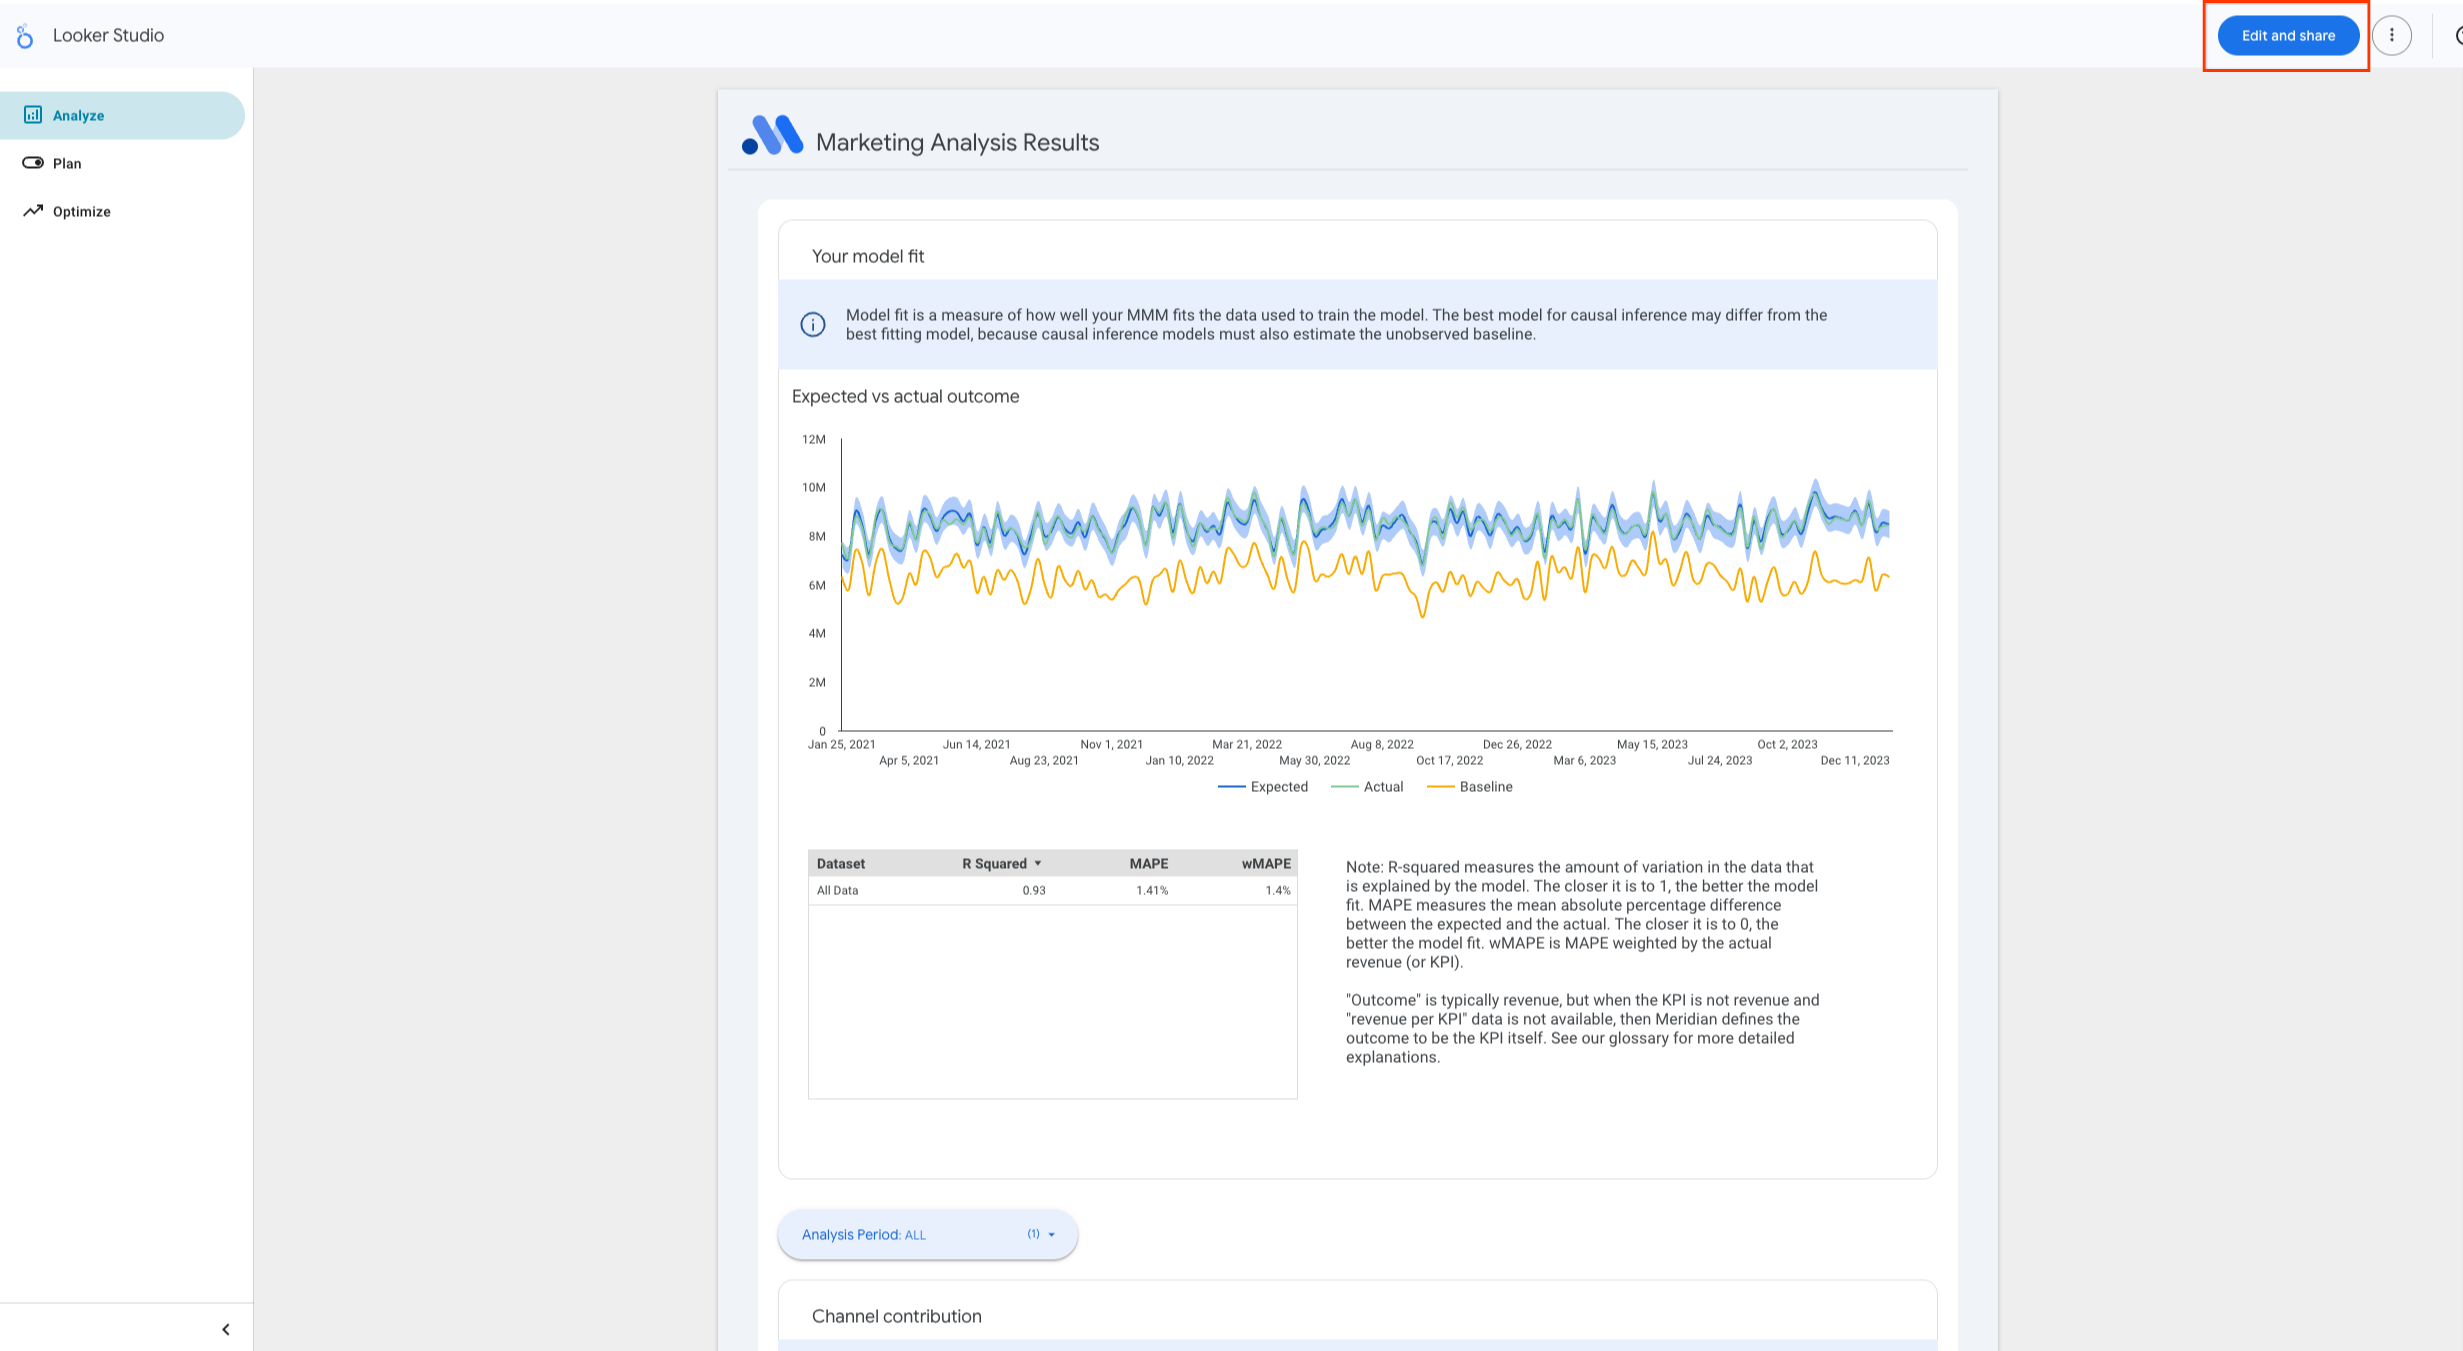.
1. Click on Ackonowledge and save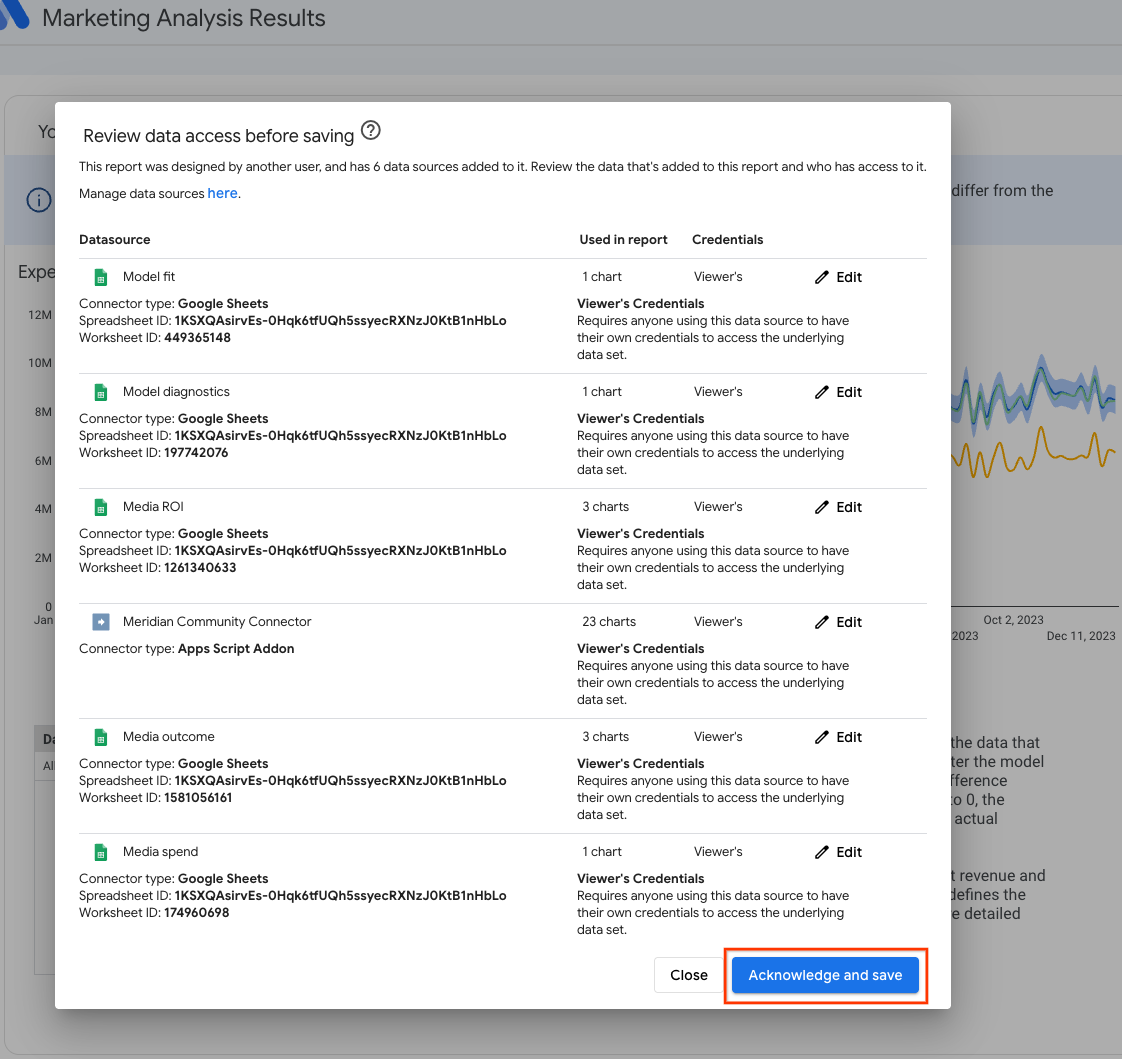.
1. Click on Allow to enable community visulizations, you only need to do it once 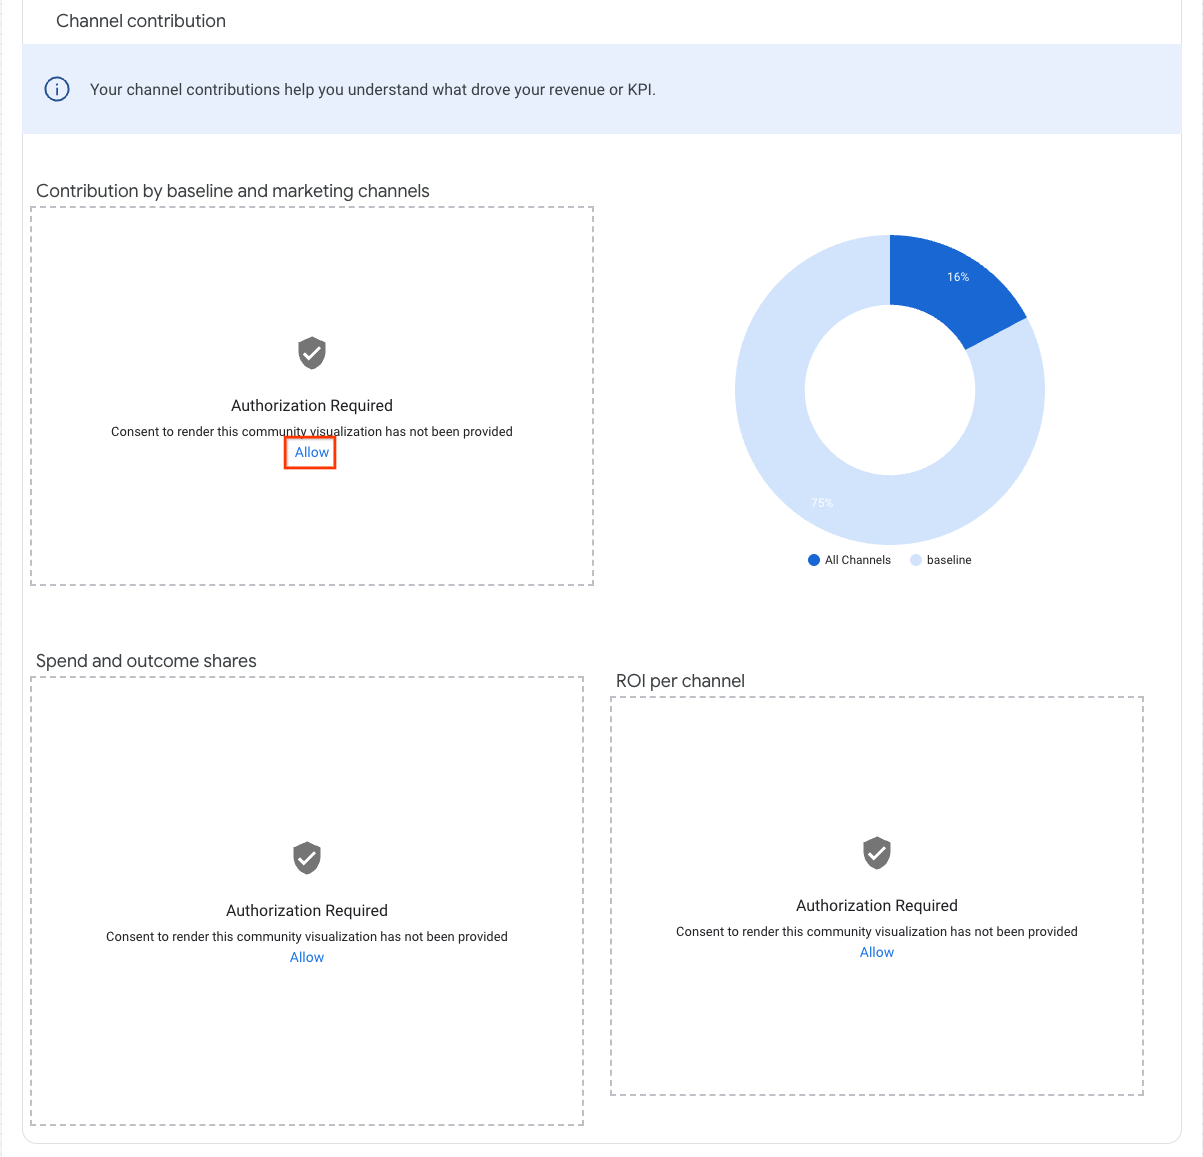.
1. The community visualization might still be disabled: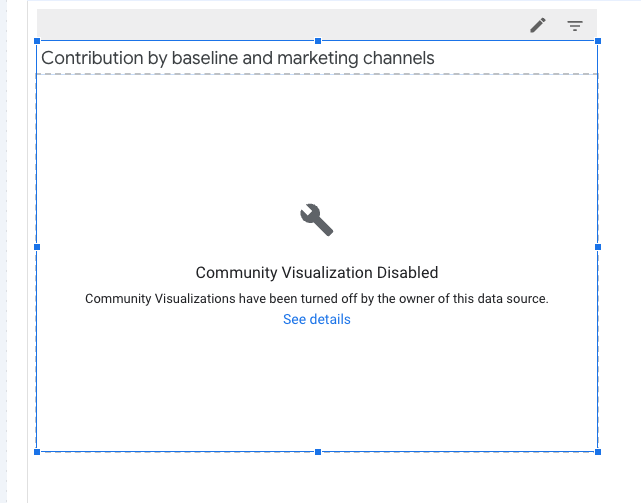 we can double check it: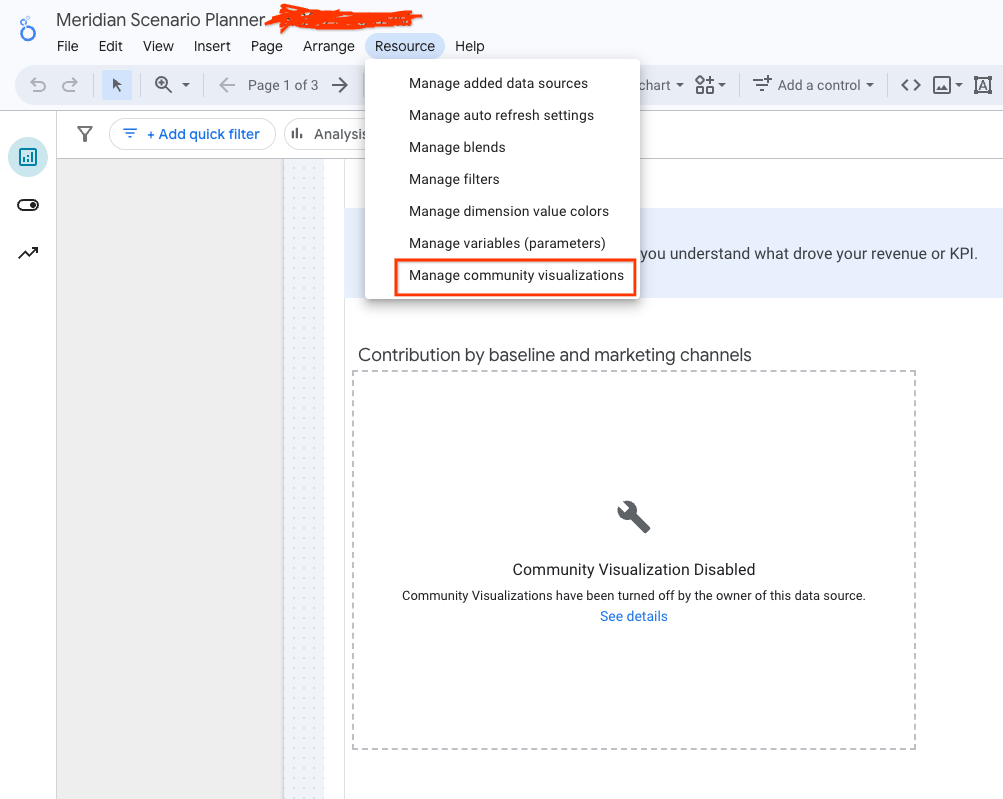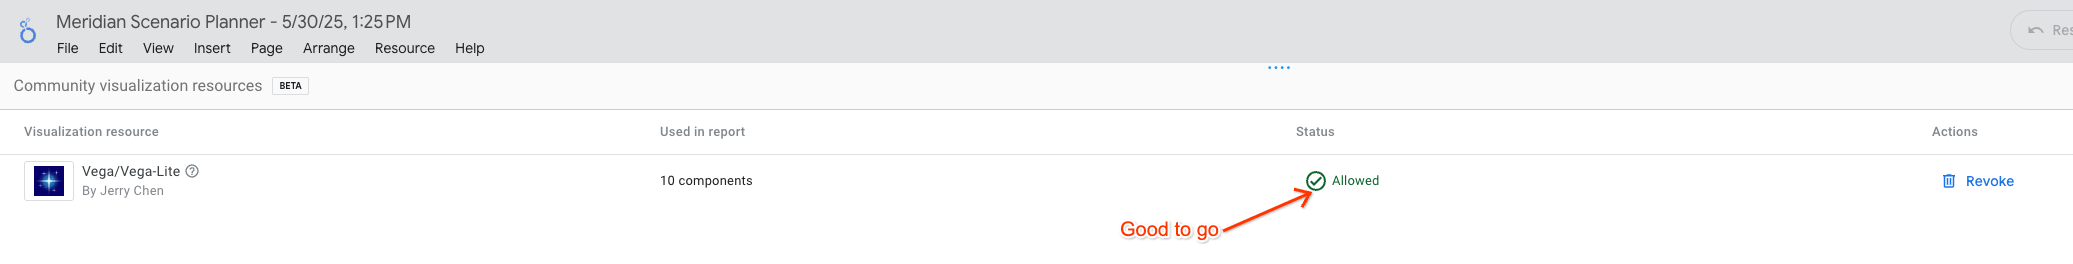

1. Refresh the page, the dashboard should display correctly.

Note that the data connector behind the dashboard is access controlled in pilot phase, the dashboard owner has to be a pilot user, the link above will fail otherwise.

Now, the dashboard should display correctly, and it should be sharable by click on the Share button on top. Please refer to <a href="https://drive.google.com/file/d/130dSItnVFF9hmiBhZFXcqZDzDQC-uedY/view?usp=sharing">Meridian Scenario Planner Pilot User Guide</a> on the further usage of the dashboard

Thanks for using Meridian Scenario Planner, your feedback is valuable to us, please share your feedback through [this form](https://docs.google.com/forms/d/1LBx5S1fdVP5IBt6RHfhj38Pepkik7jzI3KtI4udviqg).